## Approach Plan
1. Data Exploration
2. Create task dataset
3. Make MOO
4. RL - CL
5. RL - Dedicated Model
6. Comparison

# Load Data

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths to your datasets
task_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'  # Update this if the filename changes
employee_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'

# Load the datasets
df_tasks_original = pd.read_csv(task_data_path)
df_employees_original = pd.read_csv(employee_data_path)

# Extract skill columns from tasks and employees as lists
# New task structure: task_name, epic, story_points, then skills (cols 3 onward)
task_skill_cols = [col for col in df_tasks_original.columns[3:]]  # Skills start after task_name, epic, story_points
employee_skill_cols = [col for col in df_employees_original.columns[2:]]  # Skills from col 2 onward

# Find common skills and convert to list
common_skills = list(set(task_skill_cols).intersection(employee_skill_cols))

# Filter dataframes to common skills plus key columns
df_tasks = df_tasks_original[['task_id', 'story_points'] + common_skills]
df_employees = df_employees_original[['employee_id', 'Role'] + common_skills]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration

## Task Dataset

Mounted at /content/drive


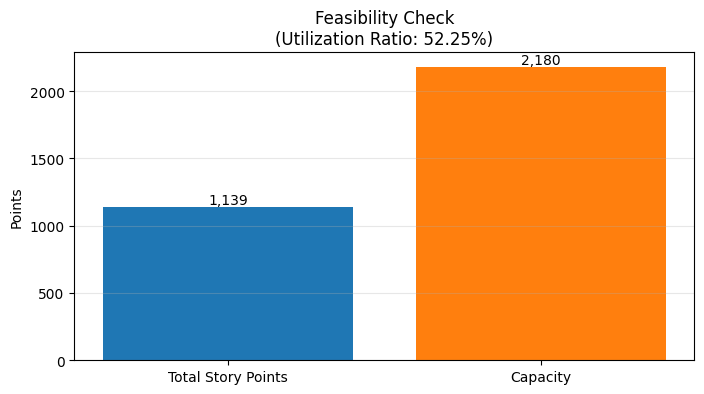

Total Story Points: 1139, Capacity: 2180, Ratio: 0.52


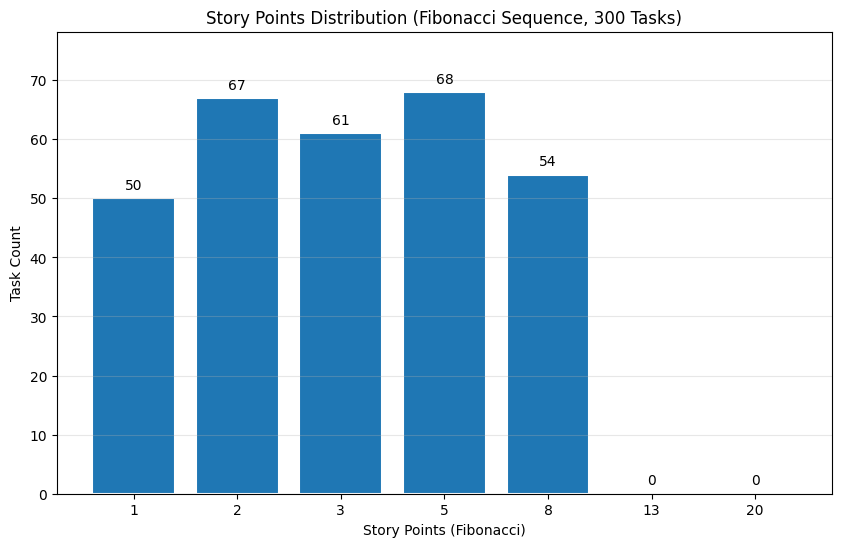

Fibonacci Story Points Counts:
 story_points
1     50
2     67
3     61
5     68
8     54
13     0
20     0
Name: count, dtype: int64
Story Points Bins:
 story_points
(-0.001, 5.0]    246
(5.0, 10.0]       54
(10.0, 15.0]       0
(15.0, 20.0]       0
Name: count, dtype: int64
Employee Sparsity: 0.01%, Task Sparsity: 16.73%
Mean Employee Skill (non-zero): 2.86
Mean Task Skill (non-zero): 3.01
Theoretical WED Range: Worst=0.0270, Best=1.0000


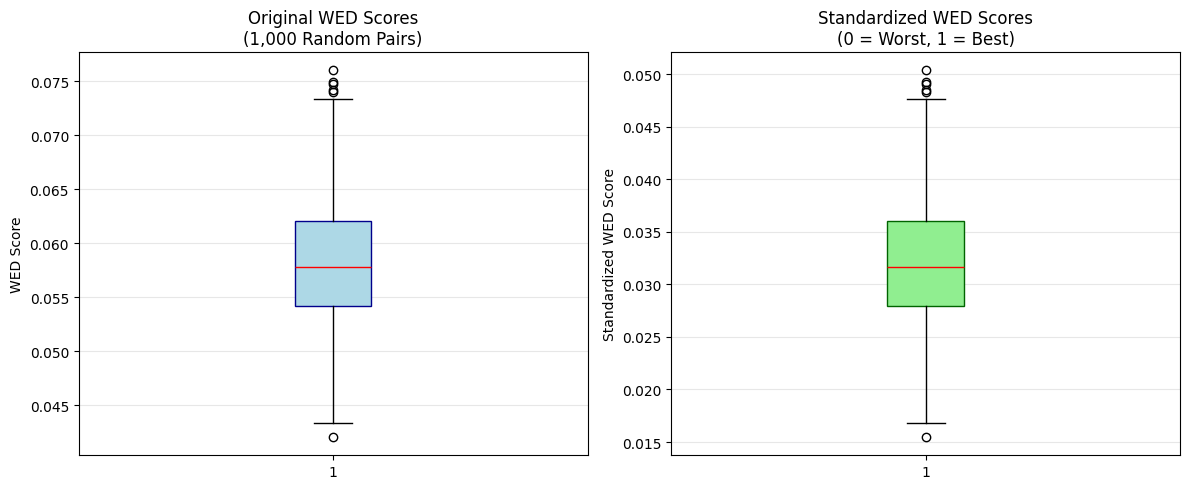

Original WED Stats: Mean=0.058, Median=0.058, Std=0.006

Boxplot Boundaries for Original WED Scores (1,000 Random Pairs):
Minimum (Lower Whisker): 0.0424
Q1 (25th Percentile): 0.0542
Median (50th Percentile): 0.0578
Q3 (75th Percentile): 0.0621
Maximum (Upper Whisker): 0.0739
Outliers: [np.float64(0.0747703149285708), np.float64(0.07497371778303324), np.float64(0.0760090745847469), np.float64(0.07400696716623192), np.float64(0.04204951921620088), np.float64(0.07417110988328064)]
Standardized WED Stats: Mean=0.032, Median=0.032, Std=0.006

Boxplot Boundaries for Standardized WED Scores (1,000 Random Pairs):
Minimum (Lower Whisker): 0.0158
Q1 (25th Percentile): 0.0280
Median (50th Percentile): 0.0317
Q3 (75th Percentile): 0.0361
Maximum (Upper Whisker): 0.0482
Outliers: [np.float64(0.04910906053544436), np.float64(0.04931810477007096), np.float64(0.0503821772028383), np.float64(0.04832454131542761), np.float64(0.015480753232959579), np.float64(0.04849323653234412)]
Project Stats:
       

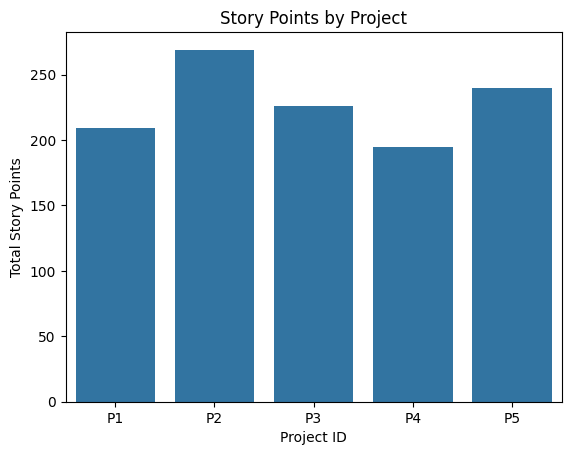

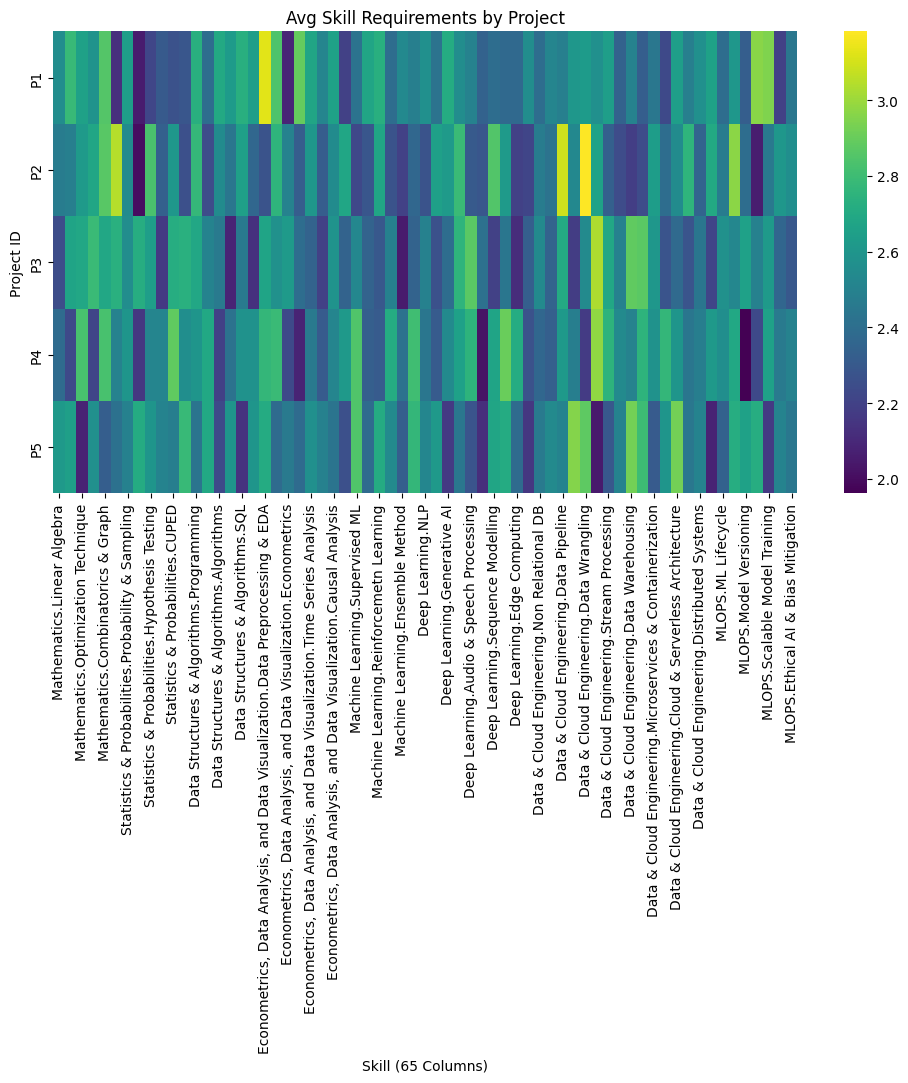


Average Skill Requirements by Project (Tabular Format for LLM Processing):
            Mathematics.Linear Algebra  Mathematics.Differential Equations  Mathematics.Optimization Technique  Mathematics.Calculus  Mathematics.Combinatorics & Graph  Statistics & Probabilities.Statistics  Statistics & Probabilities.Probability & Sampling  Statistics & Probabilities.Bayessian Method  Statistics & Probabilities.Hypothesis Testing  Statistics & Probabilities.A/B Testing  Statistics & Probabilities.CUPED  Data Structures & Algorithms.Complexity Analysis  Data Structures & Algorithms.Programming  Data Structures & Algorithms.Data Structures  Data Structures & Algorithms.Algorithms  Data Structures & Algorithms.Advanced Algorithms  Data Structures & Algorithms.SQL  Data Structures & Algorithms.Shell / Bash Scripting  Econometrics, Data Analysis, and Data Visualization.Data Preprocessing & EDA  Econometrics, Data Analysis, and Data Visualization.Data Viz & Storytelling  Econometrics, Data Analysis,

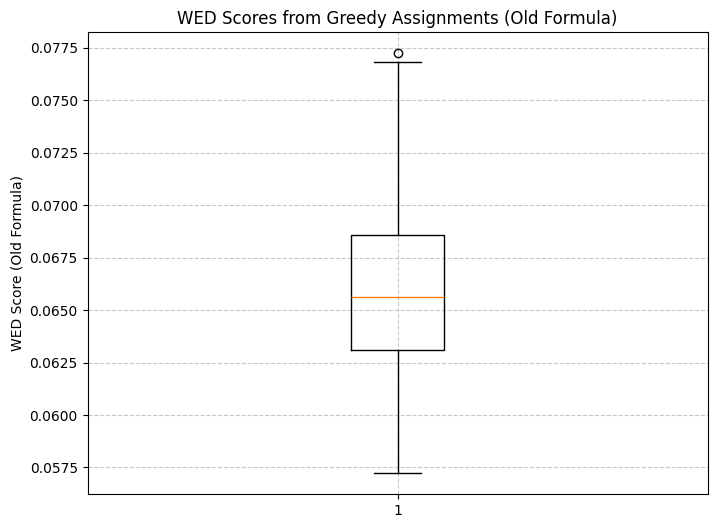

Original WED Scores (Old Formula): Mean=0.066, Median=0.066, Std=0.004

Boxplot Boundaries for Original WED Scores (Greedy Assignments):
Minimum (Lower Whisker): 0.0572
Q1 (25th Percentile): 0.0631
Median (50th Percentile): 0.0656
Q3 (75th Percentile): 0.0686
Maximum (Upper Whisker): 0.0769
Outliers: [np.float64(0.07722663748881113)]


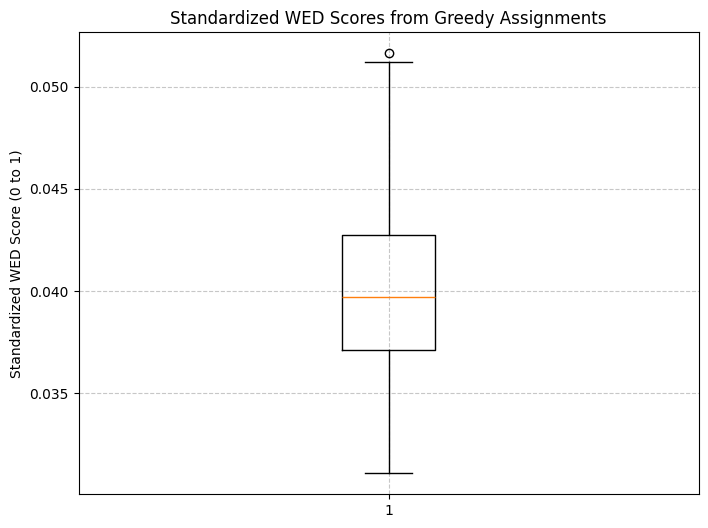

Standardized WED Scores: Mean=0.040, Median=0.040, Std=0.004

Boxplot Boundaries for Standardized WED Scores (Greedy Assignments):
Minimum (Lower Whisker): 0.0311
Q1 (25th Percentile): 0.0371
Median (50th Percentile): 0.0397
Q3 (75th Percentile): 0.0428
Maximum (Upper Whisker): 0.0513
Outliers: [np.float64(0.05163350922599258)]


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Paths
EMP_PATH = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'
TASK_PATH = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'

# Load
emp_df = pd.read_csv(EMP_PATH, index_col='employee_id').fillna(0).drop(columns=['No', 'Role'], errors='ignore')
task_df = pd.read_csv(TASK_PATH, index_col='task_id').fillna(0)
skill_cols = [col for col in task_df.columns if col not in ['project_id', 'story_points']]  # 65 skills
assert len(skill_cols) == 65, "Skill column count mismatch"
assert emp_df.shape[0] == 109 and task_df.shape[0] == 300, "Row count mismatch"

# 1. Feasibility (with visualization)
total_sp = task_df['story_points'].sum()
capacity = 109 * 20
ratio = total_sp/capacity

# New visualization for feasibility metrics
plt.figure(figsize=(8, 4))
bars = plt.bar(['Total Story Points', 'Capacity'], [total_sp, capacity], color=['#1f77b4', '#ff7f0e'])
plt.title(f"Feasibility Check\n(Utilization Ratio: {ratio:.2%})")
plt.ylabel("Points")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom')
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Total Story Points: {total_sp}, Capacity: {capacity}, Ratio: {total_sp/capacity:.2f}")

# 2. Story Points (Fibonacci Sequence) - with adjusted spacing
fibonacci_sp = [1, 2, 3, 5, 8, 13, 20]
sp_counts = task_df['story_points'].value_counts().reindex(fibonacci_sp, fill_value=0)

plt.figure(figsize=(10, 6))
plt.bar(range(len(sp_counts)), sp_counts.values, width=0.8,
        edgecolor='white', linewidth=1.5)
plt.title("Story Points Distribution (Fibonacci Sequence, 300 Tasks)")
plt.xlabel("Story Points (Fibonacci)")
plt.ylabel("Task Count")

# Add value labels on top of bars
for i, v in enumerate(sp_counts.values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.xticks(range(len(sp_counts)), sp_counts.index)
plt.ylim(0, sp_counts.max() * 1.15)  # Add headroom for labels
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Fibonacci Story Points Counts:\n", sp_counts)

# Binning for additional insight
bins = pd.cut(task_df['story_points'], bins=[0, 5, 10, 15, 20], include_lowest=True)
print("Story Points Bins:\n", bins.value_counts().sort_index())

# 3. Skills
emp_skills = emp_df[skill_cols]
task_skills = task_df[skill_cols]
emp_sparsity = (emp_skills == 0).mean().mean()
task_sparsity = (task_skills == 0).mean().mean()
print(f"Employee Sparsity: {emp_sparsity:.2%}, Task Sparsity: {task_sparsity:.2%}")
print(f"Mean Employee Skill (non-zero): {emp_skills[emp_skills > 0].mean().mean():.2f}")
print(f"Mean Task Skill (non-zero): {task_skills[task_skills > 0].mean().mean():.2f}")

# WED calculation (with standardization and visualization)
def calculate_wed(emp, task, alpha=0.05):
    weights = 1 / (1 + alpha * np.maximum(0, emp - task))
    wed = np.sqrt(np.sum(weights * (emp - task) ** 2))
    return 1 / (1 + wed)  # Convert distance to similarity score

# Theoretical worst and best WED scores
alpha = 0.05  # Same as in calculate_wed function
weights_worst = 1 / (1 + alpha * 5)  # emp=0, task=5, max difference
d_max = np.sqrt(np.sum(weights_worst * (0 - 5) ** 2 * 65))  # Max distance
wed_worst = 1 / (1 + d_max)  # Theoretical worst WED score
wed_best = 1 / (1 + 0)  # Theoretical best WED score (distance = 0)

print(f"Theoretical WED Range: Worst={wed_worst:.4f}, Best={wed_best:.4f}")

# Sample WED (1,000 pairs)
np.random.seed(42)
emp_idx = np.random.choice(109, 1000, replace=True)
task_idx = np.random.choice(300, 1000, replace=True)
wed_sample = [calculate_wed(emp_skills.iloc[i], task_skills.iloc[j])
              for i, j in zip(emp_idx, task_idx)]

# Standardize WED scores
wed_sample_std = [(wed - wed_worst) / (wed_best - wed_worst) for wed in wed_sample]

# Compute boxplot boundaries for 1,000 random pairs
def compute_boxplot_boundaries(data, label):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_whisker = max(min(data), q1 - 1.5 * iqr)
    upper_whisker = min(max(data), q3 + 1.5 * iqr)
    outliers = [x for x in data if x < lower_whisker or x > upper_whisker]
    print(f"\nBoxplot Boundaries for {label}:")
    print(f"Minimum (Lower Whisker): {lower_whisker:.4f}")
    print(f"Q1 (25th Percentile): {q1:.4f}")
    print(f"Median (50th Percentile): {np.median(data):.4f}")
    print(f"Q3 (75th Percentile): {q3:.4f}")
    print(f"Maximum (Upper Whisker): {upper_whisker:.4f}")
    print(f"Outliers: {outliers}")

# Visualization for 1,000 random pairs
plt.figure(figsize=(12, 5))

# Original WED scores
plt.subplot(1, 2, 1)
plt.boxplot(wed_sample, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='darkblue'),
            medianprops=dict(color='red'))
plt.title("Original WED Scores\n(1,000 Random Pairs)")
plt.ylabel("WED Score")
plt.grid(axis='y', alpha=0.3)

# Standardized WED scores
plt.subplot(1, 2, 2)
plt.boxplot(wed_sample_std, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            medianprops=dict(color='red'))
plt.title("Standardized WED Scores\n(0 = Worst, 1 = Best)")
plt.ylabel("Standardized WED Score")
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics and boundaries for 1,000 random pairs
print(f"Original WED Stats: Mean={np.mean(wed_sample):.3f}, Median={np.median(wed_sample):.3f}, Std={np.std(wed_sample):.3f}")
compute_boxplot_boundaries(wed_sample, "Original WED Scores (1,000 Random Pairs)")
print(f"Standardized WED Stats: Mean={np.mean(wed_sample_std):.3f}, Median={np.median(wed_sample_std):.3f}, Std={np.std(wed_sample_std):.3f}")
compute_boxplot_boundaries(wed_sample_std, "Standardized WED Scores (1,000 Random Pairs)")

# 4. Projects
proj_stats = task_df.groupby('project_id').agg(total_sp=('story_points', 'sum'), task_count=('story_points', 'count'))
print("Project Stats:\n", proj_stats)
sns.barplot(x=proj_stats.index, y=proj_stats['total_sp'])
plt.title("Story Points by Project")
plt.xlabel("Project ID")
plt.ylabel("Total Story Points")
plt.show()
proj_skills = task_df.groupby('project_id')[skill_cols].mean()
plt.figure(figsize=(12, 6))
sns.heatmap(proj_skills, cmap='viridis')
plt.title("Avg Skill Requirements by Project")
plt.xlabel("Skill (65 Columns)")
plt.ylabel("Project ID")
plt.show()

# Tabular output for avg skill requirements by project
print("\nAverage Skill Requirements by Project (Tabular Format for LLM Processing):")
print(proj_skills.to_string())

# 5. Greedy Approach with Old WED Formula and Standardization
# WED calculation (old method, without global_max normalization)
def calculate_wed_old(emp, task, alpha=0.05):
    weights = 1 / (1 + alpha * np.maximum(0, emp - task))
    wed = np.sqrt(np.sum(weights * (emp - task) ** 2))
    return 1 / (1 + wed)  # Old normalization method

# Initialize data structures
assignments = {}  # emp_idx -> list of (task_id, project_id, sp, wed_score)
workload = np.zeros(109)

# Initialize assignments dictionary for all employees
for emp_idx in range(109):
    assignments[emp_idx] = []

# Run Greedy with old WED calculation
np.random.seed(42)
for task_idx in np.random.permutation(300):
    task = task_skills.iloc[task_idx]
    sp = task_df['story_points'].iloc[task_idx]
    project_id = task_df['project_id'].iloc[task_idx]
    task_id = task_df.index[task_idx]
    best_emp, best_wed = None, -1
    for emp_idx in range(109):
        if workload[emp_idx] + sp <= 20:
            wed = calculate_wed_old(emp_skills.iloc[emp_idx], task)
            if wed > best_wed:
                best_wed, best_emp = wed, emp_idx
    if best_emp is not None:
        assignments[best_emp].append((task_id, project_id, sp, best_wed))
        workload[best_emp] += sp

# Step 1: Save assignments as CSV
data = []
for emp_idx, tasks in assignments.items():
    employee_id = emp_df.index[emp_idx]  # e.g., 'Talent 1'
    projects = [proj for _, proj, _, _ in tasks] if tasks else []
    assigned_tasks = [task for task, _, _, _ in tasks] if tasks else []
    sum_sp = sum(sp for _, _, sp, _ in tasks) if tasks else 0
    wasted_sp = 20 - sum_sp
    similarity_scores = [wed for _, _, _, wed in tasks] if tasks else []
    data.append([employee_id, projects, assigned_tasks, sum_sp, wasted_sp, similarity_scores])

df = pd.DataFrame(data, columns=['employee', 'project', 'assigned_task', 'sum_sp', 'wasted_sp', 'similarity_score'])
df.to_csv('greedy_old_method.csv', index=False)

# Step 2: Collect WED scores
weds_old = [wed for emp_tasks in assignments.values() for _, _, _, wed in emp_tasks]

# Step 3: Standardize the WED scores
# Compute theoretical worst and best scores
alpha = 0.05
# Theoretical worst: emp=[0,0,...,0], task=[5,5,...,5], 65 skills
weights_worst = 1 / (1 + alpha * 5)  # Since emp=0, task=5, max difference
d_max = np.sqrt(np.sum(weights_worst * (0 - 5) ** 2) * 65)  # Max distance
wed_old_worst = 1 / (1 + d_max)  # Theoretical worst WED score
wed_old_best = 1 / (1 + 0)  # Theoretical best WED score (distance = 0)
print(f"\nTheoretical Worst WED (Old Formula): {wed_old_worst:.6f}")
print(f"Theoretical Best WED (Old Formula): {wed_old_best:.6f}")

# Standardize: map wed_old_worst to 0, wed_old_best to 1
weds_standardized = [(wed - wed_old_worst) / (wed_old_best - wed_old_worst) for wed in weds_old]

# Step 4: Visualizations
# Boxplot 1: Original WED scores (old formula)
plt.figure(figsize=(8, 6))
plt.boxplot(weds_old)
plt.title("WED Scores from Greedy Assignments (Old Formula)")
plt.ylabel("WED Score (Old Formula)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print(f"Original WED Scores (Old Formula): Mean={np.mean(weds_old):.3f}, Median={np.median(weds_old):.3f}, Std={np.std(weds_old):.3f}")
compute_boxplot_boundaries(weds_old, "Original WED Scores (Greedy Assignments)")

# Boxplot 2: Standardized WED scores
plt.figure(figsize=(8, 6))
plt.boxplot(weds_standardized)
plt.title("Standardized WED Scores from Greedy Assignments")
plt.ylabel("Standardized WED Score (0 to 1)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print(f"Standardized WED Scores: Mean={np.mean(weds_standardized):.3f}, Median={np.median(weds_standardized):.3f}, Std={np.std(weds_standardized):.3f}")
compute_boxplot_boundaries(weds_standardized, "Standardized WED Scores (Greedy Assignments)")

## Employee Dataset

Mounted at /content/drive


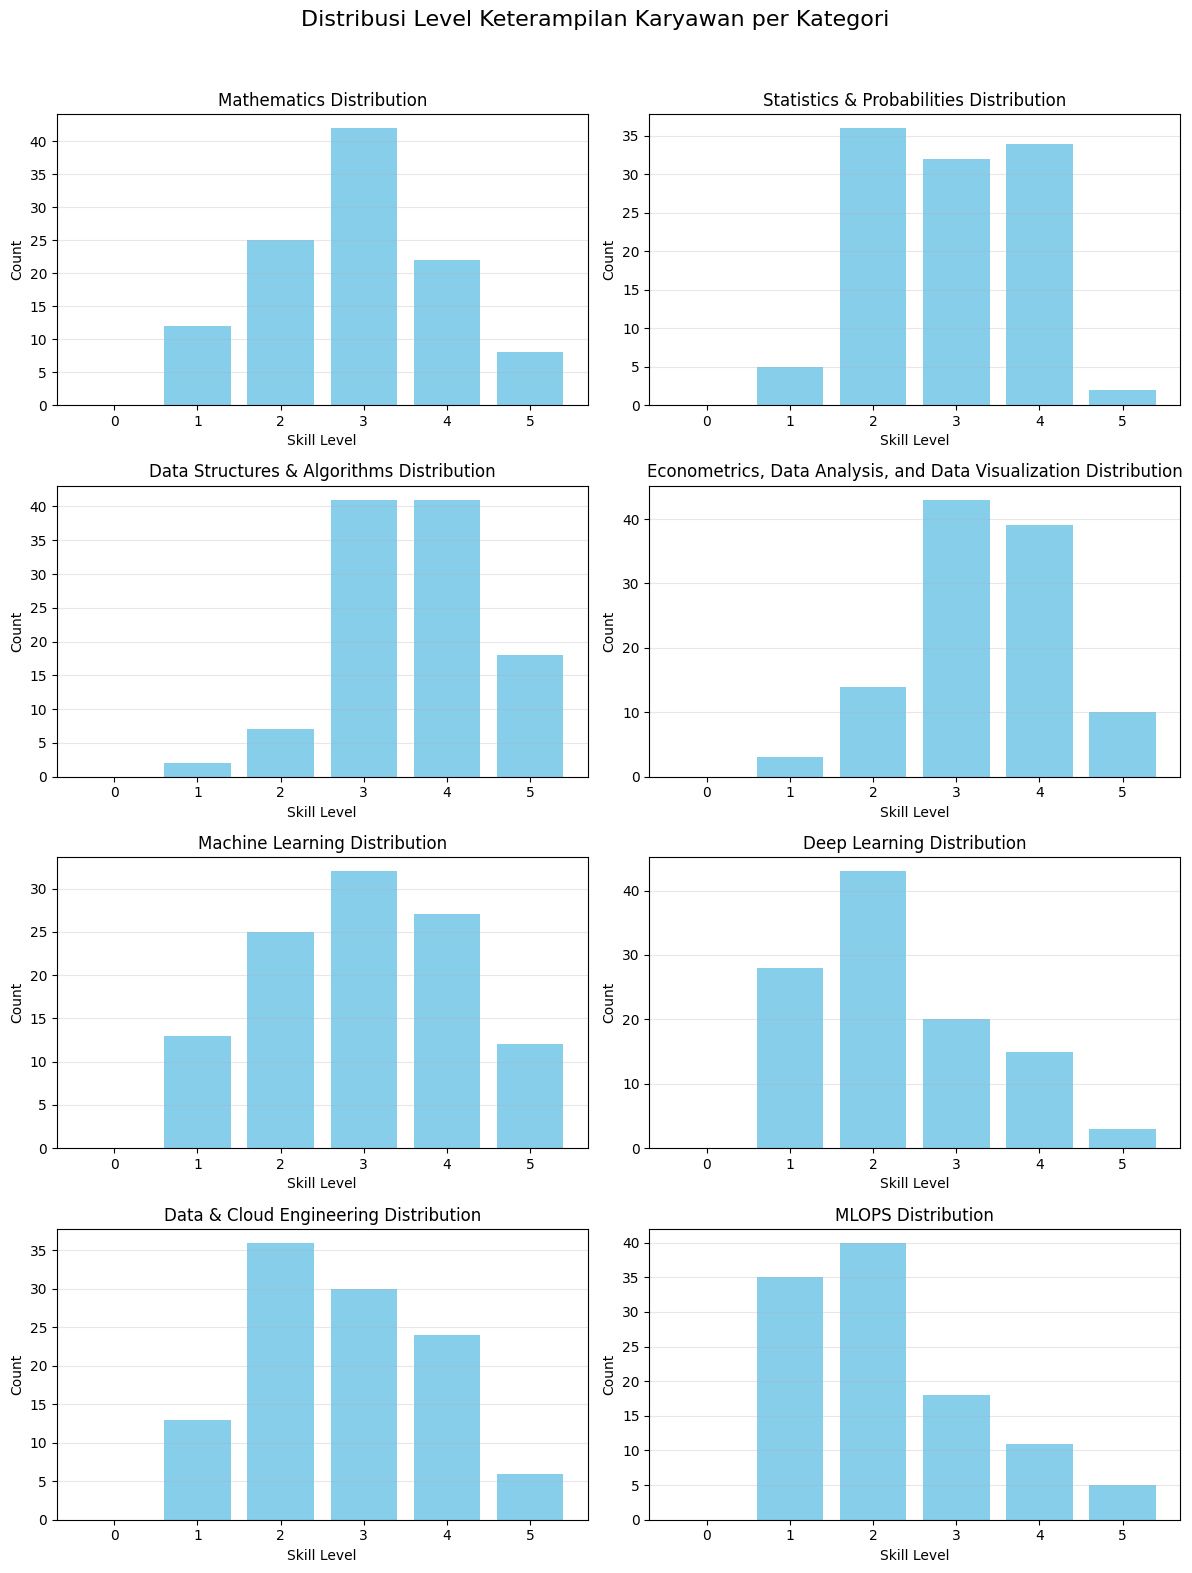

Tabel Distribusi Level Keterampilan Karyawan per Kategori:
                                                    Level 0  Level 1  Level 2  \
Mathematics                                               0       12       25   
Statistics & Probabilities                                0        5       36   
Data Structures & Algorithms                              0        2        7   
Econometrics, Data Analysis, and Data Visualiza...        0        3       14   
Machine Learning                                          0       13       25   
Deep Learning                                             0       28       43   
Data & Cloud Engineering                                  0       13       36   
MLOPS                                                     0       35       40   

                                                    Level 3  Level 4  Level 5  
Mathematics                                              42       22        8  
Statistics & Probabilities                         

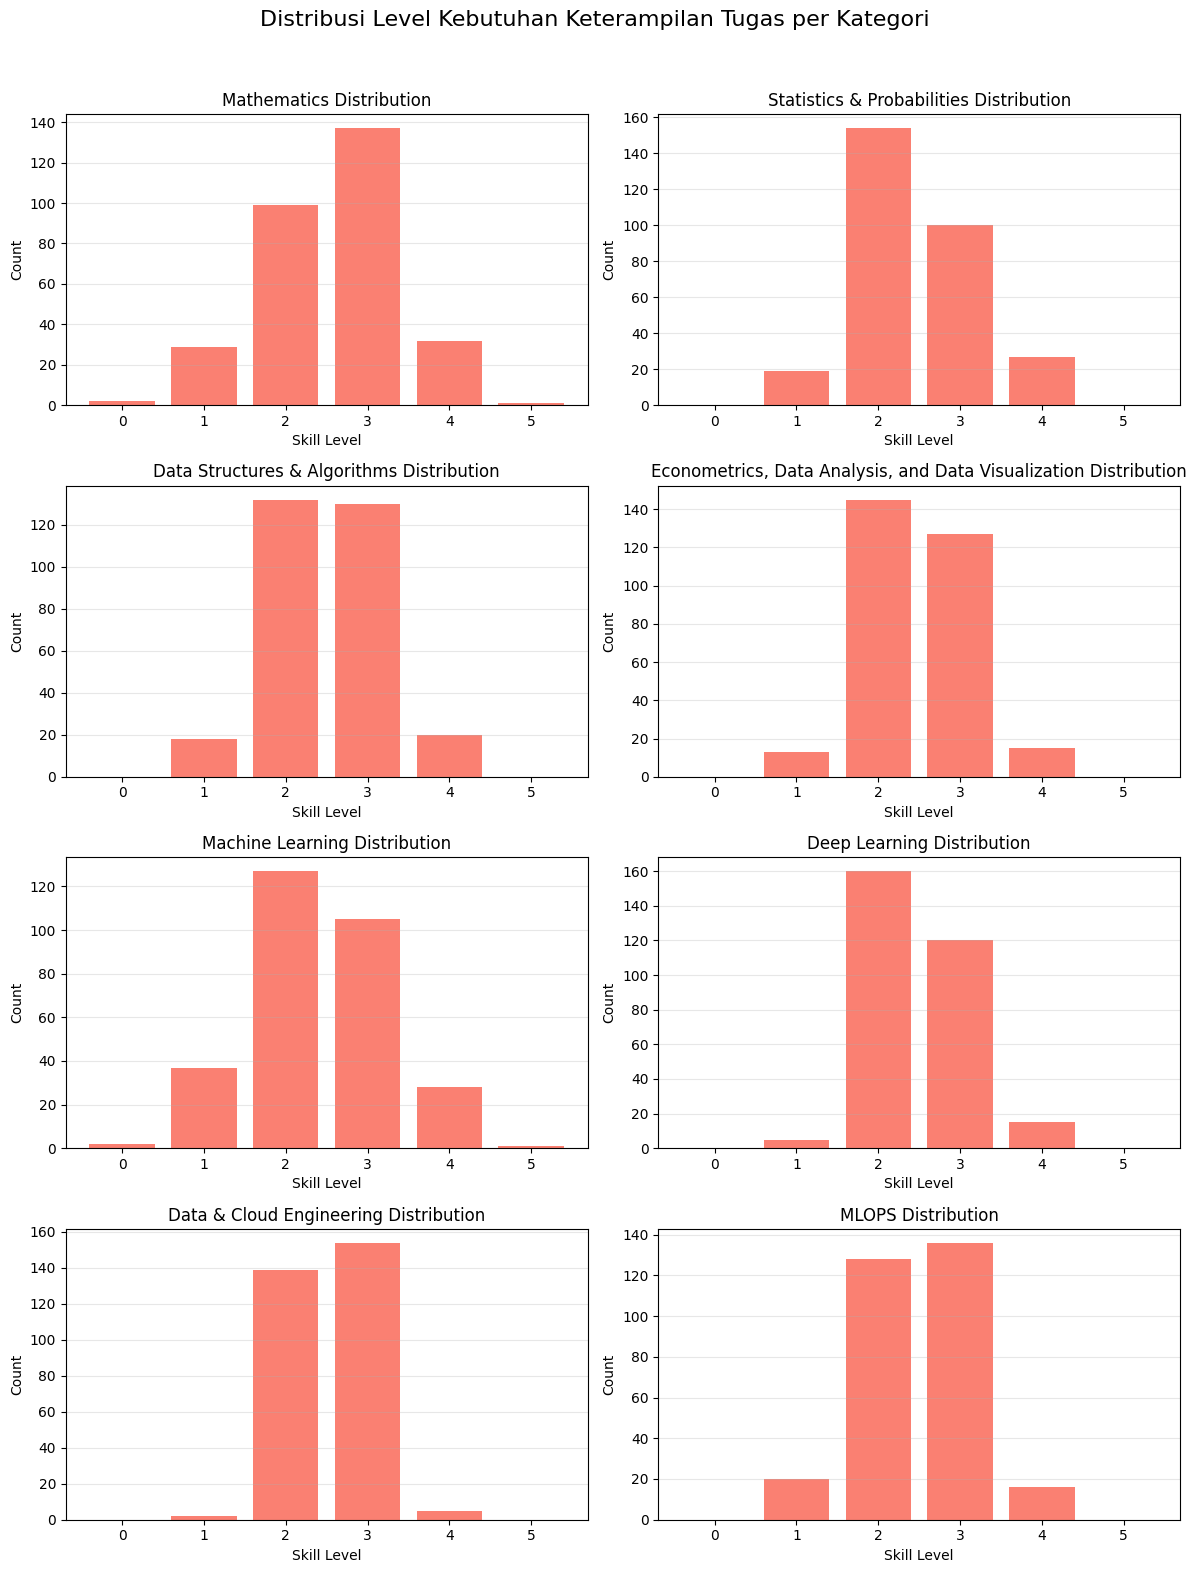

Tabel Distribusi Level Kebutuhan Keterampilan Tugas per Kategori:
                                                    Level 0  Level 1  Level 2  \
Mathematics                                               2       29       99   
Statistics & Probabilities                                0       19      154   
Data Structures & Algorithms                              0       18      132   
Econometrics, Data Analysis, and Data Visualiza...        0       13      145   
Machine Learning                                          2       37      127   
Deep Learning                                             0        5      160   
Data & Cloud Engineering                                  0        2      139   
MLOPS                                                     0       20      128   

                                                    Level 3  Level 4  Level 5  
Mathematics                                             137       32        1  
Statistics & Probabilities                  

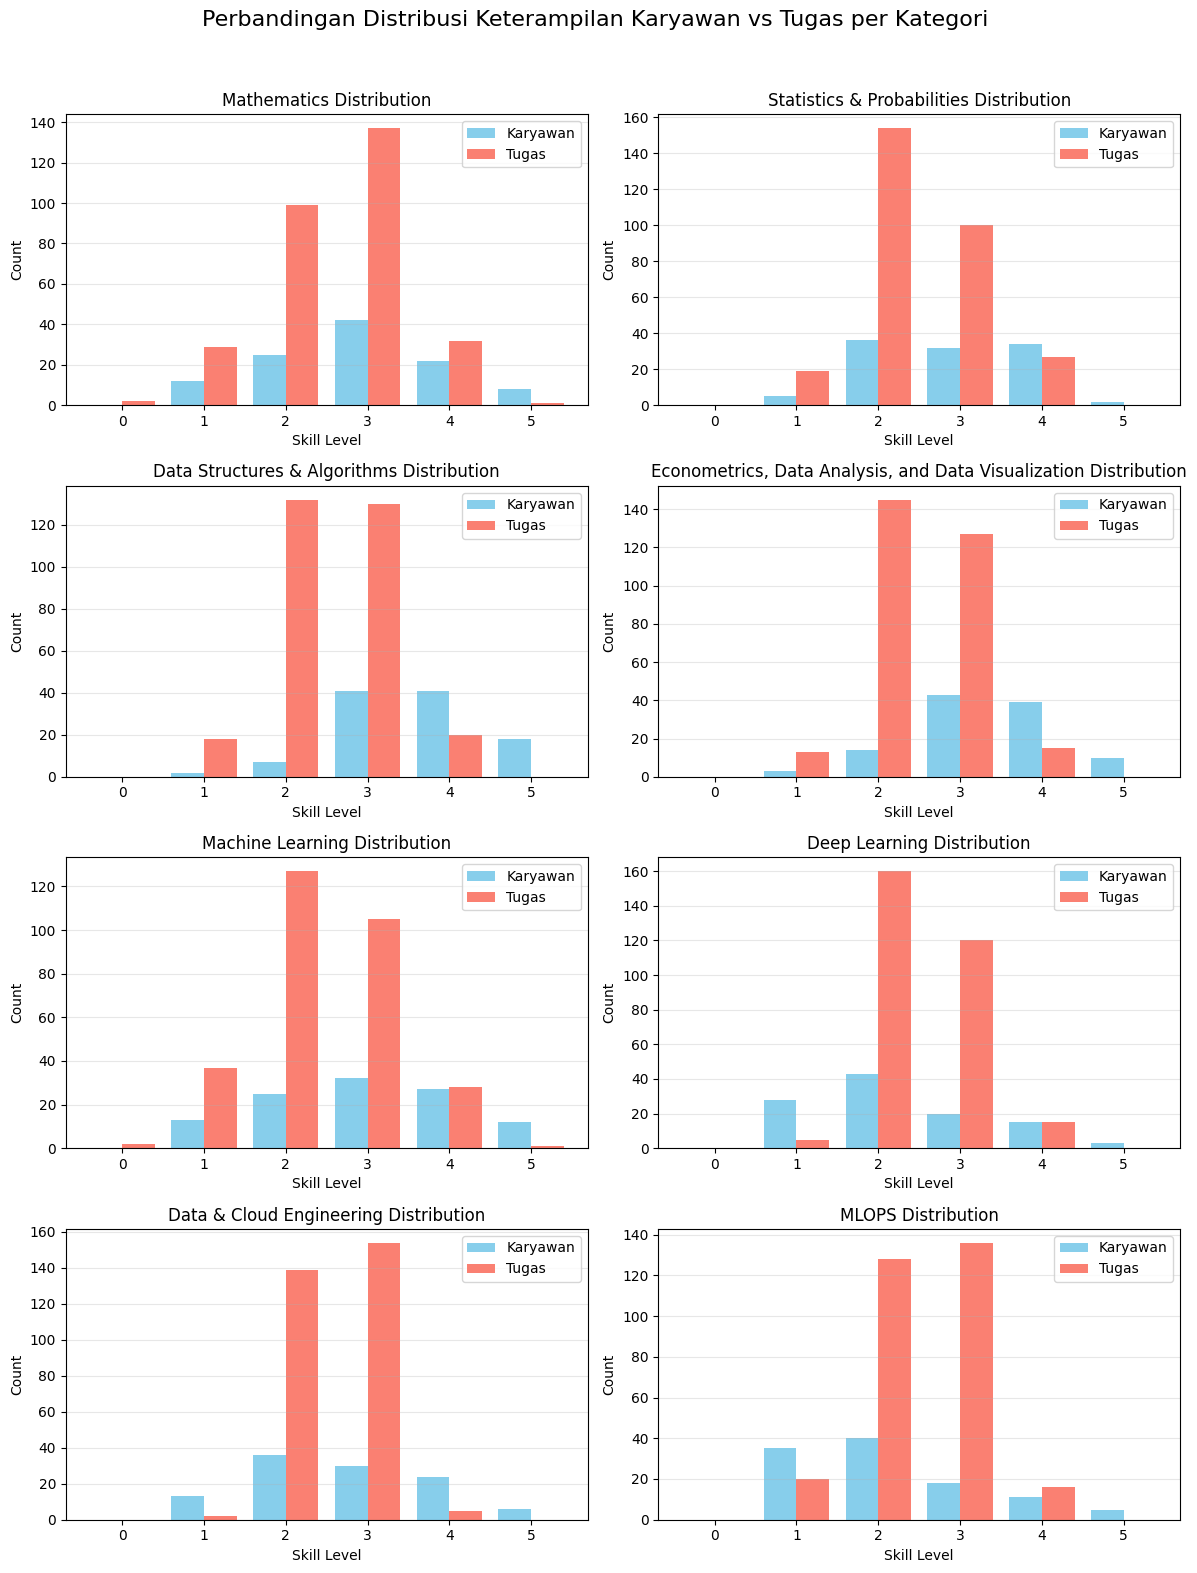

Tabel Perbandingan Distribusi Keterampilan Karyawan vs Tugas per Kategori:
                                                    Karyawan Level 0  \
Mathematics                                                        0   
Statistics & Probabilities                                         0   
Data Structures & Algorithms                                       0   
Econometrics, Data Analysis, and Data Visualiza...                 0   
Machine Learning                                                   0   
Deep Learning                                                      0   
Data & Cloud Engineering                                           0   
MLOPS                                                              0   

                                                    Karyawan Level 1  \
Mathematics                                                       12   
Statistics & Probabilities                                         5   
Data Structures & Algorithms                                

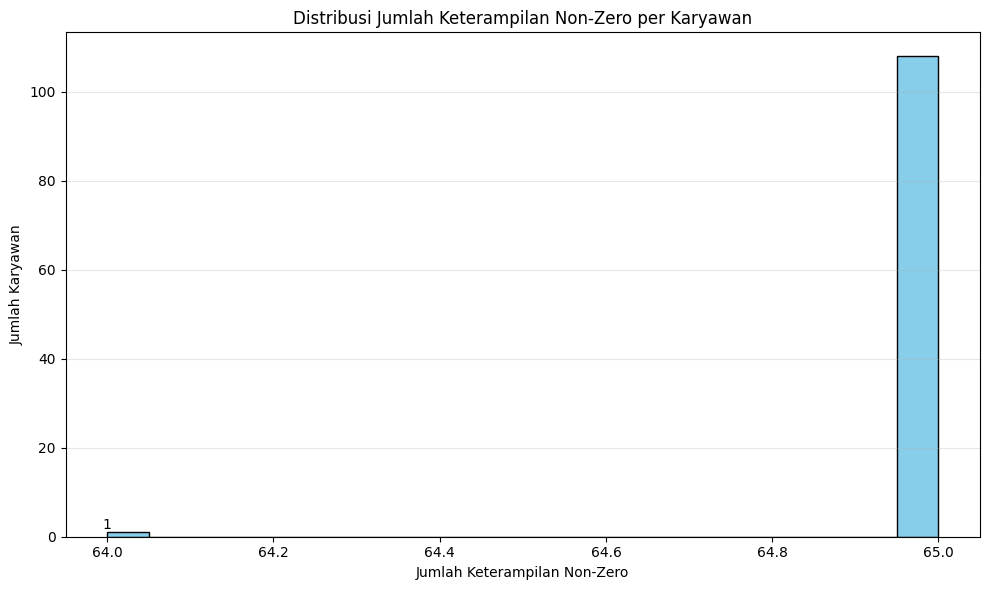

Tabel Distribusi Jumlah Keterampilan Non-Zero per Karyawan:
   Jumlah Keterampilan Non-Zero  Jumlah Karyawan
0                            64                1
1                            65              108


Jumlah karyawan dengan 64 keterampilan non-zero: 1
Jumlah karyawan dengan 65 keterampilan non-zero: 108


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Paths
EMP_PATH = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'
TASK_PATH = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'

# Load data
emp_df = pd.read_csv(EMP_PATH, index_col='employee_id').fillna(0).drop(columns=['No', 'Role'], errors='ignore')
task_df = pd.read_csv(TASK_PATH, index_col='task_id').fillna(0)

# Define skill columns
skill_cols = [col for col in task_df.columns if col not in ['project_id', 'story_points']]  # 65 skills
assert len(skill_cols) == 65, "Skill column count mismatch"
assert emp_df.shape[0] == 109 and task_df.shape[0] == 300, "Row count mismatch"

# Extract skill data
emp_skills = emp_df[skill_cols]
task_skills = task_df[skill_cols]

# Define 8 categories based on prefixes in skill column names
categories = {
    'Mathematics': [col for col in skill_cols if col.startswith('Mathematics')],
    'Statistics & Probabilities': [col for col in skill_cols if col.startswith('Statistics & Probabilities')],
    'Data Structures & Algorithms': [col for col in skill_cols if col.startswith('Data Structures & Algorithms')],
    'Econometrics, Data Analysis, and Data Visualization': [col for col in skill_cols if col.startswith('Econometrics, Data Analysis, and Data Visualization')],
    'Machine Learning': [col for col in skill_cols if col.startswith('Machine Learning')],
    'Deep Learning': [col for col in skill_cols if col.startswith('Deep Learning')],
    'Data & Cloud Engineering': [col for col in skill_cols if col.startswith('Data & Cloud Engineering')],
    'MLOPS': [col for col in skill_cols if col.startswith('MLOPS')]
}

# 1. Distribusi Skor Keterampilan Karyawan per Kategori
# Create table for employee skill distribution
emp_skill_dist = {category: {level: 0 for level in range(6)} for category in categories.keys()}

# Create subplots for employees (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
fig.suptitle("Distribusi Level Keterampilan Karyawan per Kategori", fontsize=16)

for idx, (category, cols) in enumerate(categories.items()):
    row = idx // 2
    col = idx % 2
    # Calculate mean skill score per employee for this category
    emp_scores = emp_skills[cols].mean(axis=1)
    # Round scores to nearest integer (0-5) for discrete levels
    emp_scores_rounded = np.round(emp_scores).astype(int)
    # Plot histogram
    counts, _ = np.histogram(emp_scores_rounded, bins=[0, 1, 2, 3, 4, 5, 6])
    for level, count in enumerate(counts):
        emp_skill_dist[category][level] = count
    axes[row, col].hist(emp_scores_rounded, bins=[0, 1, 2, 3, 4, 5, 6], align='left', rwidth=0.8, color='skyblue')
    axes[row, col].set_title(f"{category} Distribution")
    axes[row, col].set_xlabel("Skill Level")
    axes[row, col].set_ylabel("Count")
    axes[row, col].set_xticks([0, 1, 2, 3, 4, 5])
    axes[row, col].grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Convert employee skill distribution to DataFrame
emp_skill_dist_df = pd.DataFrame(emp_skill_dist).T
emp_skill_dist_df.columns = [f"Level {i}" for i in range(6)]
print("Tabel Distribusi Level Keterampilan Karyawan per Kategori:")
print(emp_skill_dist_df)
print("\n")

# 2. Distribusi Skor Keterampilan Tugas per Kategori
# Create table for task skill distribution
task_skill_dist = {category: {level: 0 for level in range(6)} for category in categories.keys()}

# Create subplots for tasks (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
fig.suptitle("Distribusi Level Kebutuhan Keterampilan Tugas per Kategori", fontsize=16)

for idx, (category, cols) in enumerate(categories.items()):
    row = idx // 2
    col = idx % 2
    # Calculate mean skill requirement per task for this category
    task_scores = task_skills[cols].mean(axis=1)
    # Round scores to nearest integer (0-5) for discrete levels
    task_scores_rounded = np.round(task_scores).astype(int)
    # Plot histogram
    counts, _ = np.histogram(task_scores_rounded, bins=[0, 1, 2, 3, 4, 5, 6])
    for level, count in enumerate(counts):
        task_skill_dist[category][level] = count
    axes[row, col].hist(task_scores_rounded, bins=[0, 1, 2, 3, 4, 5, 6], align='left', rwidth=0.8, color='salmon')
    axes[row, col].set_title(f"{category} Distribution")
    axes[row, col].set_xlabel("Skill Level")
    axes[row, col].set_ylabel("Count")
    axes[row, col].set_xticks([0, 1, 2, 3, 4, 5])
    axes[row, col].grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Convert task skill distribution to DataFrame
task_skill_dist_df = pd.DataFrame(task_skill_dist).T
task_skill_dist_df.columns = [f"Level {i}" for i in range(6)]
print("Tabel Distribusi Level Kebutuhan Keterampilan Tugas per Kategori:")
print(task_skill_dist_df)
print("\n")

# 3. Perbandingan Distribusi Karyawan vs Tugas (Side-by-Side Histogram)
# Create table for comparison
comparison_dist = {}
for category in categories.keys():
    comparison_dist[category] = {
        f"Karyawan Level {i}": emp_skill_dist[category][i] for i in range(6)
    }
    comparison_dist[category].update({
        f"Tugas Level {i}": task_skill_dist[category][i] for i in range(6)
    })

# Create subplots for side-by-side comparison (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
fig.suptitle("Perbandingan Distribusi Keterampilan Karyawan vs Tugas per Kategori", fontsize=16)

for idx, (category, cols) in enumerate(categories.items()):
    row = idx // 2
    col = idx % 2
    # Employee scores
    emp_scores = emp_skills[cols].mean(axis=1)
    emp_scores_rounded = np.round(emp_scores).astype(int)
    # Task scores
    task_scores = task_skills[cols].mean(axis=1)
    task_scores_rounded = np.round(task_scores).astype(int)
    # Plot side-by-side histogram
    axes[row, col].hist([emp_scores_rounded, task_scores_rounded], bins=[0, 1, 2, 3, 4, 5, 6],
                        align='left', rwidth=0.8, label=['Karyawan', 'Tugas'], color=['skyblue', 'salmon'])
    axes[row, col].set_title(f"{category} Distribution")
    axes[row, col].set_xlabel("Skill Level")
    axes[row, col].set_ylabel("Count")
    axes[row, col].set_xticks([0, 1, 2, 3, 4, 5])
    axes[row, col].legend()
    axes[row, col].grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Convert comparison distribution to DataFrame
comparison_dist_df = pd.DataFrame(comparison_dist).T
print("Tabel Perbandingan Distribusi Keterampilan Karyawan vs Tugas per Kategori:")
print(comparison_dist_df)
print("\n")

# 4. Histogram Jumlah Keterampilan Non-Zero (dengan Label untuk 64 dan 65)
num_nonzero_skills = (emp_skills > 0).sum(axis=1)
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(num_nonzero_skills, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribusi Jumlah Keterampilan Non-Zero per Karyawan")
plt.xlabel("Jumlah Keterampilan Non-Zero")
plt.ylabel("Jumlah Karyawan")
plt.grid(axis='y', alpha=0.3)

# Add labels for 64 and 65 non-zero skills
count_64 = sum(num_nonzero_skills == 64)
count_65 = sum(num_nonzero_skills == 65)
for i in range(len(bins)-1):
    if bins[i] <= 64 < bins[i+1]:
        plt.text(64, counts[i], f"{int(counts[i])}", ha='center', va='bottom')
    if bins[i] <= 65 < bins[i+1]:
        plt.text(65, counts[i], f"{int(counts[i])}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Create table for non-zero skills distribution
nonzero_skills_dist = pd.Series(num_nonzero_skills).value_counts().sort_index()
nonzero_skills_dist_df = pd.DataFrame({
    'Jumlah Keterampilan Non-Zero': nonzero_skills_dist.index,
    'Jumlah Karyawan': nonzero_skills_dist.values
})
print("Tabel Distribusi Jumlah Keterampilan Non-Zero per Karyawan:")
print(nonzero_skills_dist_df)
print("\n")
print(f"Jumlah karyawan dengan 64 keterampilan non-zero: {count_64}")
print(f"Jumlah karyawan dengan 65 keterampilan non-zero: {count_65}")

# MOO Approach with Old Equation

Theoretical Worst WED (Old Formula): 0.044351
Theoretical Best WED (Old Formula): 1.000000


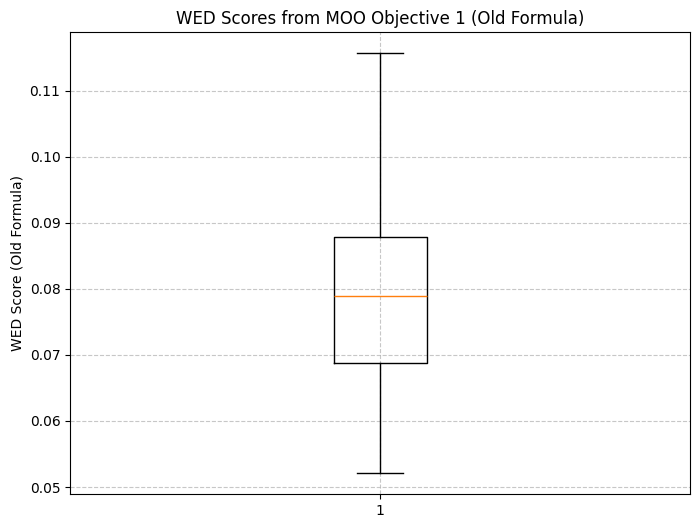

Original WED Scores (Old Formula): Mean=0.079, Median=0.079, Std=0.012


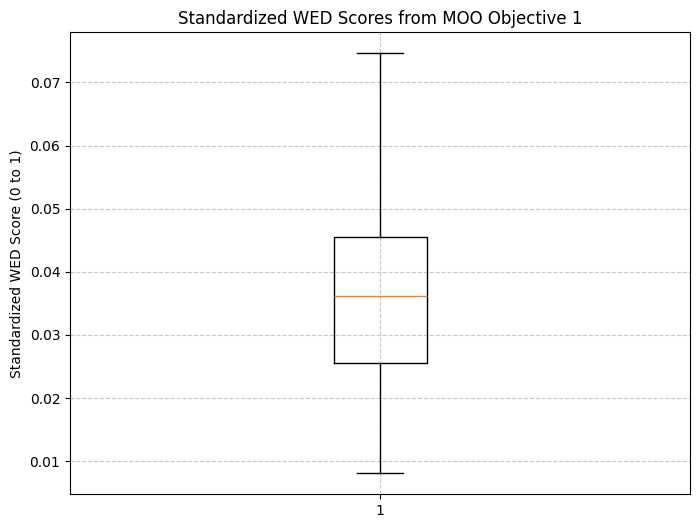

Standardized WED Scores: Mean=0.036, Median=0.036, Std=0.013


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Load the Objective 1 results
path_obj1 = '/content/drive/MyDrive/Skripsi/Resources/Datasets/Recent/result_obj1.csv'
result_obj1 = pd.read_csv(path_obj1)

# Extract similarity scores
# The 'similarity_score' column contains lists as strings, so we need to parse them
weds_old = []
for scores_str in result_obj1['similarity_score']:
    # Convert string representation of list to actual list
    scores = ast.literal_eval(scores_str)
    weds_old.extend(scores)

# Compute theoretical worst and best scores for standardization
alpha = 0.5  # As defined in your original custom_we function
# Theoretical worst: emp=[0,0,...,0], task=[5,5,...,5], 65 skills
weights_worst = 1 / (1 + alpha * 5)  # Since emp=0, task=5, max difference
d_max = np.sqrt(np.sum(weights_worst * (0 - 5) ** 2) * 65)  # Max distance
wed_old_worst = 1 / (1 + d_max)  # Theoretical worst WED score
wed_old_best = 1 / (1 + 0)  # Theoretical best WED score (distance = 0)
print(f"Theoretical Worst WED (Old Formula): {wed_old_worst:.6f}")
print(f"Theoretical Best WED (Old Formula): {wed_old_best:.6f}")

# Standardize: map wed_old_worst to 0, wed_old_best to 1
weds_standardized = [(wed - wed_old_worst) / (wed_old_best - wed_old_worst) for wed in weds_old]

# Visualization 1: Original WED scores (old formula)
plt.figure(figsize=(8, 6))
plt.boxplot(weds_old)
plt.title("WED Scores from MOO Objective 1 (Old Formula)")
plt.ylabel("WED Score (Old Formula)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print(f"Original WED Scores (Old Formula): Mean={np.mean(weds_old):.3f}, Median={np.median(weds_old):.3f}, Std={np.std(weds_old):.3f}")

# Visualization 2: Standardized WED scores
plt.figure(figsize=(8, 6))
plt.boxplot(weds_standardized)
plt.title("Standardized WED Scores from MOO Objective 1")
plt.ylabel("Standardized WED Score (0 to 1)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print(f"Standardized WED Scores: Mean={np.mean(weds_standardized):.3f}, Median={np.median(weds_standardized):.3f}, Std={np.std(weds_standardized):.3f}")

Theoretical Worst WED (Old Formula): 0.044351
Theoretical Best WED (Old Formula): 1.000000


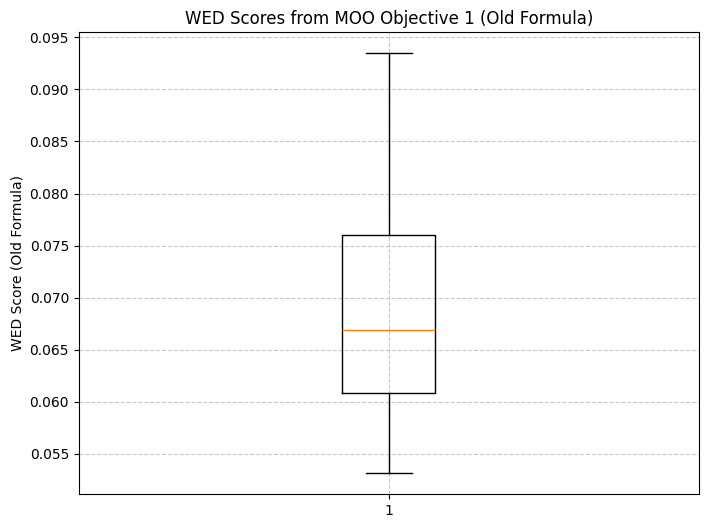

Original WED Scores (Old Formula): Mean=0.069, Median=0.067, Std=0.009


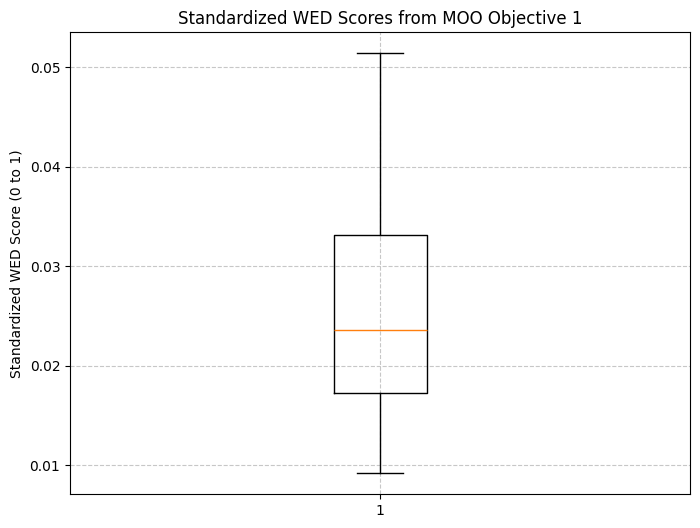

Standardized WED Scores: Mean=0.025, Median=0.024, Std=0.010


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Load the Objective 1 results
path_obj1 = '/content/drive/MyDrive/Skripsi/Resources/Datasets/Recent/result_moo.csv'
result_obj1 = pd.read_csv(path_obj1)

# Extract similarity scores
# The 'similarity_score' column contains lists as strings, so we need to parse them
weds_old = []
for scores_str in result_obj1['similarity_score']:
    # Convert string representation of list to actual list
    scores = ast.literal_eval(scores_str)
    weds_old.extend(scores)

# Compute theoretical worst and best scores for standardization
alpha = 0.5  # As defined in your original custom_we function
# Theoretical worst: emp=[0,0,...,0], task=[5,5,...,5], 65 skills
weights_worst = 1 / (1 + alpha * 5)  # Since emp=0, task=5, max difference
d_max = np.sqrt(np.sum(weights_worst * (0 - 5) ** 2) * 65)  # Max distance
wed_old_worst = 1 / (1 + d_max)  # Theoretical worst WED score
wed_old_best = 1 / (1 + 0)  # Theoretical best WED score (distance = 0)
print(f"Theoretical Worst WED (Old Formula): {wed_old_worst:.6f}")
print(f"Theoretical Best WED (Old Formula): {wed_old_best:.6f}")

# Standardize: map wed_old_worst to 0, wed_old_best to 1
weds_standardized = [(wed - wed_old_worst) / (wed_old_best - wed_old_worst) for wed in weds_old]

# Visualization 1: Original WED scores (old formula)
plt.figure(figsize=(8, 6))
plt.boxplot(weds_old)
plt.title("WED Scores from MOO Objective 1 (Old Formula)")
plt.ylabel("WED Score (Old Formula)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print(f"Original WED Scores (Old Formula): Mean={np.mean(weds_old):.3f}, Median={np.median(weds_old):.3f}, Std={np.std(weds_old):.3f}")

# Visualization 2: Standardized WED scores
plt.figure(figsize=(8, 6))
plt.boxplot(weds_standardized)
plt.title("Standardized WED Scores from MOO Objective 1")
plt.ylabel("Standardized WED Score (0 to 1)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print(f"Standardized WED Scores: Mean={np.mean(weds_standardized):.3f}, Median={np.median(weds_standardized):.3f}, Std={np.std(weds_standardized):.3f}")

# MOO Approach for sprint planning and new dataset

In [1]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 32.3 MB/s eta 0:00:00


In [6]:
# Install Gurobi
!pip install gurobipy

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import gurobipy as gp
from gurobipy import GRB

# Mount Google Drive
drive.mount('/content/drive')

# Paths to datasets
employee_dir = '/content/drive/MyDrive/Skripsi/Resources/Datasets/Recent/Employee Subset/'
task_dir = '/content/drive/MyDrive/Skripsi/Resources/Datasets/Recent/Task Subset/'
output_dir = '/content/drive/MyDrive/Skripsi/Resources/MOO_Results/'

# Skill columns
common_skills = ['Mathematics', 'Statistics & Probabilities', 'Data Structures & Algorithms',
                 'Machine Learning', 'Deep Learning', 'Data & Cloud Engineering', 'MLOPS']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Optimized employee_emp3_group1 with task_emp3_group1
Optimized employee_emp3_group1 with task_emp3_group2
Optimized employee_emp3_group1 with task_emp3_group3
Optimized employee_emp3_group2 with task_emp3_group1
Optimized employee_emp3_group2 with task_emp3_group2
Optimized employee_emp3_group2 with task_emp3_group3
Optimized employee_emp3_group3 with task_emp3_group1
Optimized employee_emp3_group3 with task_emp3_group2
Optimized employee_emp3_group3 with task_emp3_group3
Optimized employee_emp3_group4 with task_emp3_group1
Optimized employee_emp3_group4 with task_emp3_group2
Optimized employee_emp3_group4 with task_emp3_group3
Optimized employee_emp3_group5 with task_emp3_group1
Optimized employee_emp3_group5 with task_emp3_group2
Optimized employee_emp3_group5 with task_emp3_group3
Optimized employee_emp3_group6 with task_emp3_group1
Optimized employee_emp3_group6 with task_emp3_group2
Optimized employee_emp3_group6 with task_emp3_group3
Optimized employee_emp3_group7 with task_emp3_

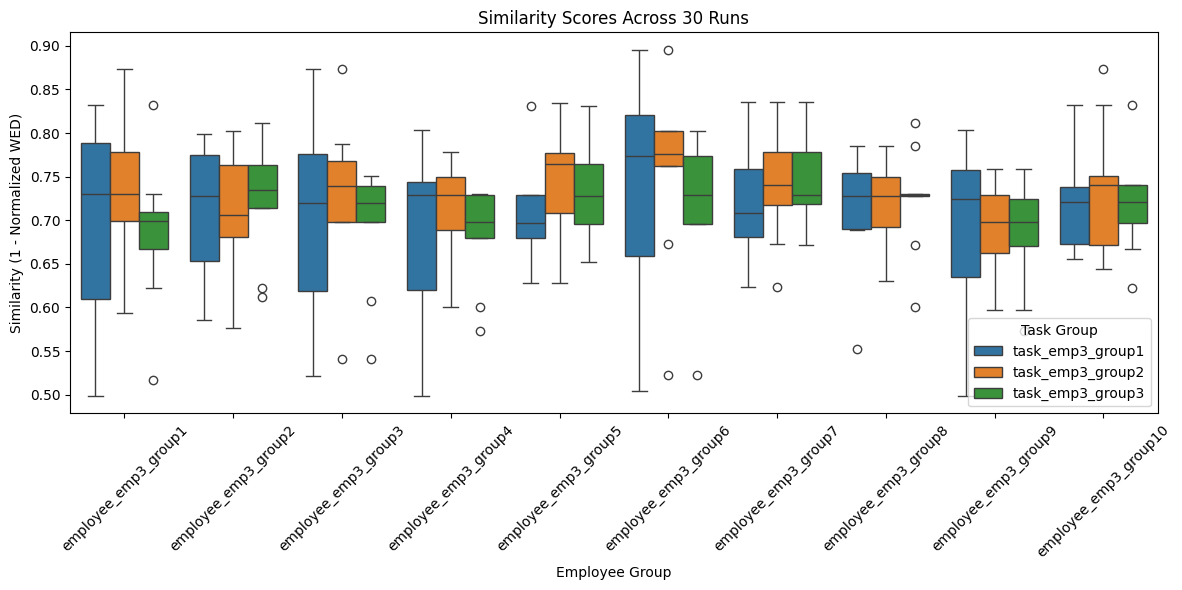

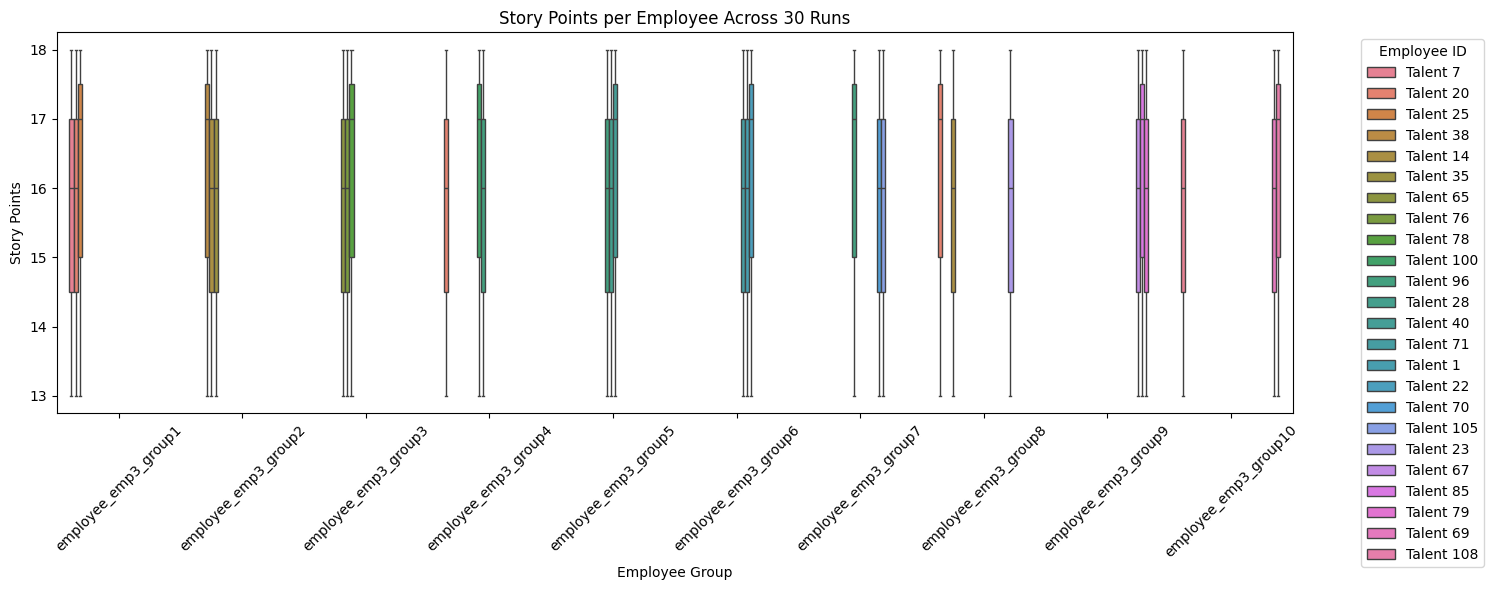

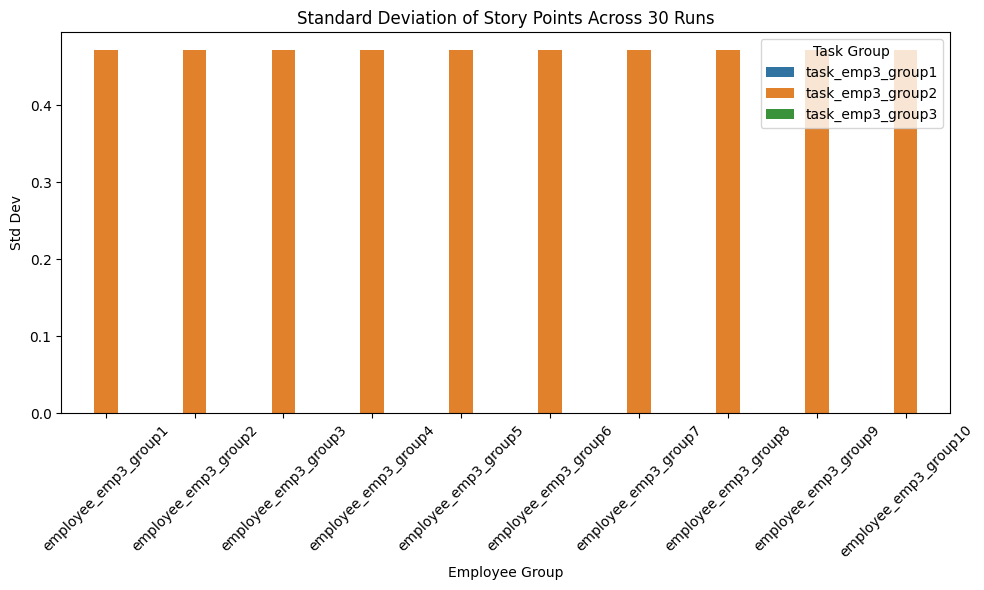

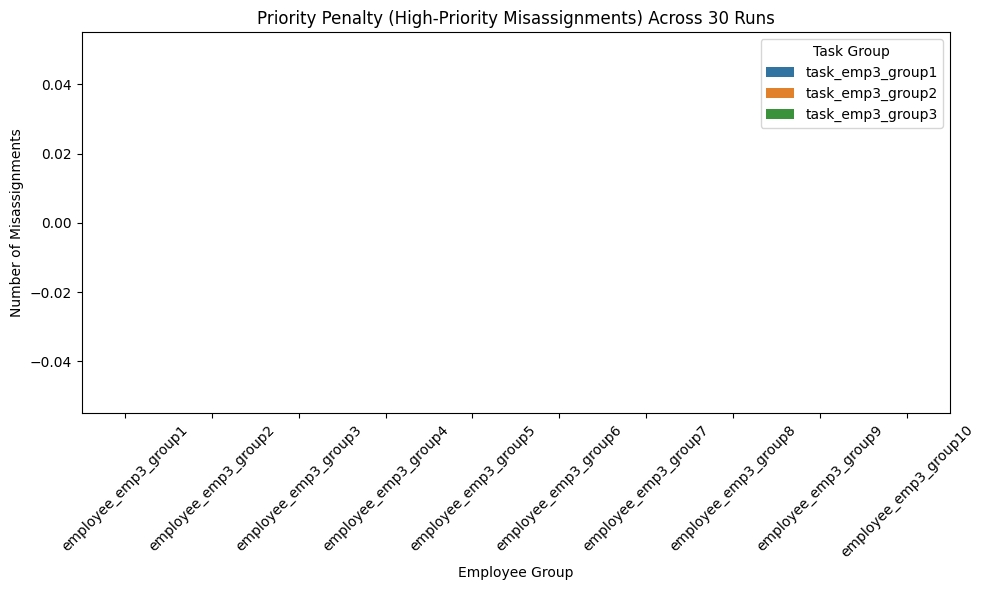

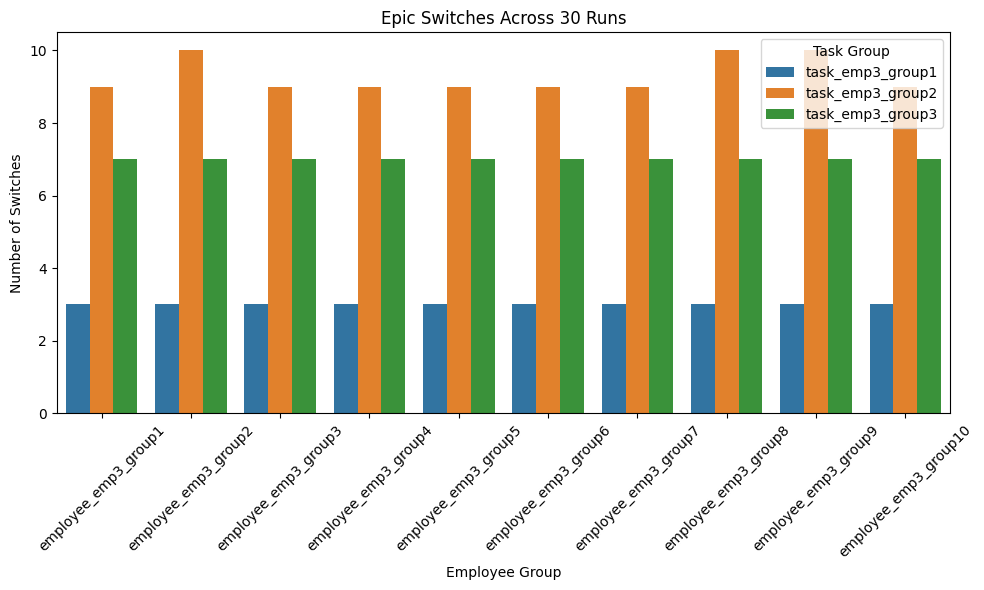

In [7]:
# Define WED function (α = 0.1 per our tweak)
def calculate_weighted_euclidean_distance(employee_skills, task_skills, alpha=0.1):
    employee_skills = np.array(employee_skills)
    task_skills = np.array(task_skills)
    diff = employee_skills - task_skills
    weights = 1 / (1 + alpha * np.maximum(0, diff))
    wed = np.sqrt(np.sum(weights * (diff ** 2)))
    max_wed = np.sqrt(7 * 25)  # 13.229
    return 1 - (wed / max_wed)  # Similarity score

# Employee and task groups
employee_groups = [f"employee_emp3_group{i}" for i in range(1, 11)]
task_groups = [f"task_emp3_group{i}" for i in range(1, 4)]

# Store results
results = []

# MOO for all 30 runs
for emp_group in employee_groups:
    emp_df = pd.read_csv(f"{employee_dir}{emp_group}.csv")
    E = emp_df['employee_id'].tolist()  # 3 employees
    emp_skills = emp_df[common_skills].values

    for task_group in task_groups:
        task_df = pd.read_csv(f"{task_dir}{task_group}.csv")
        T = task_df.index.tolist()
        task_skills = task_df[common_skills].values
        sp = task_df['story_points'].values
        priority = task_df['priority'].map({'high': 1, 'medium': 0.5, 'low': 0}).values
        epic = task_df['epic'].values

        # Precompute similarity
        similarity = {}
        best_emp = {}
        for j in T:
            max_similarity = -1
            for i, e_id in enumerate(E):
                sim = calculate_weighted_euclidean_distance(emp_skills[i], task_skills[j])
                similarity[(e_id, j)] = sim
                if sim > max_similarity:
                    max_similarity = sim
                    best_emp[j] = e_id

        # Gurobi model
        model = gp.Model(f"MOO_{emp_group}_{task_group}")
        model.setParam('OutputFlag', 0)  # Silent mode for speed

        # Variables
        x = model.addVars([(e_id, j) for e_id in E for j in T], vtype=GRB.BINARY, name="x")
        d_plus = model.addVars(E, vtype=GRB.CONTINUOUS, name="d_plus")
        d_minus = model.addVars(E, vtype=GRB.CONTINUOUS, name="d_minus")
        y = model.addVars([(e_id, j1, j2) for e_id in E for j1 in T for j2 in T if j1 < j2],
                          vtype=GRB.BINARY, name="y")

        # Constraints
        for j in T:
            model.addConstr(gp.quicksum(x[e_id, j] for e_id in E) == 1)
        for e_id in E:
            model.addConstr(gp.quicksum(x[e_id, j] * sp[j] for j in T) <= 20)
        SP = {e_id: gp.quicksum(x[e_id, j] * sp[j] for j in T) for e_id in E}
        mu = gp.quicksum(SP[e_id] for e_id in E) / len(E)
        for e_id in E:
            model.addConstr(SP[e_id] - mu == d_plus[e_id] - d_minus[e_id])
        for e_id in E:
            for j1 in T:
                for j2 in T:
                    if j1 < j2 and epic[j1] != epic[j2]:
                        model.addConstr(y[e_id, j1, j2] >= x[e_id, j1] + x[e_id, j2] - 1)
                        model.addConstr(y[e_id, j1, j2] <= x[e_id, j1])
                        model.addConstr(y[e_id, j1, j2] <= x[e_id, j2])

        # Objectives
        Z1 = gp.quicksum(x[e_id, j] * (1 - similarity[(e_id, j)]) for e_id in E for j in T)
        Z2 = gp.quicksum(d_plus[e_id] + d_minus[e_id] for e_id in E)
        Z3 = gp.quicksum(x[e_id, j] for j in T if priority[j] == 1 for e_id in E if e_id != best_emp[j])
        Z4 = gp.quicksum(y[e_id, j1, j2] for e_id in E for j1 in T for j2 in T if j1 < j2 and epic[j1] != epic[j2])

        # Weighted objective
        w = [0.5, 0.3, 0.15, 0.05]
        model.setObjective(w[0] * Z1 + w[1] * Z2 + w[2] * Z3 + w[3] * Z4, GRB.MINIMIZE)

        # Optimize
        model.optimize()

        if model.status == GRB.OPTIMAL:
            assignment = {(e_id, j): x[e_id, j].X for e_id in E for j in T}
            sp_per_emp = [SP[e_id].getValue() for e_id in E]
            results.append({
                'emp_group': emp_group,
                'task_group': task_group,
                'similarity': [similarity[(e_id, j)] for e_id in E for j in T if assignment[(e_id, j)] > 0.5],
                'sp_per_emp': sp_per_emp,
                'std_dev': np.std(sp_per_emp),
                'priority_penalty': Z3.getValue(),
                'epic_switches': Z4.getValue(),
                'employees': E
            })
            print(f"Optimized {emp_group} with {task_group}")

# Process results
results_df = pd.DataFrame(results)

# --- Visualizations ---
# 1. Similarity Boxplots (side by side)
plt.figure(figsize=(12, 6))
sns.boxplot(x='emp_group', y='similarity', hue='task_group', data=results_df.explode('similarity'))
plt.title('Similarity Scores Across 30 Runs')
plt.xlabel('Employee Group')
plt.ylabel('Similarity (1 - Normalized WED)')
plt.xticks(rotation=45)
plt.legend(title='Task Group')
plt.tight_layout()
plt.savefig(f"{output_dir}moo_similarity_boxplots.png")
plt.show()

# 2. Story Points per Employee
# First Graph: Employee-by-employee distribution
sp_df = pd.DataFrame([
    {'emp_group': res['emp_group'], 'task_group': res['task_group'], 'employee': emp, 'story_points': sp}
    for res in results for emp, sp in zip(res['employees'], res['sp_per_emp'])
])
plt.figure(figsize=(15, 6))
sns.boxplot(x='emp_group', y='story_points', hue='employee', data=sp_df)
plt.title('Story Points per Employee Across 30 Runs')
plt.xlabel('Employee Group')
plt.ylabel('Story Points')
plt.xticks(rotation=45)
plt.legend(title='Employee ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{output_dir}moo_sp_per_employee.png")
plt.show()

# Second Graph: Std Deviation
plt.figure(figsize=(10, 6))
sns.barplot(x='emp_group', y='std_dev', hue='task_group', data=results_df)
plt.title('Standard Deviation of Story Points Across 30 Runs')
plt.xlabel('Employee Group')
plt.ylabel('Std Dev')
plt.xticks(rotation=45)
plt.legend(title='Task Group')
plt.tight_layout()
plt.savefig(f"{output_dir}moo_std_dev.png")
plt.show()

# 3. Priority Penalty (Z3)
plt.figure(figsize=(10, 6))
sns.barplot(x='emp_group', y='priority_penalty', hue='task_group', data=results_df)
plt.title('Priority Penalty (High-Priority Misassignments) Across 30 Runs')
plt.xlabel('Employee Group')
plt.ylabel('Number of Misassignments')
plt.xticks(rotation=45)
plt.legend(title='Task Group')
plt.tight_layout()
plt.savefig(f"{output_dir}moo_priority_penalty.png")
plt.show()

# 4. Epic Switches (Z4)
plt.figure(figsize=(10, 6))
sns.barplot(x='emp_group', y='epic_switches', hue='task_group', data=results_df)
plt.title('Epic Switches Across 30 Runs')
plt.xlabel('Employee Group')
plt.ylabel('Number of Switches')
plt.xticks(rotation=45)
plt.legend(title='Task Group')
plt.tight_layout()
plt.savefig(f"{output_dir}moo_epic_switches.png")
plt.show()

# Save results
results_df.to_csv(f"{output_dir}moo_30runs_results.csv", index=False)

Optimized employee_emp3_group1 with task_emp3_group1 (emp_count=3)
Optimized employee_emp3_group1 with task_emp3_group2 (emp_count=3)
Optimized employee_emp3_group1 with task_emp3_group3 (emp_count=3)
Optimized employee_emp3_group2 with task_emp3_group1 (emp_count=3)
Optimized employee_emp3_group2 with task_emp3_group2 (emp_count=3)
Optimized employee_emp3_group2 with task_emp3_group3 (emp_count=3)
Optimized employee_emp3_group3 with task_emp3_group1 (emp_count=3)
Optimized employee_emp3_group3 with task_emp3_group2 (emp_count=3)
Optimized employee_emp3_group3 with task_emp3_group3 (emp_count=3)
Optimized employee_emp3_group4 with task_emp3_group1 (emp_count=3)
Optimized employee_emp3_group4 with task_emp3_group2 (emp_count=3)
Optimized employee_emp3_group4 with task_emp3_group3 (emp_count=3)
Optimized employee_emp3_group5 with task_emp3_group1 (emp_count=3)
Optimized employee_emp3_group5 with task_emp3_group2 (emp_count=3)
Optimized employee_emp3_group5 with task_emp3_group3 (emp_coun

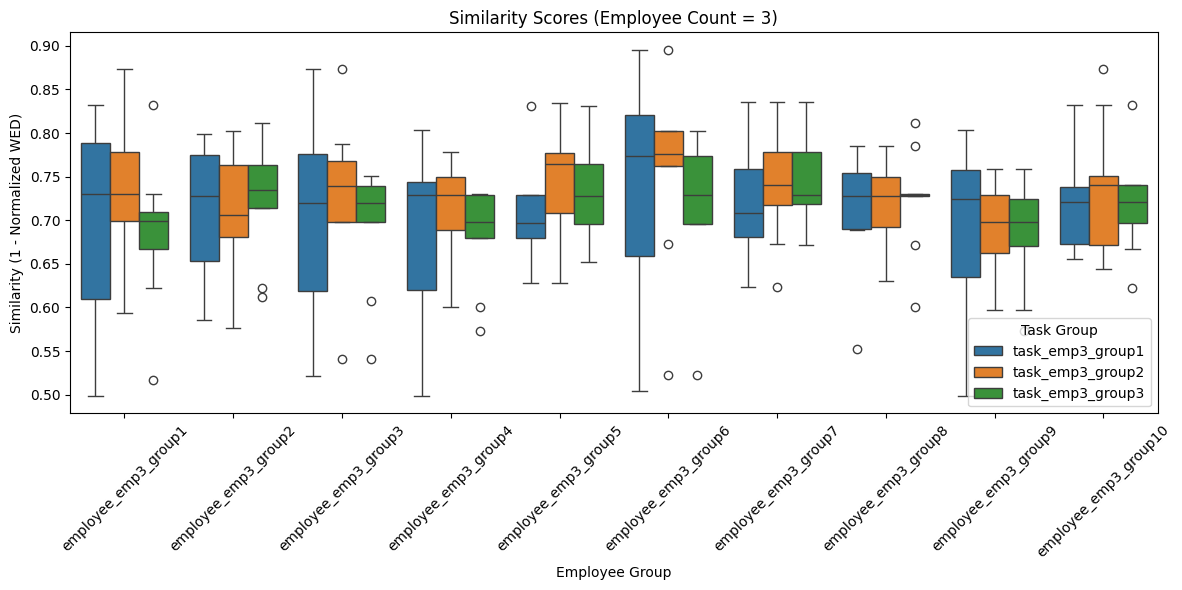

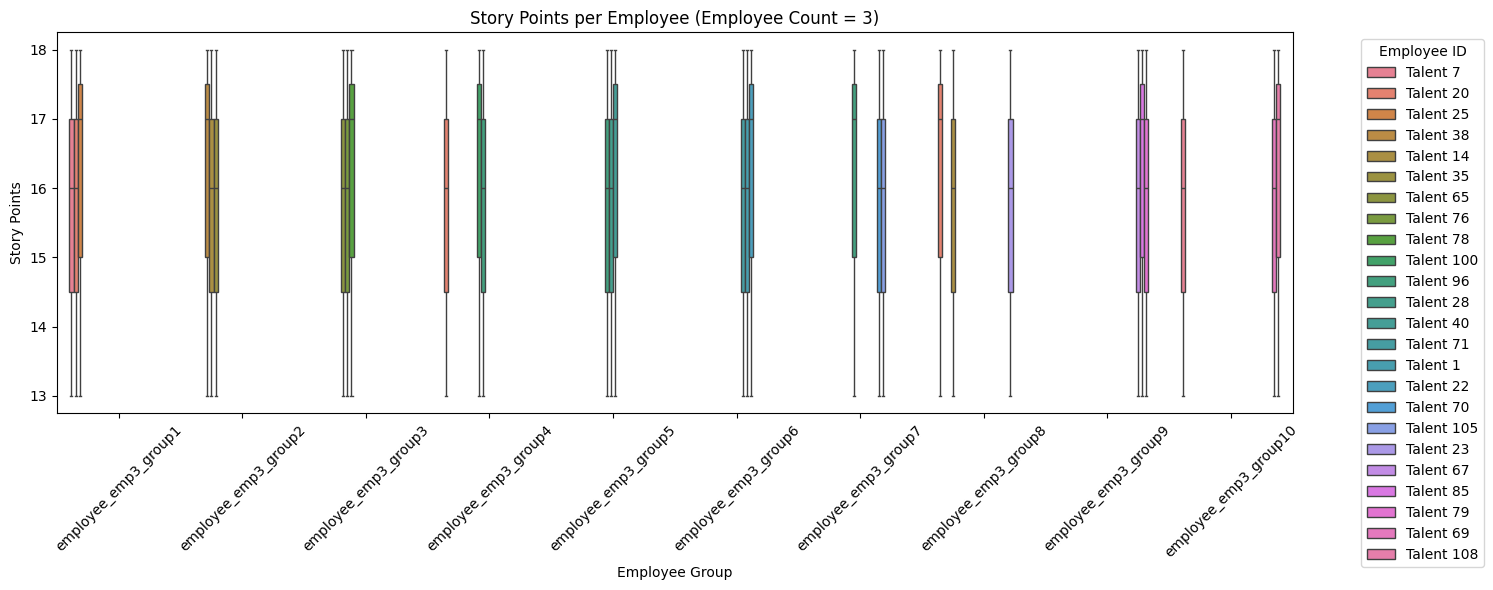

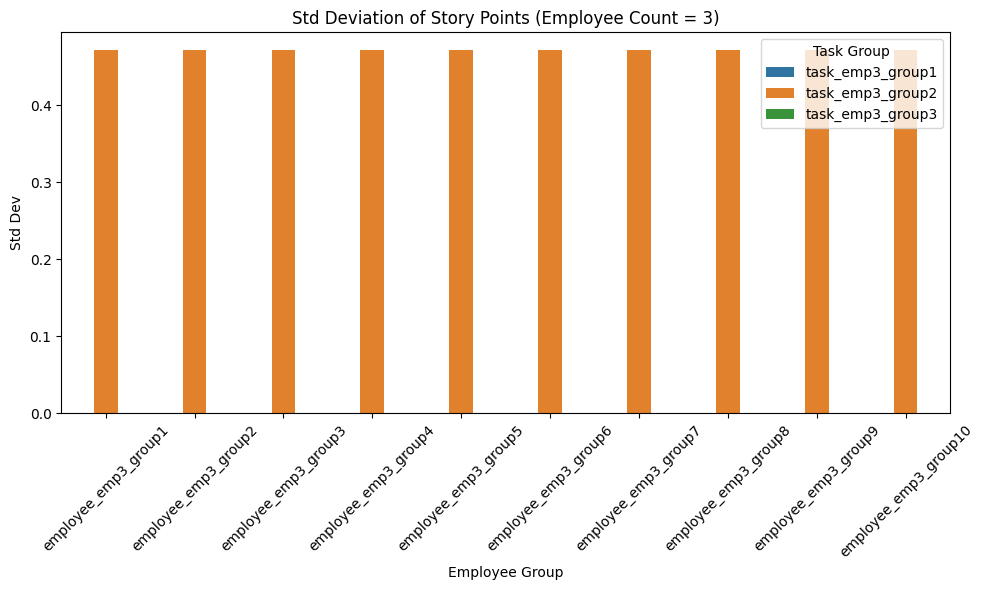

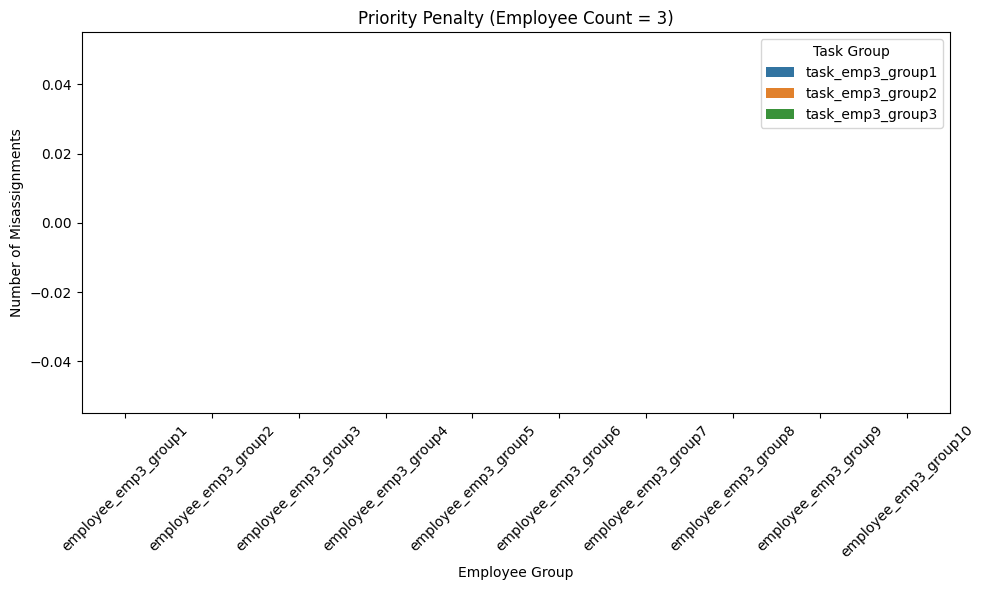

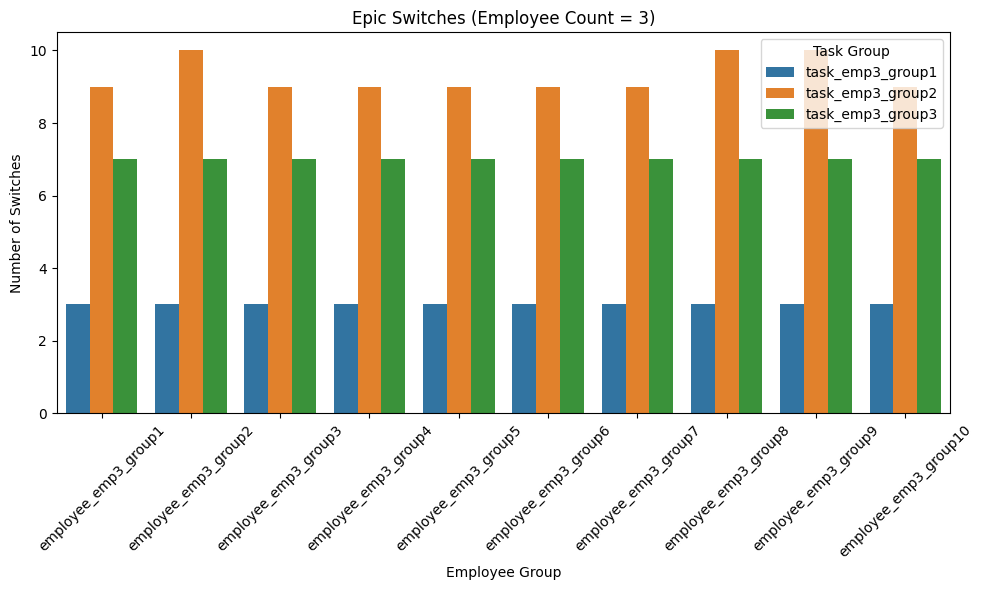

Optimized employee_emp4_group1 with task_emp3_group1 (emp_count=4)
Optimized employee_emp4_group1 with task_emp3_group2 (emp_count=4)
Optimized employee_emp4_group1 with task_emp3_group3 (emp_count=4)
Optimized employee_emp4_group2 with task_emp3_group1 (emp_count=4)
Optimized employee_emp4_group2 with task_emp3_group2 (emp_count=4)
Optimized employee_emp4_group2 with task_emp3_group3 (emp_count=4)
Optimized employee_emp4_group3 with task_emp3_group1 (emp_count=4)
Optimized employee_emp4_group3 with task_emp3_group2 (emp_count=4)
Optimized employee_emp4_group3 with task_emp3_group3 (emp_count=4)
Optimized employee_emp4_group4 with task_emp3_group1 (emp_count=4)
Optimized employee_emp4_group4 with task_emp3_group2 (emp_count=4)
Optimized employee_emp4_group4 with task_emp3_group3 (emp_count=4)
Optimized employee_emp4_group5 with task_emp3_group1 (emp_count=4)
Optimized employee_emp4_group5 with task_emp3_group2 (emp_count=4)
Optimized employee_emp4_group5 with task_emp3_group3 (emp_coun

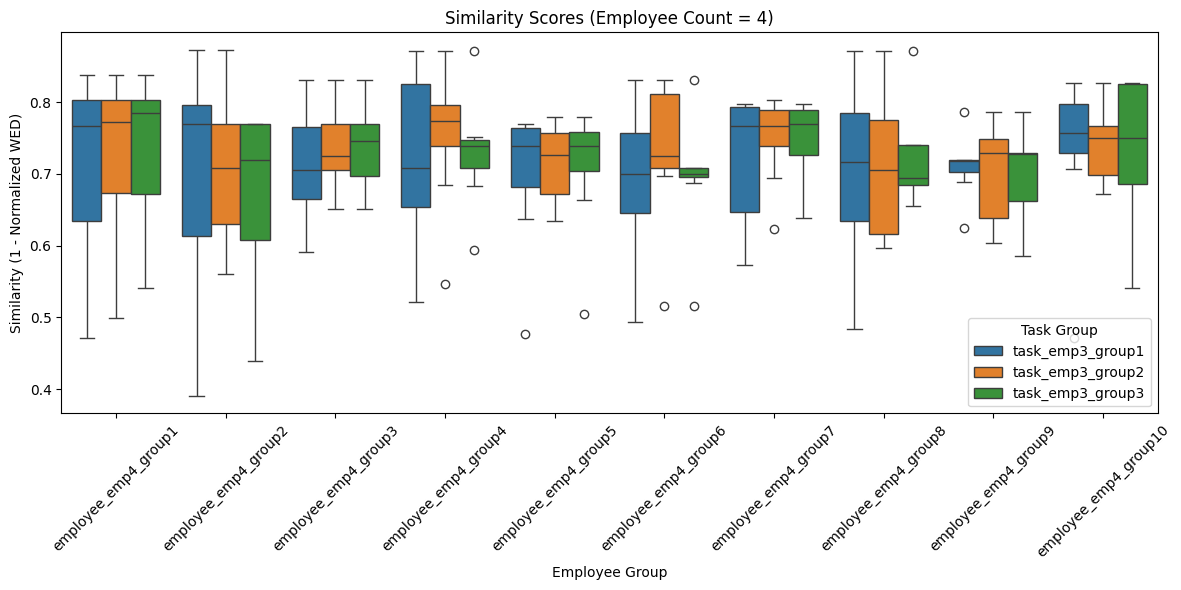

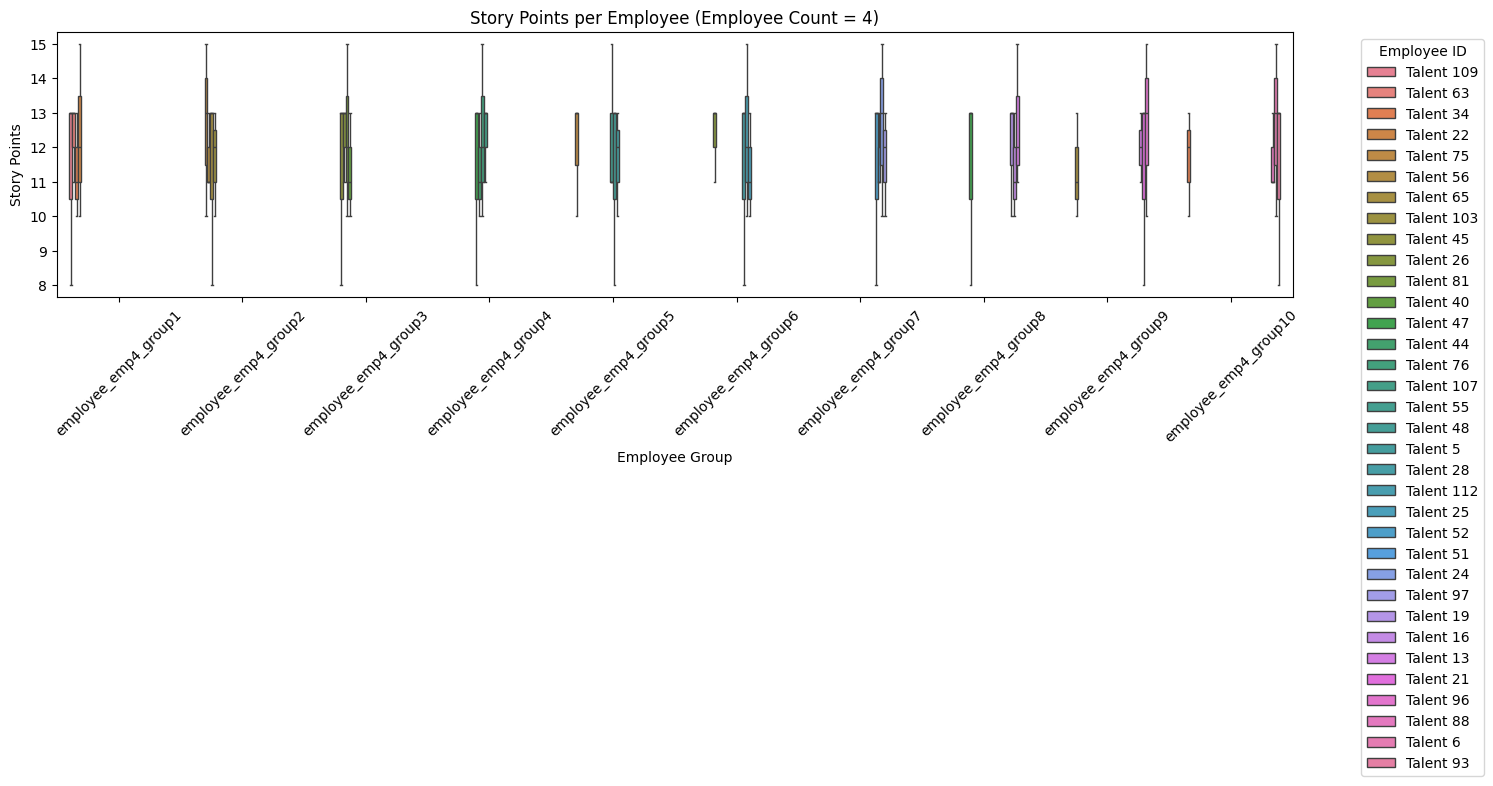

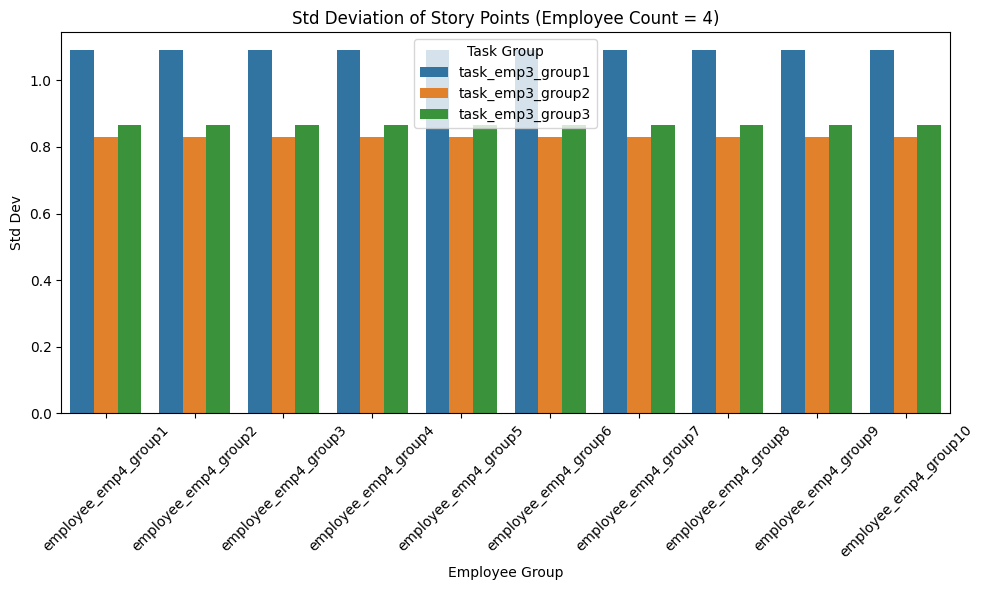

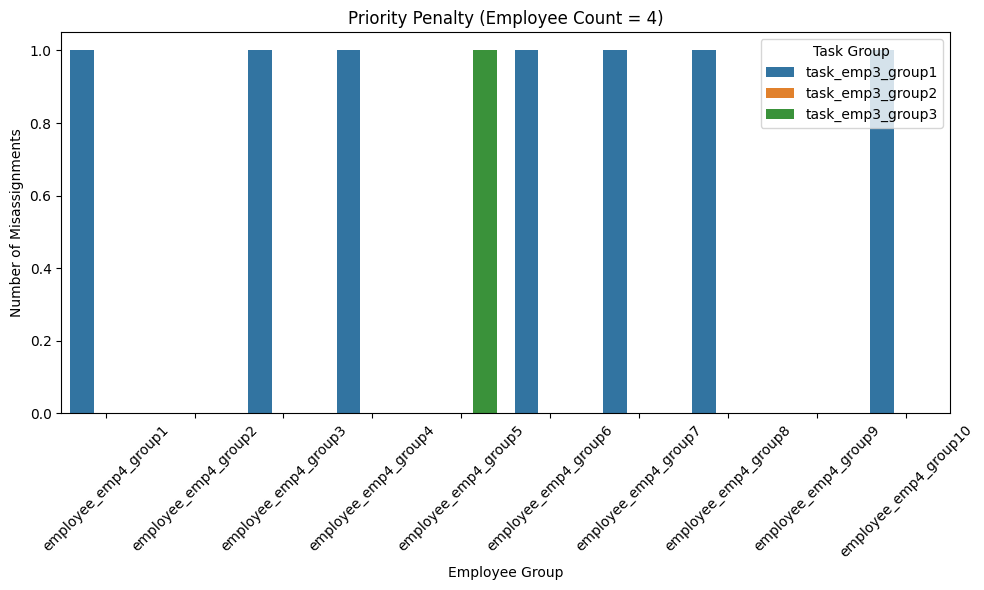

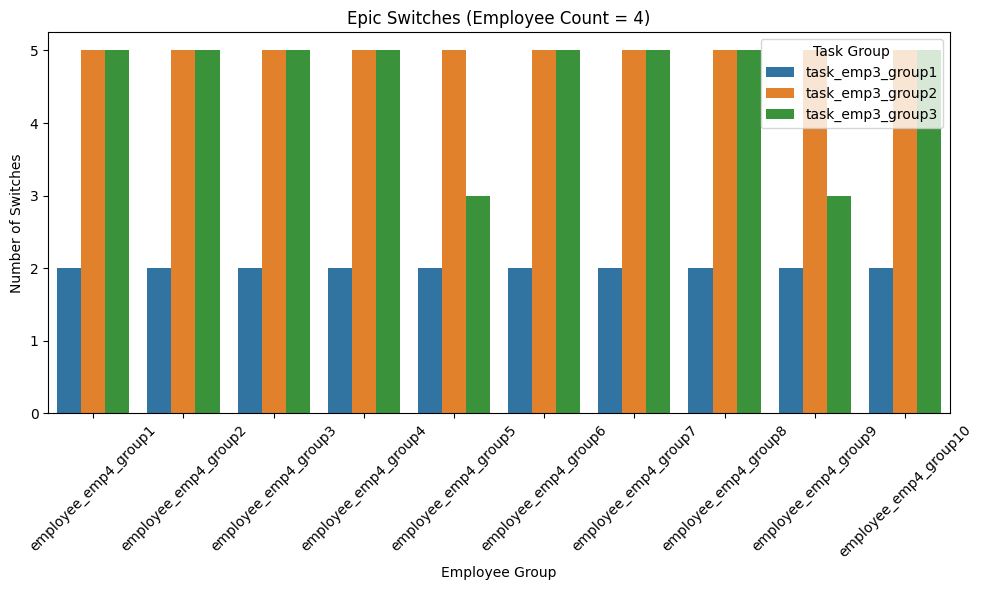

Optimized employee_emp5_group1 with task_emp3_group1 (emp_count=5)
Optimized employee_emp5_group1 with task_emp3_group2 (emp_count=5)
Optimized employee_emp5_group1 with task_emp3_group3 (emp_count=5)
Optimized employee_emp5_group2 with task_emp3_group1 (emp_count=5)
Optimized employee_emp5_group2 with task_emp3_group2 (emp_count=5)
Optimized employee_emp5_group2 with task_emp3_group3 (emp_count=5)
Optimized employee_emp5_group3 with task_emp3_group1 (emp_count=5)
Optimized employee_emp5_group3 with task_emp3_group2 (emp_count=5)
Optimized employee_emp5_group3 with task_emp3_group3 (emp_count=5)
Optimized employee_emp5_group4 with task_emp3_group1 (emp_count=5)
Optimized employee_emp5_group4 with task_emp3_group2 (emp_count=5)
Optimized employee_emp5_group4 with task_emp3_group3 (emp_count=5)
Optimized employee_emp5_group5 with task_emp3_group1 (emp_count=5)
Optimized employee_emp5_group5 with task_emp3_group2 (emp_count=5)
Optimized employee_emp5_group5 with task_emp3_group3 (emp_coun

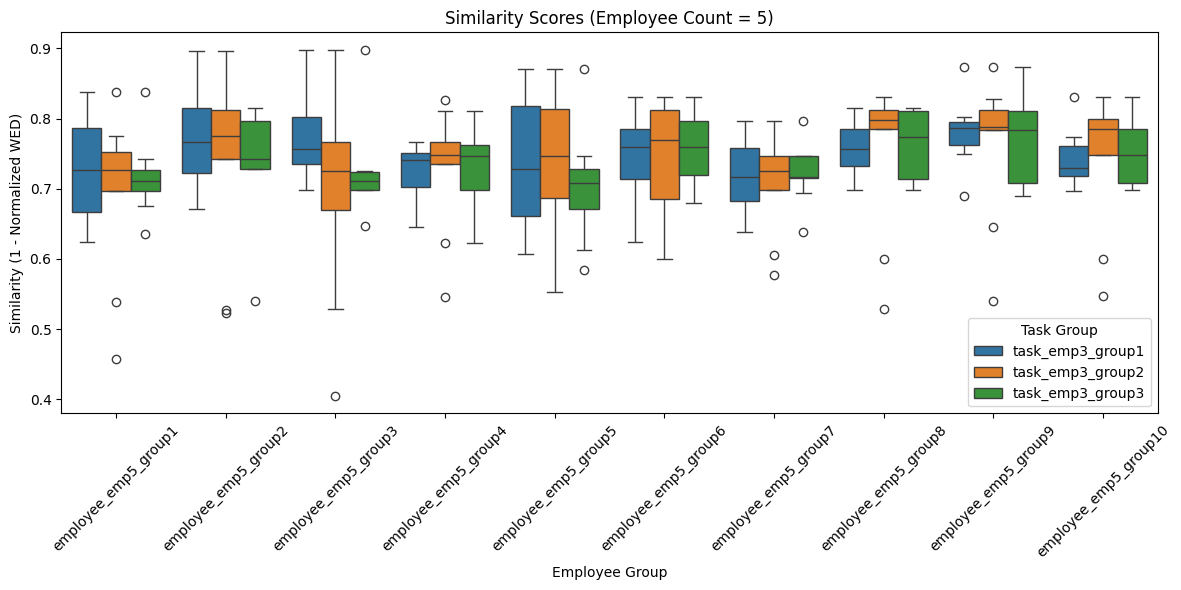

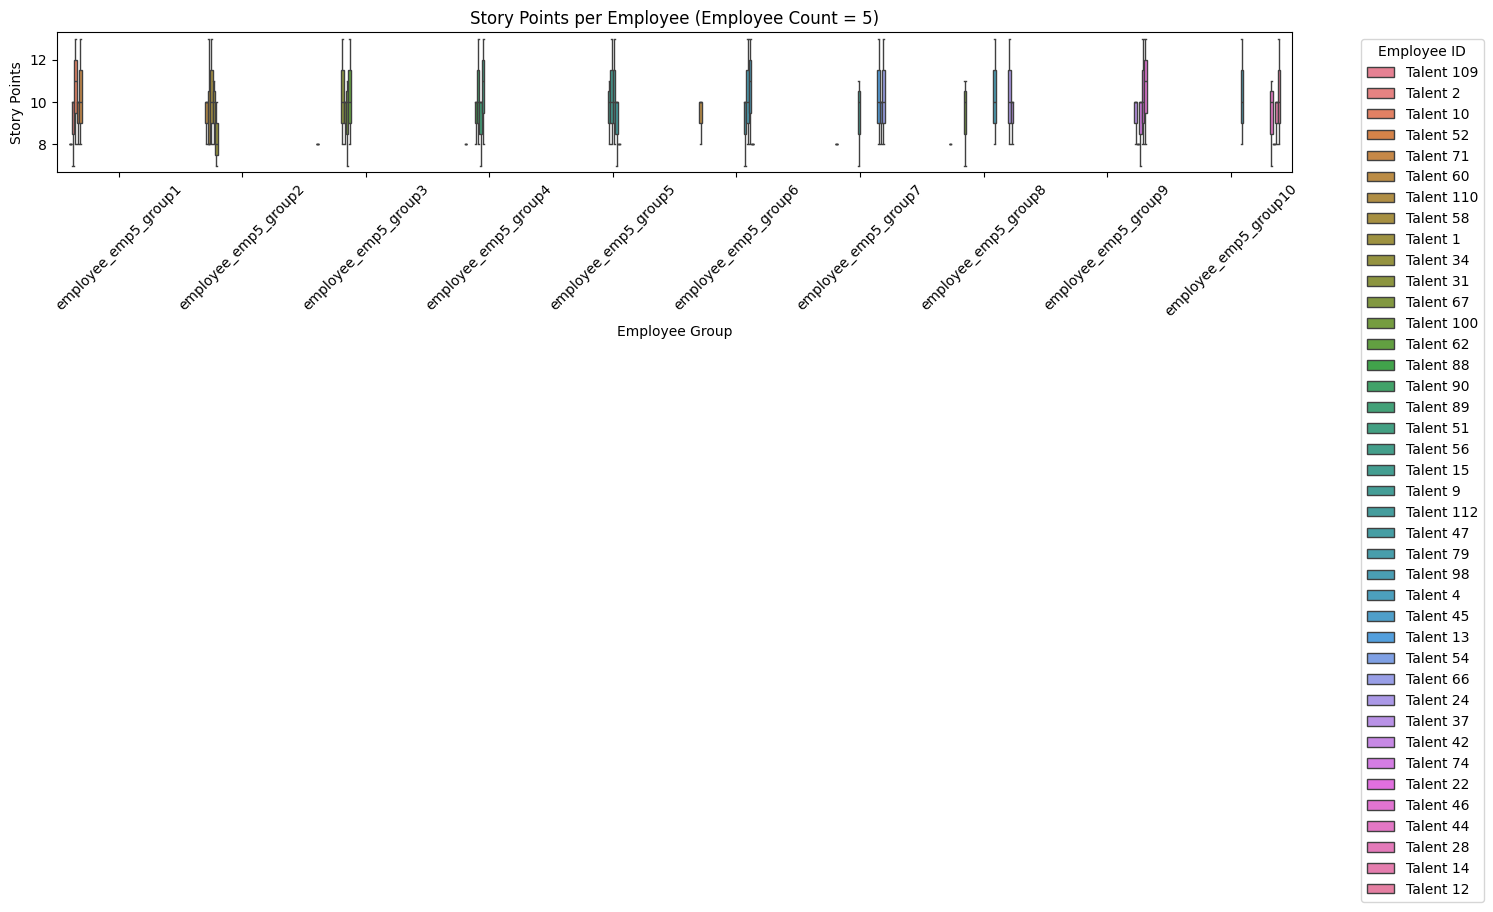

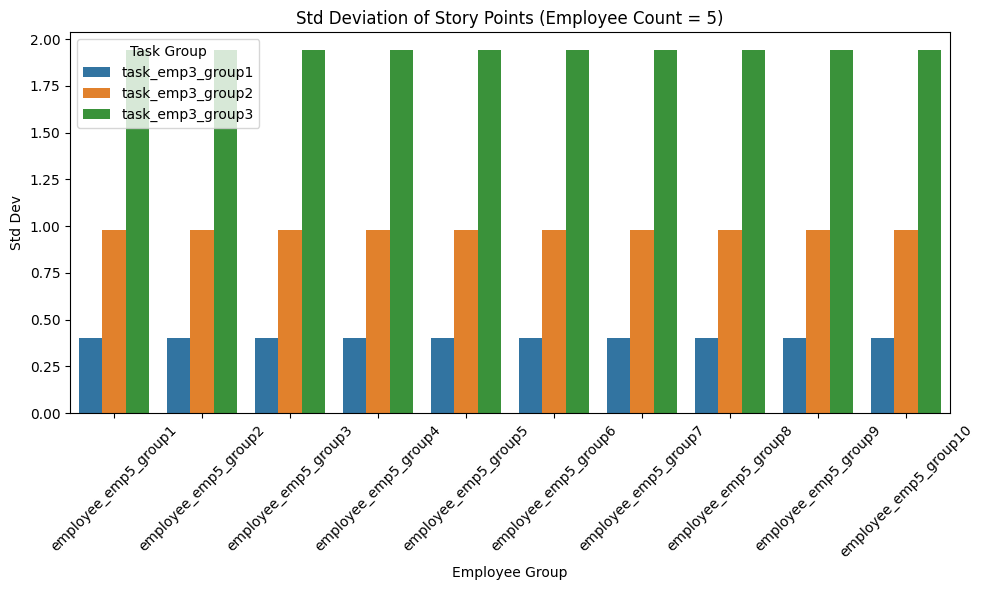

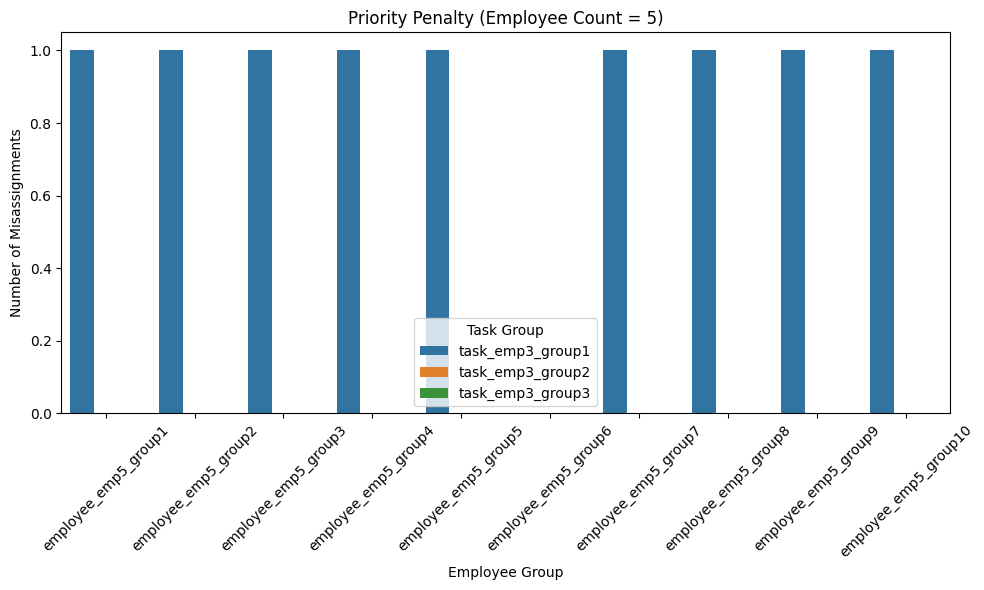

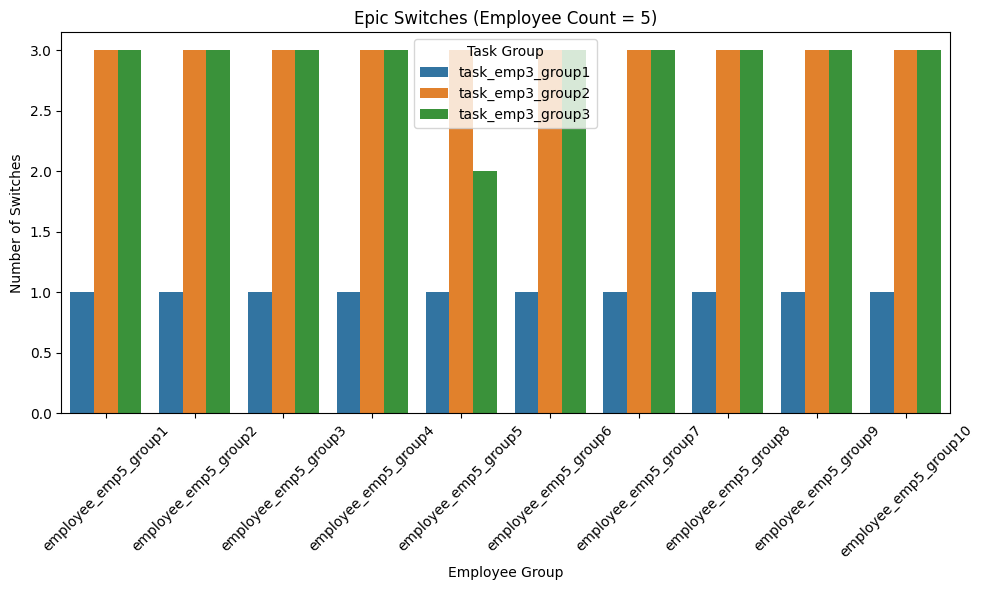

Optimized employee_emp6_group1 with task_emp3_group1 (emp_count=6)
Optimized employee_emp6_group1 with task_emp3_group2 (emp_count=6)
Optimized employee_emp6_group1 with task_emp3_group3 (emp_count=6)
Optimized employee_emp6_group2 with task_emp3_group1 (emp_count=6)
Optimized employee_emp6_group2 with task_emp3_group2 (emp_count=6)
Optimized employee_emp6_group2 with task_emp3_group3 (emp_count=6)
Optimized employee_emp6_group3 with task_emp3_group1 (emp_count=6)
Optimized employee_emp6_group3 with task_emp3_group2 (emp_count=6)
Optimized employee_emp6_group3 with task_emp3_group3 (emp_count=6)
Optimized employee_emp6_group4 with task_emp3_group1 (emp_count=6)
Optimized employee_emp6_group4 with task_emp3_group2 (emp_count=6)
Optimized employee_emp6_group4 with task_emp3_group3 (emp_count=6)
Optimized employee_emp6_group5 with task_emp3_group1 (emp_count=6)
Optimized employee_emp6_group5 with task_emp3_group2 (emp_count=6)
Optimized employee_emp6_group5 with task_emp3_group3 (emp_coun

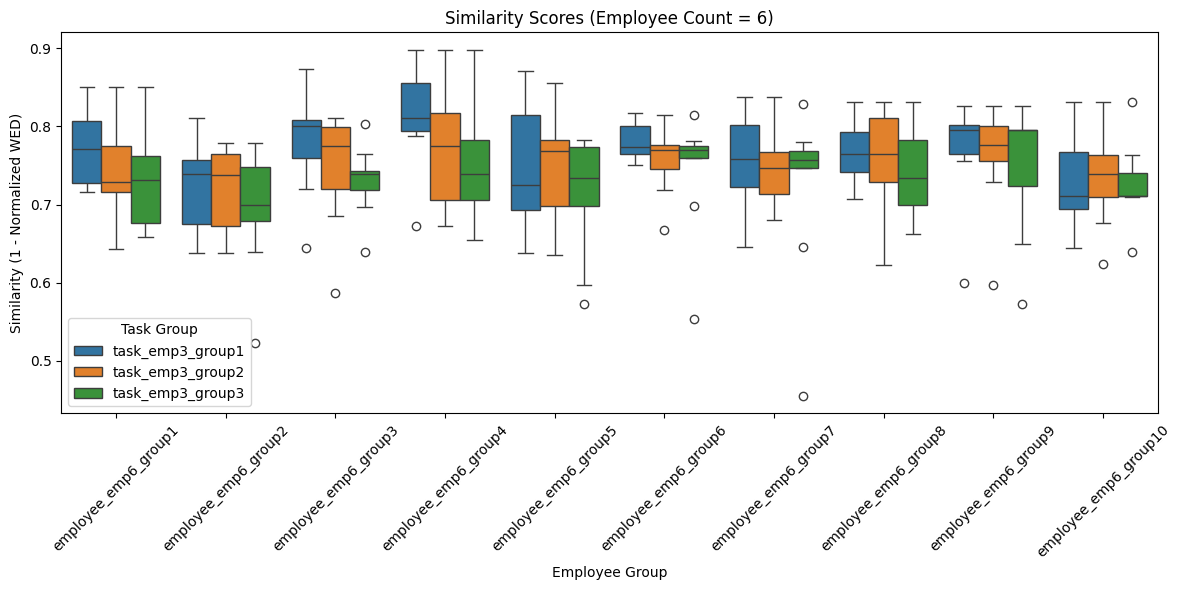

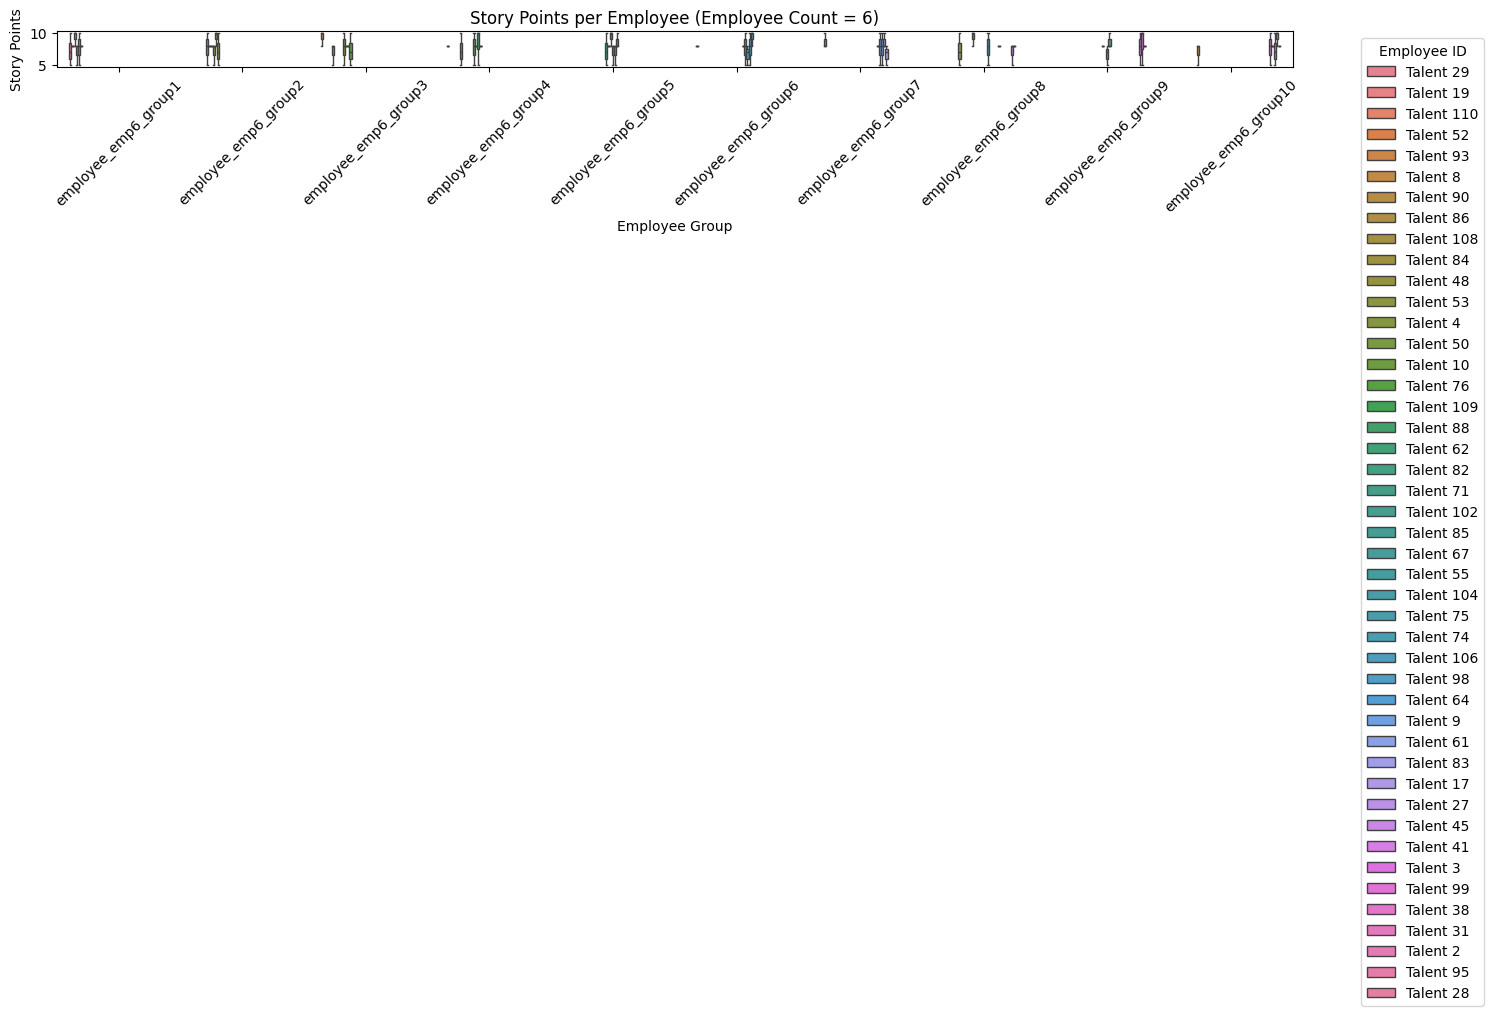

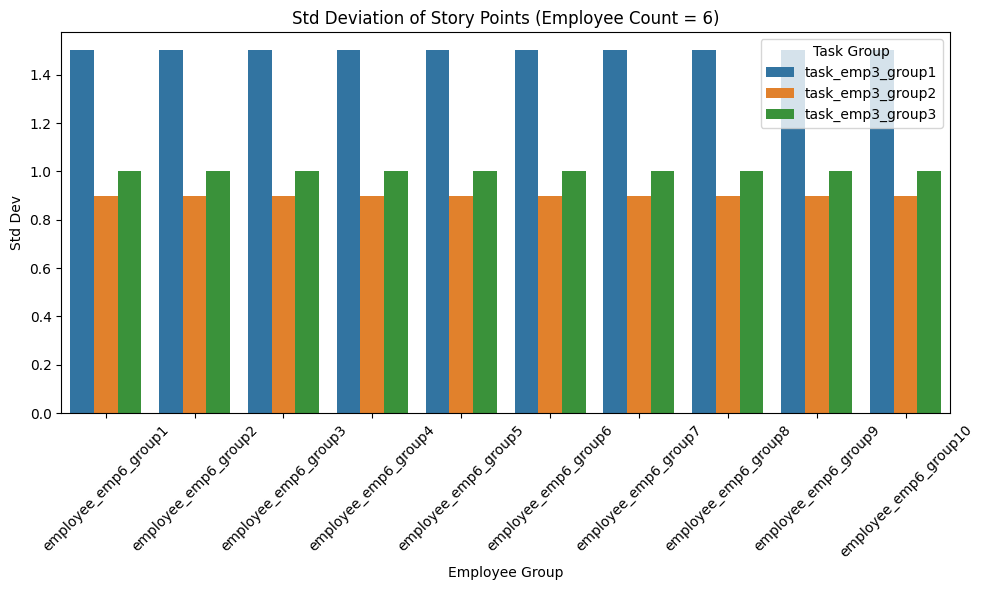

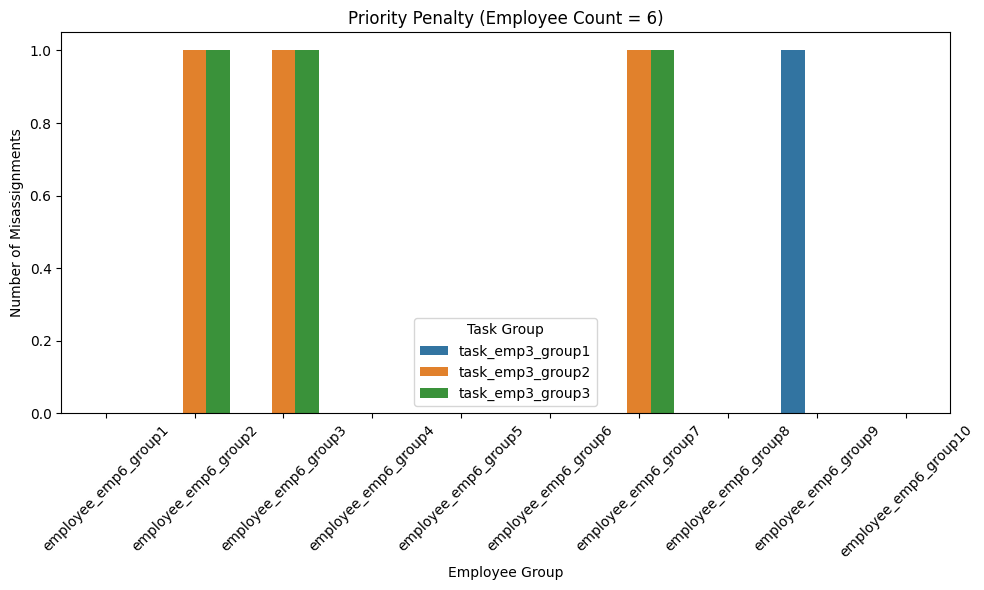

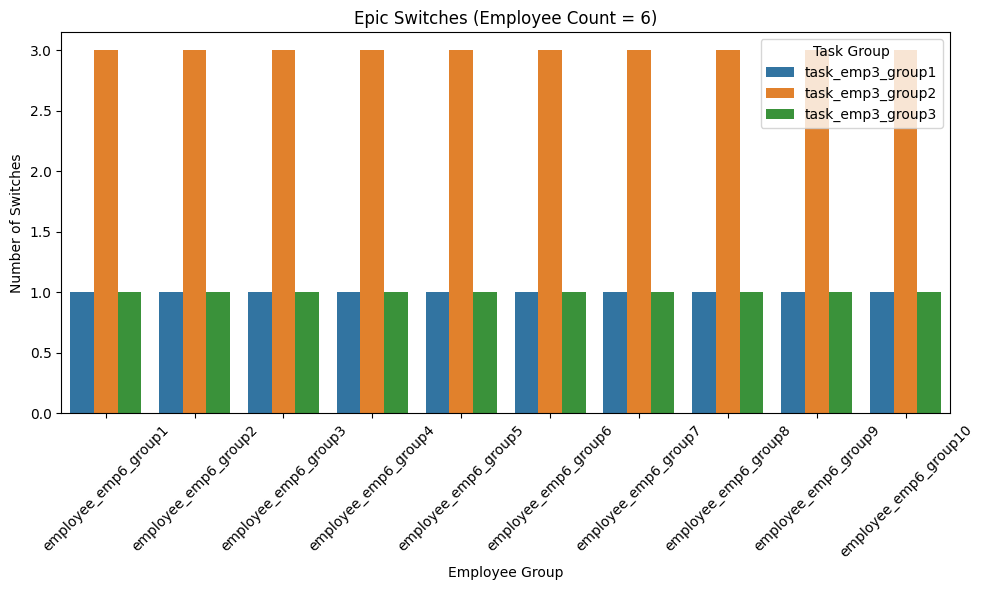

Optimized employee_emp7_group1 with task_emp3_group1 (emp_count=7)
Optimized employee_emp7_group1 with task_emp3_group2 (emp_count=7)
Optimized employee_emp7_group1 with task_emp3_group3 (emp_count=7)
Optimized employee_emp7_group2 with task_emp3_group1 (emp_count=7)
Optimized employee_emp7_group2 with task_emp3_group2 (emp_count=7)
Optimized employee_emp7_group2 with task_emp3_group3 (emp_count=7)
Optimized employee_emp7_group3 with task_emp3_group1 (emp_count=7)
Optimized employee_emp7_group3 with task_emp3_group2 (emp_count=7)
Optimized employee_emp7_group3 with task_emp3_group3 (emp_count=7)
Optimized employee_emp7_group4 with task_emp3_group1 (emp_count=7)
Optimized employee_emp7_group4 with task_emp3_group2 (emp_count=7)
Optimized employee_emp7_group4 with task_emp3_group3 (emp_count=7)
Optimized employee_emp7_group5 with task_emp3_group1 (emp_count=7)
Optimized employee_emp7_group5 with task_emp3_group2 (emp_count=7)
Optimized employee_emp7_group5 with task_emp3_group3 (emp_coun

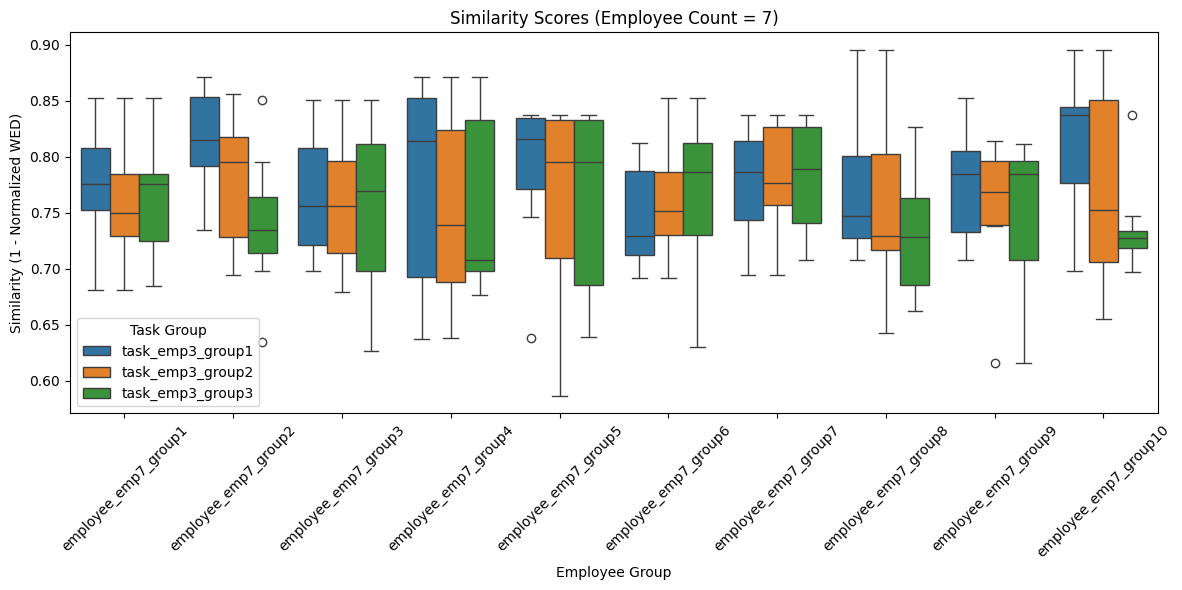

<ipython-input-8-c693a1c634ef>:130: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


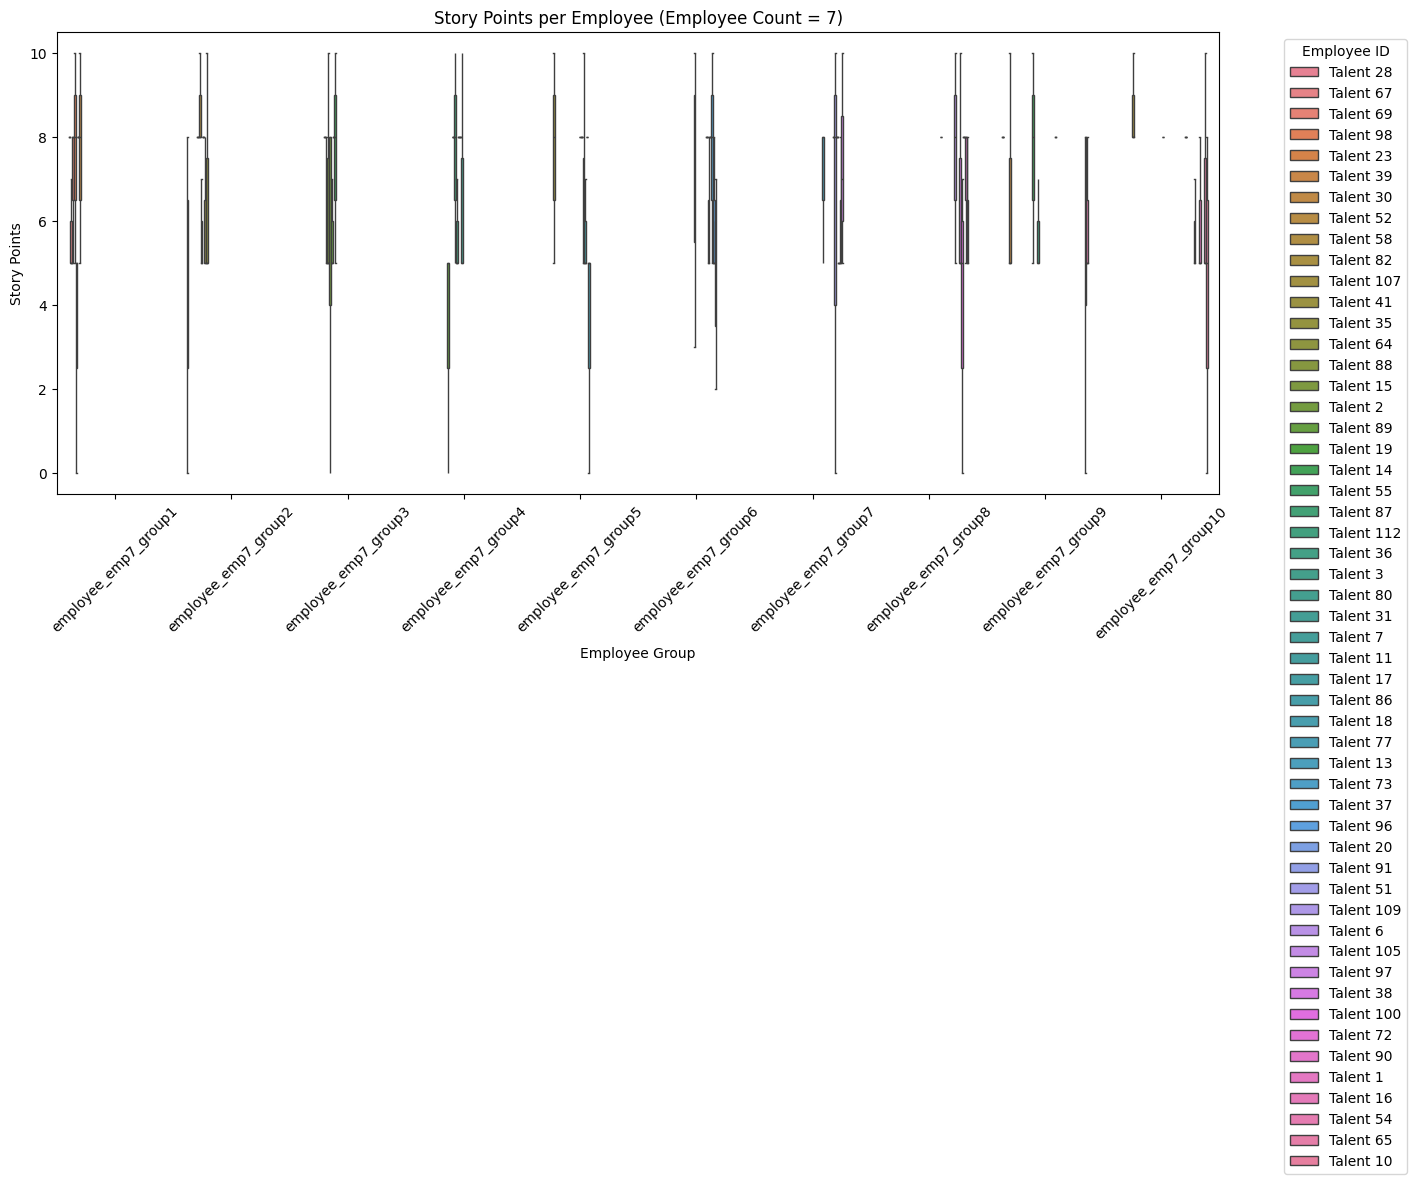

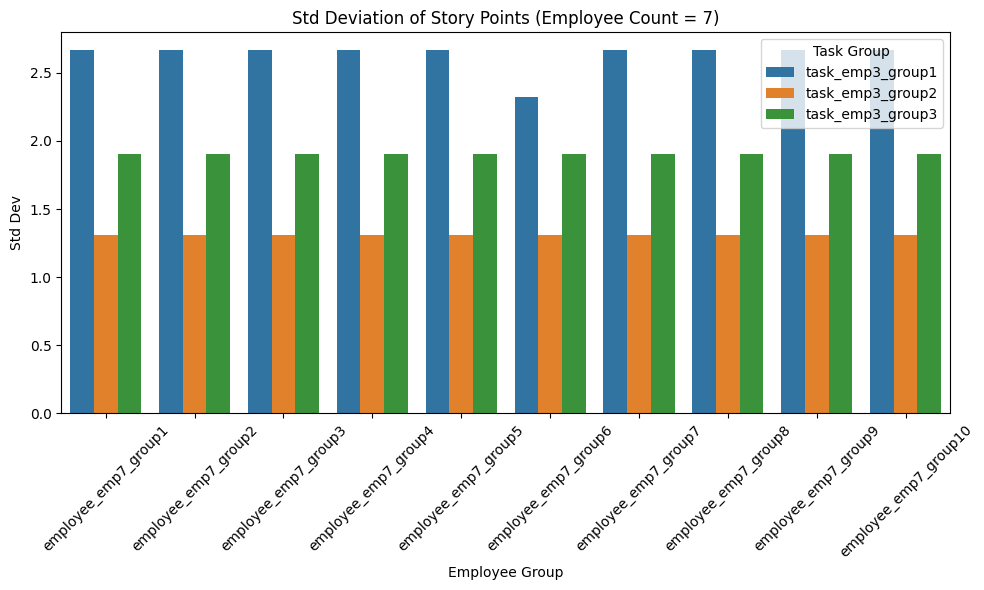

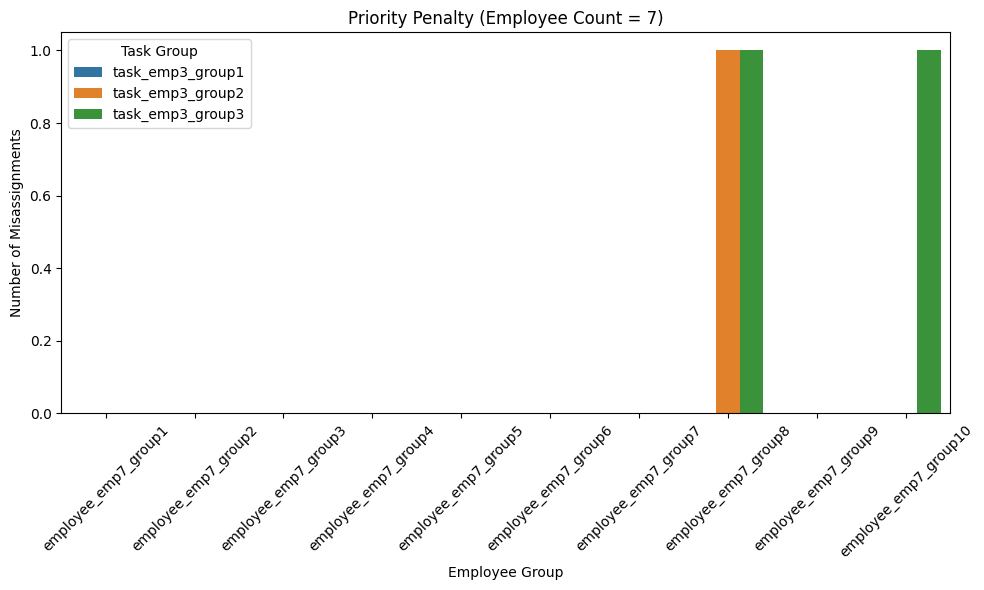

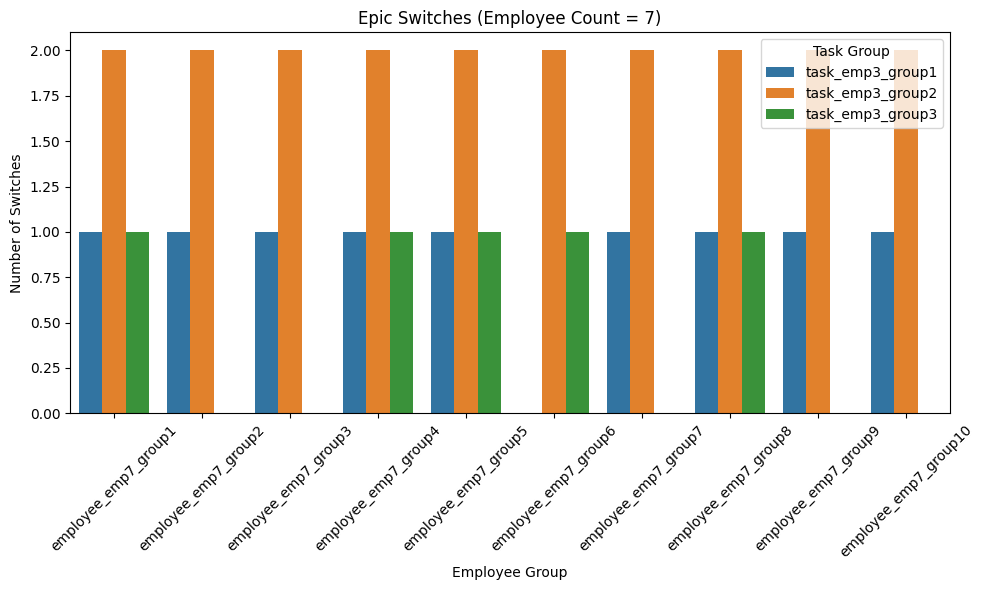

Optimized employee_emp8_group1 with task_emp3_group1 (emp_count=8)
Optimized employee_emp8_group1 with task_emp3_group2 (emp_count=8)
Optimized employee_emp8_group1 with task_emp3_group3 (emp_count=8)
Optimized employee_emp8_group2 with task_emp3_group1 (emp_count=8)
Optimized employee_emp8_group2 with task_emp3_group2 (emp_count=8)
Optimized employee_emp8_group2 with task_emp3_group3 (emp_count=8)
Optimized employee_emp8_group3 with task_emp3_group1 (emp_count=8)
Optimized employee_emp8_group3 with task_emp3_group2 (emp_count=8)
Optimized employee_emp8_group3 with task_emp3_group3 (emp_count=8)
Optimized employee_emp8_group4 with task_emp3_group1 (emp_count=8)
Optimized employee_emp8_group4 with task_emp3_group2 (emp_count=8)
Optimized employee_emp8_group4 with task_emp3_group3 (emp_count=8)
Optimized employee_emp8_group5 with task_emp3_group1 (emp_count=8)
Optimized employee_emp8_group5 with task_emp3_group2 (emp_count=8)
Optimized employee_emp8_group5 with task_emp3_group3 (emp_coun

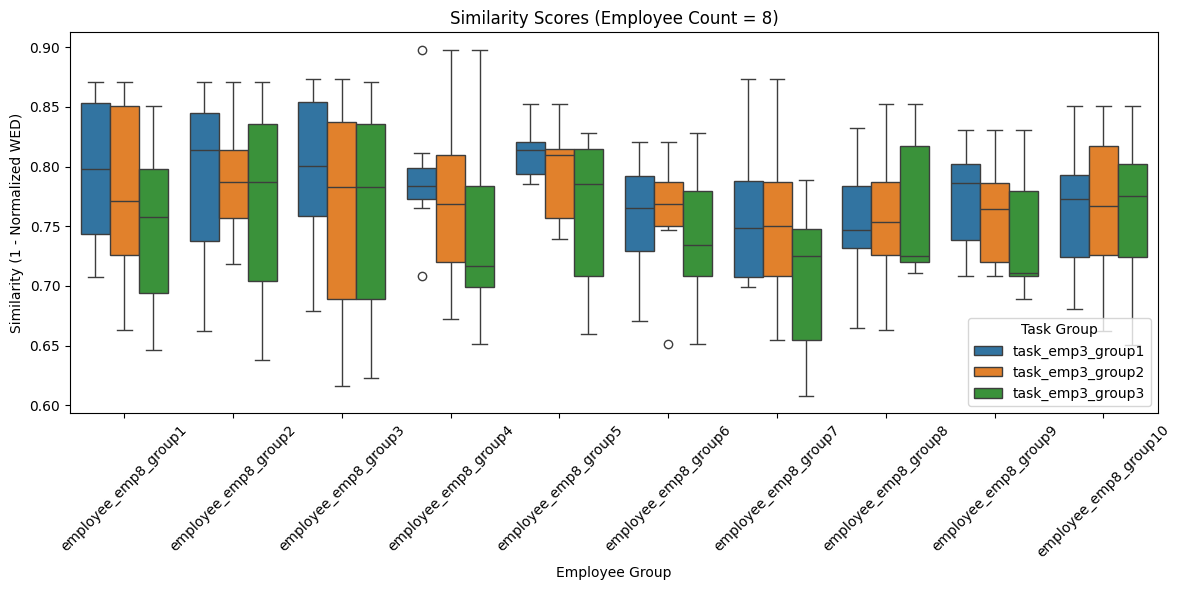

<ipython-input-8-c693a1c634ef>:130: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


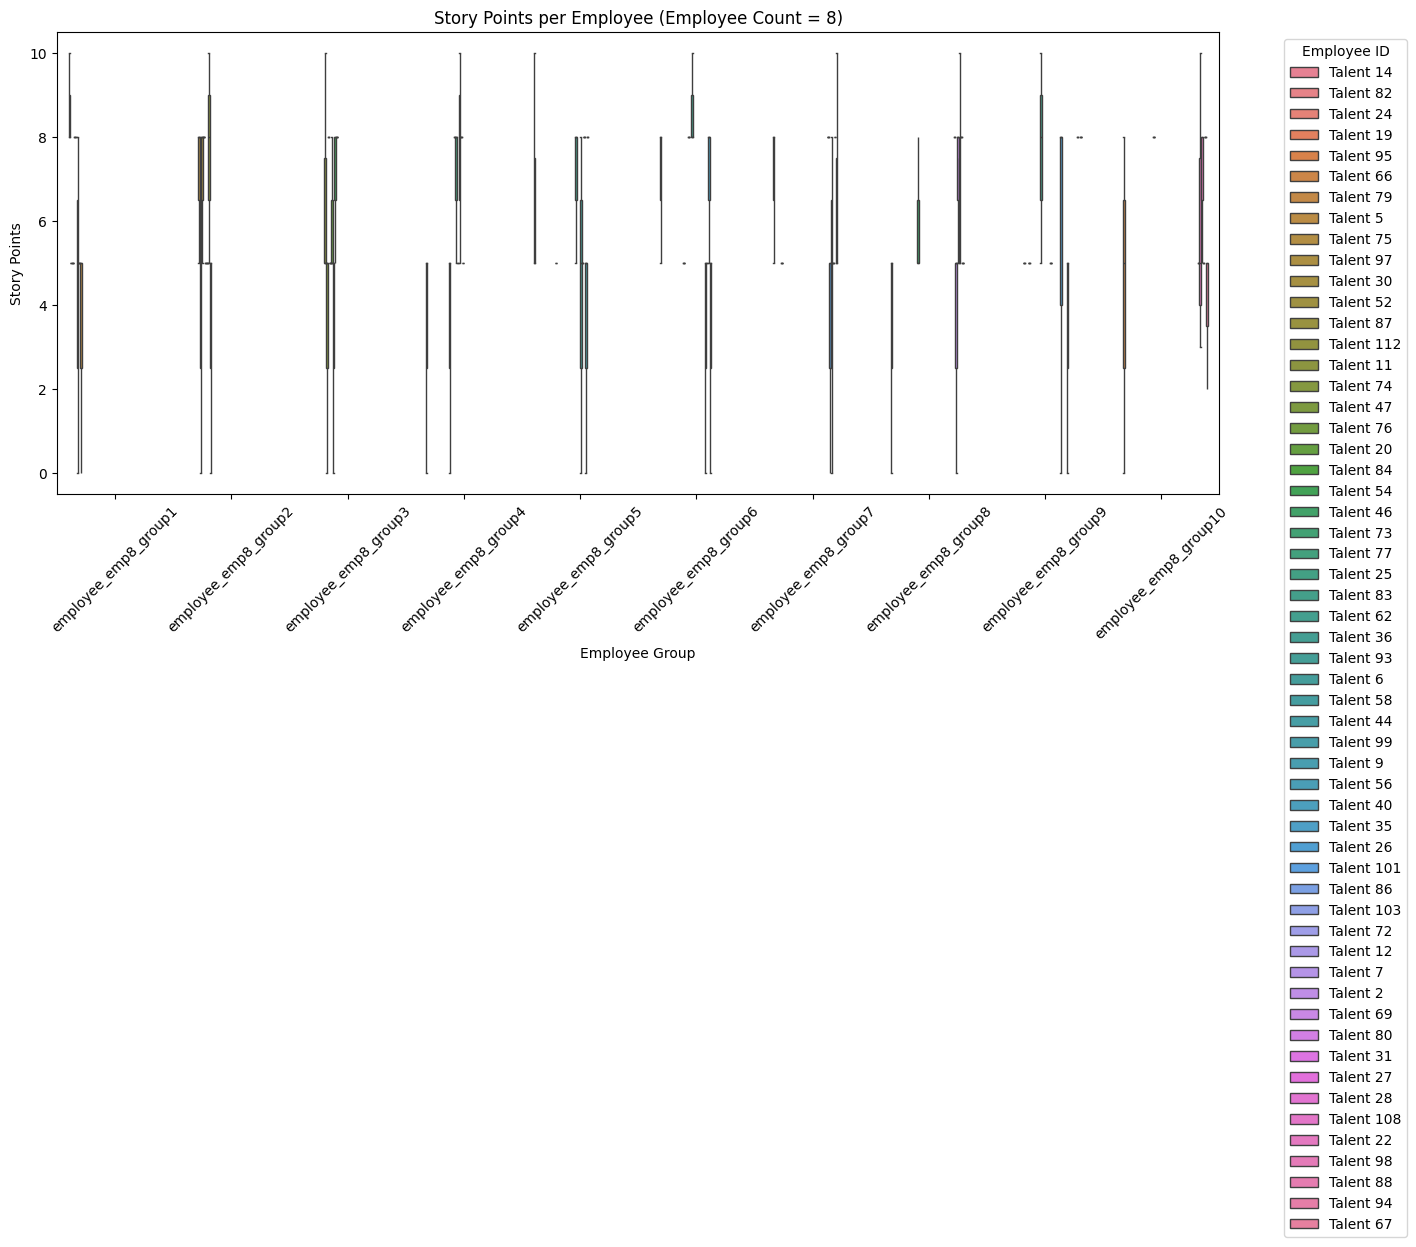

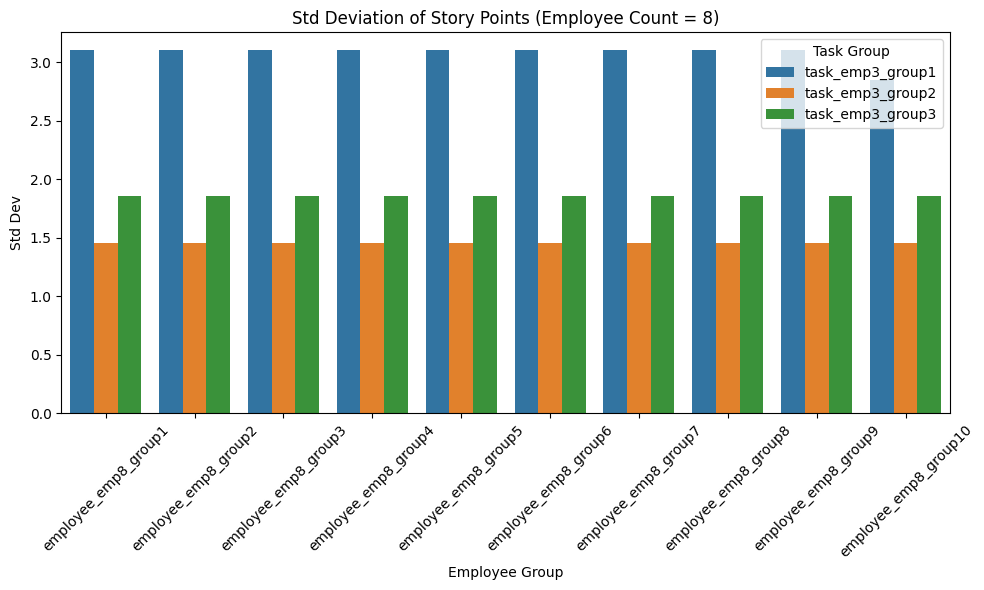

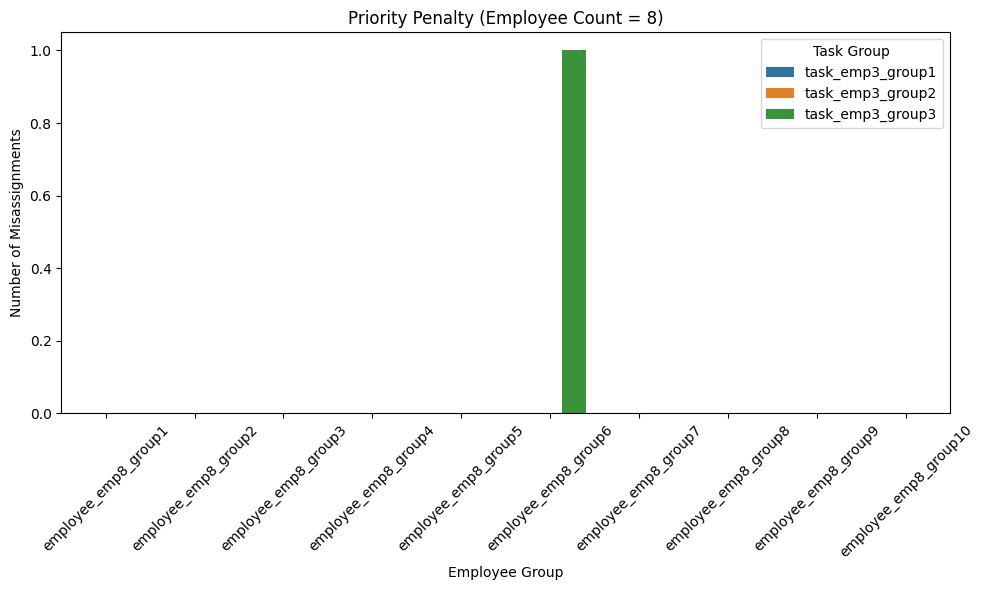

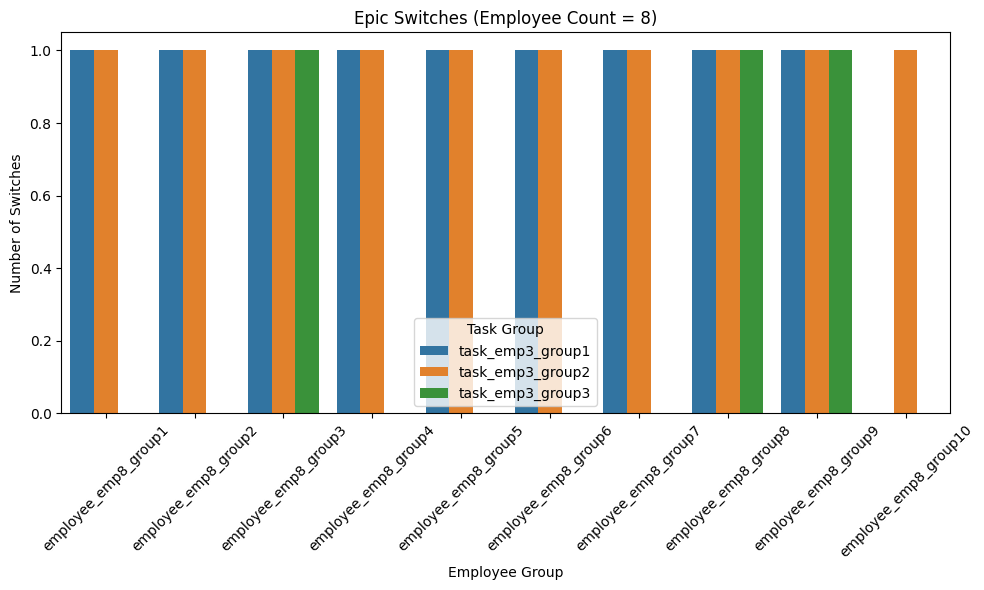

Optimized employee_emp9_group1 with task_emp3_group1 (emp_count=9)
Optimized employee_emp9_group1 with task_emp3_group2 (emp_count=9)
Optimized employee_emp9_group1 with task_emp3_group3 (emp_count=9)
Optimized employee_emp9_group2 with task_emp3_group1 (emp_count=9)
Optimized employee_emp9_group2 with task_emp3_group2 (emp_count=9)
Optimized employee_emp9_group2 with task_emp3_group3 (emp_count=9)
Optimized employee_emp9_group3 with task_emp3_group1 (emp_count=9)
Optimized employee_emp9_group3 with task_emp3_group2 (emp_count=9)
Optimized employee_emp9_group3 with task_emp3_group3 (emp_count=9)
Optimized employee_emp9_group4 with task_emp3_group1 (emp_count=9)
Optimized employee_emp9_group4 with task_emp3_group2 (emp_count=9)
Optimized employee_emp9_group4 with task_emp3_group3 (emp_count=9)
Optimized employee_emp9_group5 with task_emp3_group1 (emp_count=9)
Optimized employee_emp9_group5 with task_emp3_group2 (emp_count=9)
Optimized employee_emp9_group5 with task_emp3_group3 (emp_coun

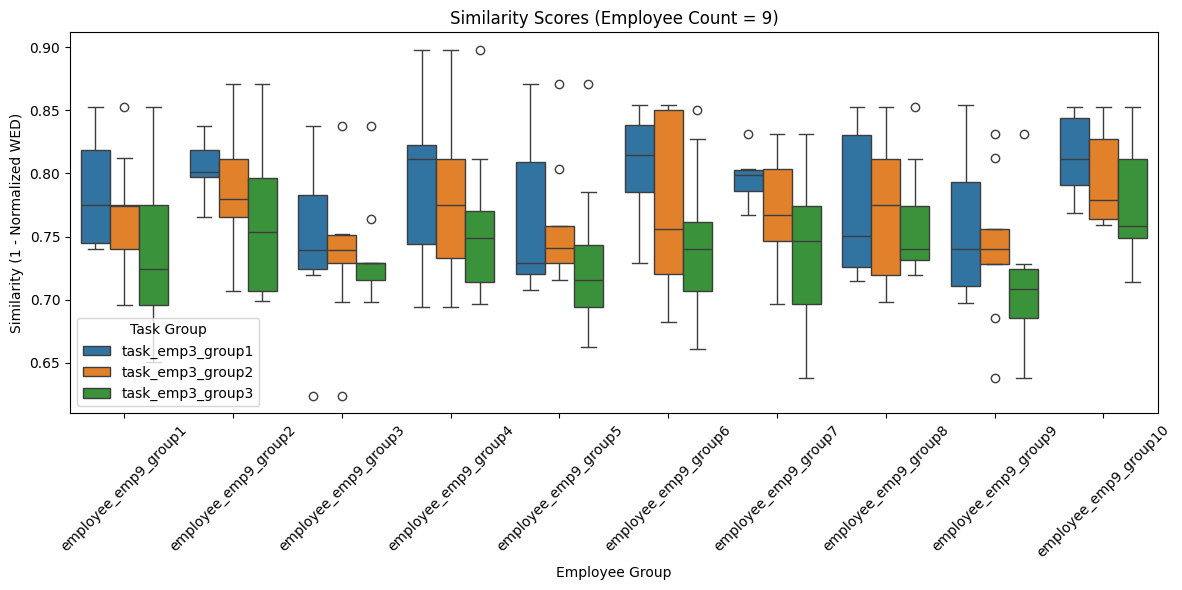

<ipython-input-8-c693a1c634ef>:130: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


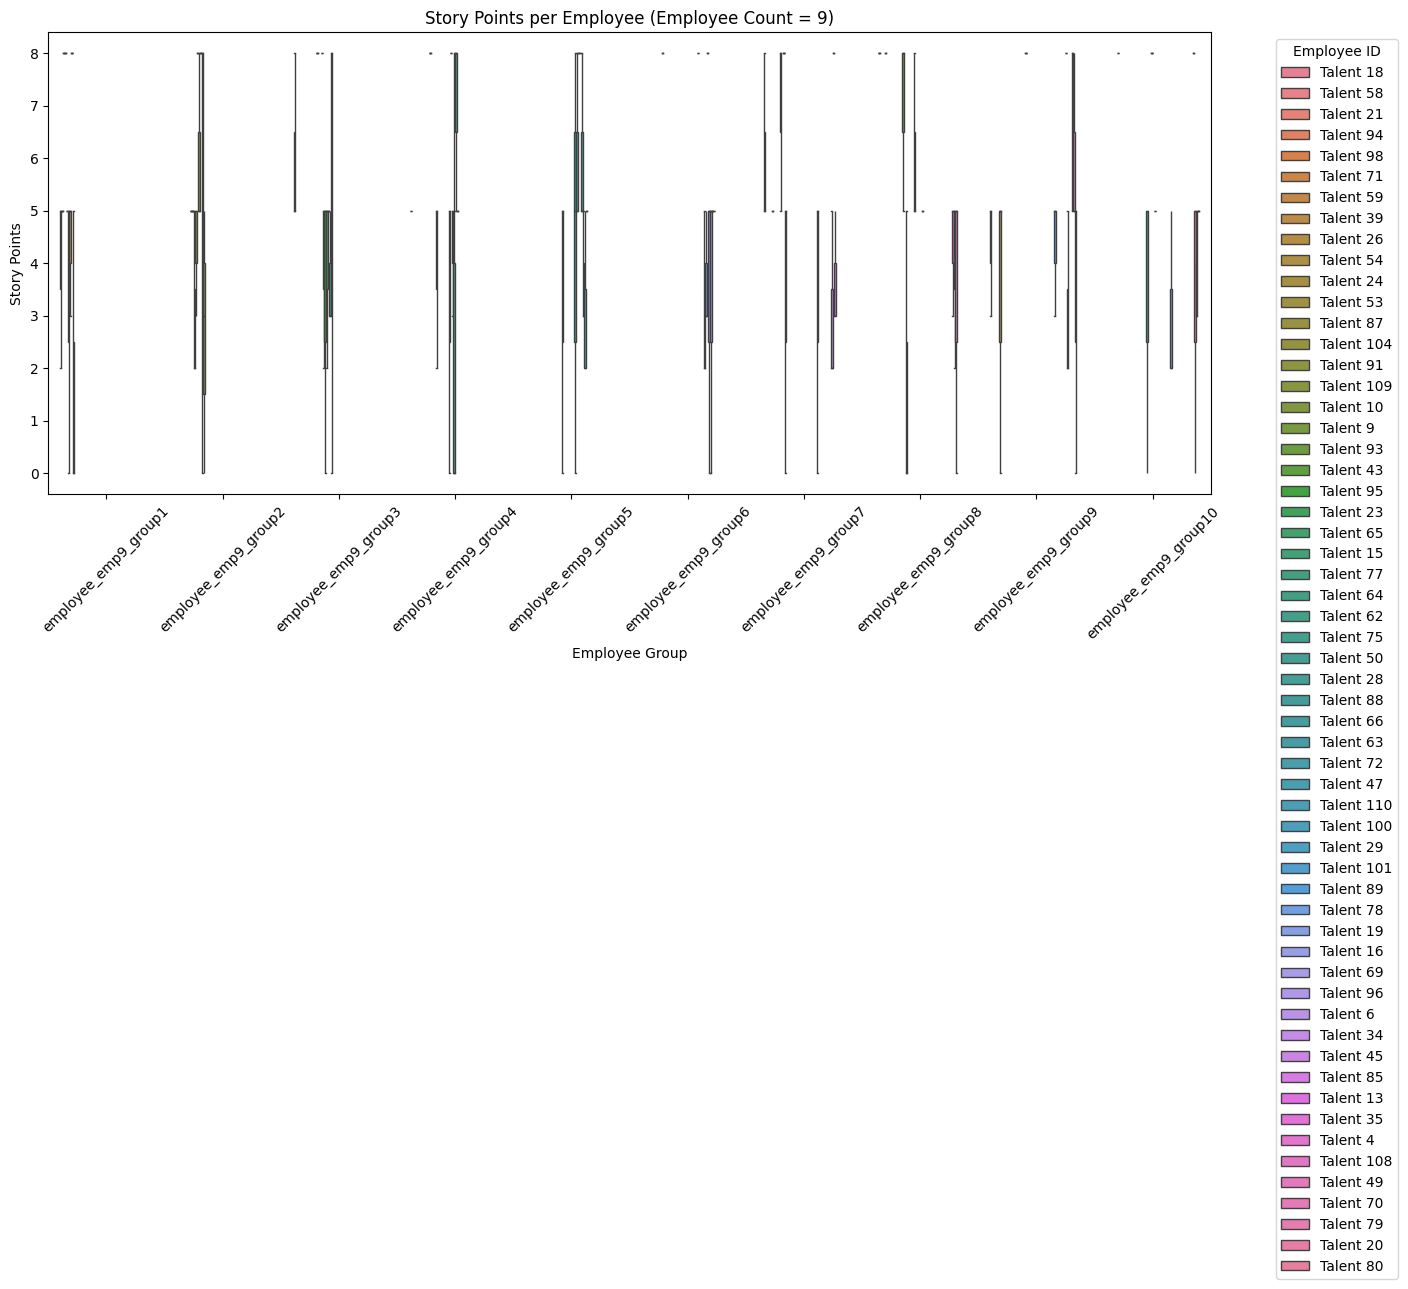

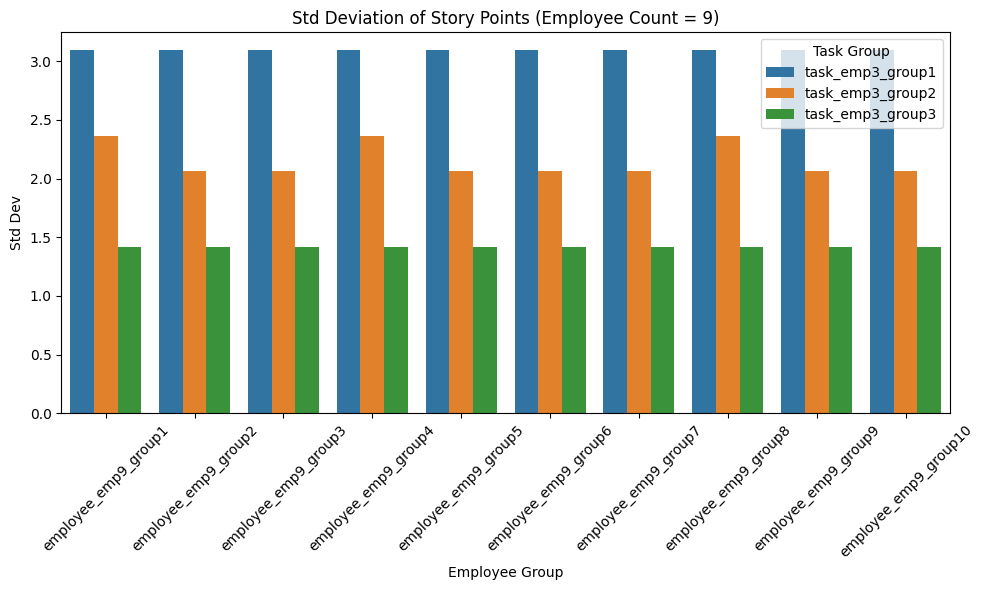

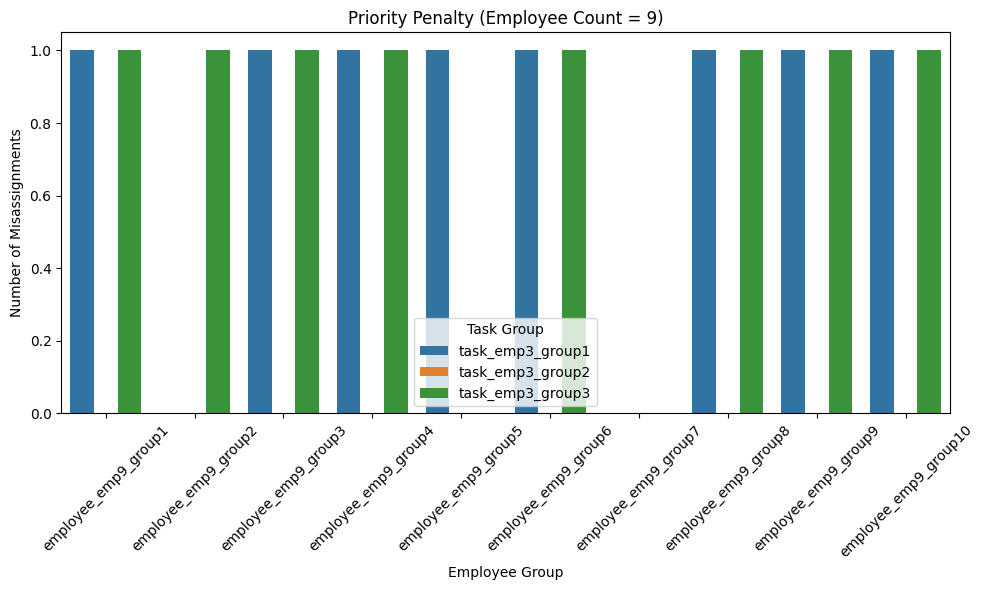

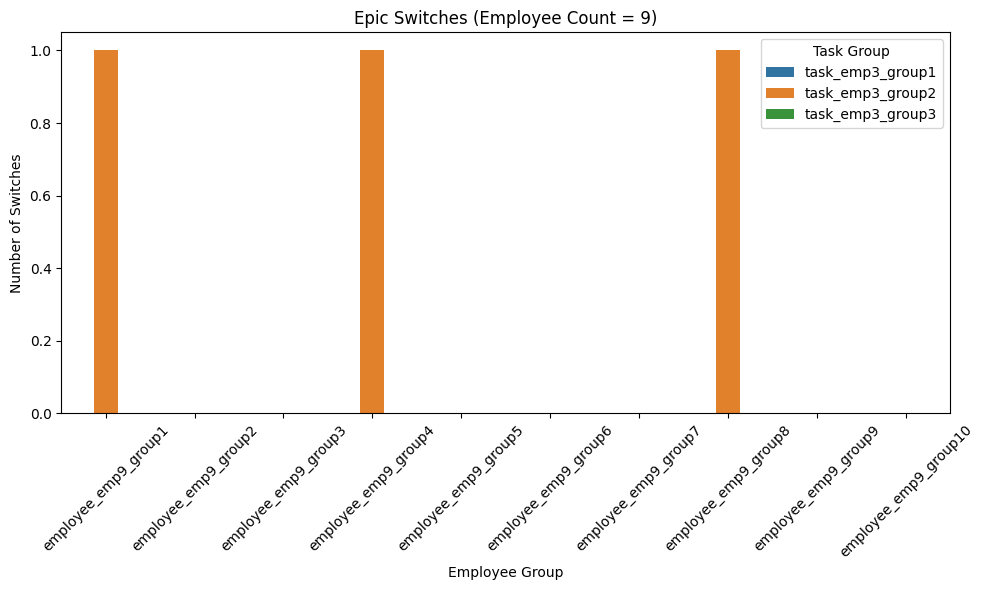

All 210 runs completed!


In [8]:
# Define WED function (α = 0.1)
def calculate_weighted_euclidean_distance(employee_skills, task_skills, alpha=0.1):
    employee_skills = np.array(employee_skills)
    task_skills = np.array(task_skills)
    diff = employee_skills - task_skills
    weights = 1 / (1 + alpha * np.maximum(0, diff))
    wed = np.sqrt(np.sum(weights * (diff ** 2)))
    max_wed = np.sqrt(7 * 25)  # 13.229
    return 1 - (wed / max_wed)

# Task groups (assuming same for all employee counts)
task_groups = [f"task_emp3_group{i}" for i in range(1, 4)]

# Loop over employee counts (3 to 9)
for emp_count in range(3, 10):
    # Employee groups for this count
    employee_groups = [f"employee_emp{emp_count}_group{i}" for i in range(1, 11)]
    results = []

    # MOO for 30 runs
    for emp_group in employee_groups:
        emp_df = pd.read_csv(f"{employee_dir}{emp_group}.csv")
        E = emp_df['employee_id'].tolist()  # emp_count employees
        emp_skills = emp_df[common_skills].values

        for task_group in task_groups:
            task_df = pd.read_csv(f"{task_dir}{task_group}.csv")
            T = task_df.index.tolist()
            task_skills = task_df[common_skills].values
            sp = task_df['story_points'].values
            priority = task_df['priority'].map({'high': 1, 'medium': 0.5, 'low': 0}).values
            epic = task_df['epic'].values

            # Precompute similarity
            similarity = {}
            best_emp = {}
            for j in T:
                max_similarity = -1
                for i, e_id in enumerate(E):
                    sim = calculate_weighted_euclidean_distance(emp_skills[i], task_skills[j])
                    similarity[(e_id, j)] = sim
                    if sim > max_similarity:
                        max_similarity = sim
                        best_emp[j] = e_id

            # Gurobi model
            model = gp.Model(f"MOO_{emp_group}_{task_group}")
            model.setParam('OutputFlag', 0)

            # Variables
            x = model.addVars([(e_id, j) for e_id in E for j in T], vtype=GRB.BINARY, name="x")
            d_plus = model.addVars(E, vtype=GRB.CONTINUOUS, name="d_plus")
            d_minus = model.addVars(E, vtype=GRB.CONTINUOUS, name="d_minus")
            y = model.addVars([(e_id, j1, j2) for e_id in E for j1 in T for j2 in T if j1 < j2],
                              vtype=GRB.BINARY, name="y")

            # Constraints
            for j in T:
                model.addConstr(gp.quicksum(x[e_id, j] for e_id in E) == 1)
            for e_id in E:
                model.addConstr(gp.quicksum(x[e_id, j] * sp[j] for j in T) <= 20)
            SP = {e_id: gp.quicksum(x[e_id, j] * sp[j] for j in T) for e_id in E}
            mu = gp.quicksum(SP[e_id] for e_id in E) / len(E)
            for e_id in E:
                model.addConstr(SP[e_id] - mu == d_plus[e_id] - d_minus[e_id])
            for e_id in E:
                for j1 in T:
                    for j2 in T:
                        if j1 < j2 and epic[j1] != epic[j2]:
                            model.addConstr(y[e_id, j1, j2] >= x[e_id, j1] + x[e_id, j2] - 1)
                            model.addConstr(y[e_id, j1, j2] <= x[e_id, j1])
                            model.addConstr(y[e_id, j1, j2] <= x[e_id, j2])

            # Objectives
            Z1 = gp.quicksum(x[e_id, j] * (1 - similarity[(e_id, j)]) for e_id in E for j in T)
            Z2 = gp.quicksum(d_plus[e_id] + d_minus[e_id] for e_id in E)
            Z3 = gp.quicksum(x[e_id, j] for j in T if priority[j] == 1 for e_id in E if e_id != best_emp[j])
            Z4 = gp.quicksum(y[e_id, j1, j2] for e_id in E for j1 in T for j2 in T if j1 < j2 and epic[j1] != epic[j2])

            # Weighted objective
            w = [0.5, 0.3, 0.15, 0.05]
            model.setObjective(w[0] * Z1 + w[1] * Z2 + w[2] * Z3 + w[3] * Z4, GRB.MINIMIZE)

            # Optimize
            model.optimize()

            if model.status == GRB.OPTIMAL:
                assignment = {(e_id, j): x[e_id, j].X for e_id in E for j in T}
                sp_per_emp = [SP[e_id].getValue() for e_id in E]
                results.append({
                    'emp_group': emp_group,
                    'task_group': task_group,
                    'similarity': [similarity[(e_id, j)] for e_id in E for j in T if assignment[(e_id, j)] > 0.5],
                    'sp_per_emp': sp_per_emp,
                    'std_dev': np.std(sp_per_emp),
                    'priority_penalty': Z3.getValue(),
                    'epic_switches': Z4.getValue(),
                    'employees': E
                })
                print(f"Optimized {emp_group} with {task_group} (emp_count={emp_count})")

    # Process results for this employee count
    results_df = pd.DataFrame(results)

    # Visualizations for emp_count
    # 1. Similarity Boxplots
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='emp_group', y='similarity', hue='task_group', data=results_df.explode('similarity'))
    plt.title(f'Similarity Scores (Employee Count = {emp_count})')
    plt.xlabel('Employee Group')
    plt.ylabel('Similarity (1 - Normalized WED)')
    plt.xticks(rotation=45)
    plt.legend(title='Task Group')
    plt.tight_layout()
    plt.savefig(f"{output_dir}moo_emp{emp_count}_similarity_boxplots.png")
    plt.show()

    # 2. Story Points per Employee
    sp_df = pd.DataFrame([
        {'emp_group': res['emp_group'], 'task_group': res['task_group'], 'employee': emp, 'story_points': sp}
        for res in results for emp, sp in zip(res['employees'], res['sp_per_emp'])
    ])
    plt.figure(figsize=(15, 6))
    sns.boxplot(x='emp_group', y='story_points', hue='employee', data=sp_df)
    plt.title(f'Story Points per Employee (Employee Count = {emp_count})')
    plt.xlabel('Employee Group')
    plt.ylabel('Story Points')
    plt.xticks(rotation=45)
    plt.legend(title='Employee ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{output_dir}moo_emp{emp_count}_sp_per_employee.png")
    plt.show()

    # Std Dev
    plt.figure(figsize=(10, 6))
    sns.barplot(x='emp_group', y='std_dev', hue='task_group', data=results_df)
    plt.title(f'Std Deviation of Story Points (Employee Count = {emp_count})')
    plt.xlabel('Employee Group')
    plt.ylabel('Std Dev')
    plt.xticks(rotation=45)
    plt.legend(title='Task Group')
    plt.tight_layout()
    plt.savefig(f"{output_dir}moo_emp{emp_count}_std_dev.png")
    plt.show()

    # 3. Priority Penalty
    plt.figure(figsize=(10, 6))
    sns.barplot(x='emp_group', y='priority_penalty', hue='task_group', data=results_df)
    plt.title(f'Priority Penalty (Employee Count = {emp_count})')
    plt.xlabel('Employee Group')
    plt.ylabel('Number of Misassignments')
    plt.xticks(rotation=45)
    plt.legend(title='Task Group')
    plt.tight_layout()
    plt.savefig(f"{output_dir}moo_emp{emp_count}_priority_penalty.png")
    plt.show()

    # 4. Epic Switches
    plt.figure(figsize=(10, 6))
    sns.barplot(x='emp_group', y='epic_switches', hue='task_group', data=results_df)
    plt.title(f'Epic Switches (Employee Count = {emp_count})')
    plt.xlabel('Employee Group')
    plt.ylabel('Number of Switches')
    plt.xticks(rotation=45)
    plt.legend(title='Task Group')
    plt.tight_layout()
    plt.savefig(f"{output_dir}moo_emp{emp_count}_epic_switches.png")
    plt.show()

    # Save results
    results_df.to_csv(f"{output_dir}moo_emp{emp_count}_results.csv", index=False)

print("All 210 runs completed!")

# Padded RL for old problem definition

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import gym
from gym import spaces

# Mount Google Drive
drive.mount('/content/drive')

# Dataset paths from your query
employee_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'
task_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'

# Load datasets
employee_df = pd.read_csv(employee_path, index_col='employee_id').fillna(0)
employee_df.drop(columns=['No', 'Role'], inplace=True, errors='ignore')  # Drop unused columns if they exist
task_df = pd.read_csv(task_path, index_col='task_id').fillna(0)

# Extract key info
employees = employee_df.index.tolist()  # List of employee IDs (109 employees)
tasks = task_df.index.tolist()  # List of task IDs (300 tasks)
story_points = task_df['story_points'].to_dict()  # Task story points
task_skills = task_df.drop(columns=['project_id', 'story_points']).values  # 300 tasks x 65 skills
employee_skills = employee_df.values  # 109 employees x 65 skills

Mounted at /content/drive


In [2]:
def euclidean_similarity(emp_skills, task_skills):
    diff = emp_skills - task_skills
    return 1 / (1 + np.sqrt(np.sum(diff ** 2)))

# Precompute skill scores (300 tasks x 109 employees)
skill_scores = np.zeros((len(tasks), len(employees)))
for t_idx, t_skills in enumerate(task_skills):
    for e_idx, e_skills in enumerate(employee_skills):
        skill_scores[t_idx, e_idx] = euclidean_similarity(e_skills, t_skills)

In [3]:
class TaskAssignmentEnv(gym.Env):
    def __init__(self, skill_scores, story_points, max_workload=20):
        super(TaskAssignmentEnv, self).__init__()
        self.skill_scores = skill_scores
        self.story_points = np.array([story_points[t] for t in tasks])
        self.max_workload = max_workload
        self.num_tasks = len(tasks)
        self.num_employees = len(employees)

        # State variables
        self.assignments = np.zeros((self.num_tasks, self.num_employees), dtype=np.float32)
        self.workload = np.zeros(self.num_employees, dtype=np.float32)
        self.unassigned_tasks = list(range(self.num_tasks))

        # Action space: [task_idx, emp_idx]
        self.action_space = spaces.MultiDiscrete([self.num_tasks, self.num_employees])

        # Observation space
        self.observation_space = spaces.Dict({
            'assignments': spaces.Box(low=0, high=1, shape=(self.num_tasks * self.num_employees,)),
            'workload': spaces.Box(low=0, high=max_workload, shape=(self.num_employees,)),
            'unassigned_tasks': spaces.Box(low=0, high=1, shape=(self.num_tasks,))
        })

    def reset(self):
        self.assignments = np.zeros((self.num_tasks, self.num_employees))
        self.workload = np.zeros(self.num_employees)
        self.unassigned_tasks = list(range(self.num_tasks))
        return self._get_obs()

    def _get_obs(self):
        unassigned = np.zeros(self.num_tasks)
        unassigned[self.unassigned_tasks] = 1
        return {
            'assignments': self.assignments.flatten(),
            'workload': self.workload,
            'unassigned_tasks': unassigned
        }

    def step(self, action):
        task_idx, emp_idx = action
        reward = 0
        done = False

        if (task_idx in self.unassigned_tasks and
            self.workload[emp_idx] + self.story_points[task_idx] <= self.max_workload):
            # Valid assignment
            self.assignments[task_idx, emp_idx] = 1
            self.workload[emp_idx] += self.story_points[task_idx]
            self.unassigned_tasks.remove(task_idx)
            reward = self._compute_reward(task_idx, emp_idx)
        else:
            # Invalid action penalty
            reward = -1

        if len(self.unassigned_tasks) == 0:
            done = True

        return self._get_obs(), reward, done, {}

    def _compute_reward(self, task_idx, emp_idx):
        raise NotImplementedError  # To be overridden by subclasses

## PPO for single objective

### Objective 1

In [4]:
class IdleMinEnv(TaskAssignmentEnv):
    def _compute_reward(self, task_idx, emp_idx):
        was_idle = self.workload[emp_idx] == 0
        return 1 if was_idle else 0.1

class SkillMaxEnv(TaskAssignmentEnv):
    def _compute_reward(self, task_idx, emp_idx):
        return self.skill_scores[task_idx, emp_idx]

class WorkloadBalanceEnv(TaskAssignmentEnv):
    def _compute_reward(self, task_idx, emp_idx):
        temp_workload = self.workload.copy()
        temp_workload[emp_idx] += self.story_points[task_idx]
        active_workloads = temp_workload[temp_workload > 0]
        return -np.var(active_workloads) if len(active_workloads) > 1 else 0

class MOOEnv(TaskAssignmentEnv):
    def _compute_reward(self, task_idx, emp_idx):
        idle_reward = 1 if self.workload[emp_idx] == 0 else 0.1
        skill_reward = self.skill_scores[task_idx, emp_idx]
        temp_workload = self.workload.copy()
        temp_workload[emp_idx] += self.story_points[task_idx]
        active_workloads = temp_workload[temp_workload > 0]
        workload_reward = -np.var(active_workloads) if len(active_workloads) > 1 else 0
        return (0.05 * idle_reward) + (0.85 * skill_reward) + (0.1 * workload_reward)

## Training with PPO

In [5]:
# Install Stable Baselines3
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

ImportError: Missing shimmy installation. You provided an OpenAI Gym environment. Stable-Baselines3 (SB3) has transitioned to using Gymnasium internally. In order to use OpenAI Gym environments with SB3, you need to install shimmy (`pip install 'shimmy>=2.0'`).

In [6]:
!pip install shimmy

In [7]:
from stable_baselines3 import PPO

def train_ppo(env, name, total_timesteps=100000):
    model = PPO(
        "MultiInputPolicy",
        env,
        verbose=1,
        policy_kwargs={'net_arch': [256, 256]},
        n_steps=2048,
        batch_size=64,
        n_epochs=10
    )
    model.learn(total_timesteps=total_timesteps)
    model.save(f"ppo_{name}")
    return model

# Initialize environments
env_idle = IdleMinEnv(skill_scores, story_points)
env_skill = SkillMaxEnv(skill_scores, story_points)
env_workload = WorkloadBalanceEnv(skill_scores, story_points)
env_moo = MOOEnv(skill_scores, story_points)

# Train models
model_idle = train_ppo(env_idle, "idle_min")
model_skill = train_ppo(env_skill, "skill_max")
model_workload = train_ppo(env_workload, "workload_balance")
model_moo = train_ppo(env_moo, "moo")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 336  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.05e+03   |
|    ep_rew_mean          | -1.72e+03  |
| time/                   |            |
|    fps                  | 246        |
|    iterations           | 2          |
|    time_elapsed         | 16         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.23680204 |
|    clip_fraction        | 0.696      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.56      |
|    explained_variance   | 0.0114     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0344     |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.099     |
|    value_

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.99e+03  |
|    ep_rew_mean     | -1.67e+03 |
| time/              |           |
|    fps             | 370       |
|    iterations      | 1         |
|    time_elapsed    | 5         |
|    total_timesteps | 2048      |
----------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.99e+03   |
|    ep_rew_mean          | -1.67e+03  |
| time/                   |            |
|    fps                  | 279        |
|    iterations           | 2          |
|    time_elapsed         | 14         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.26271304 |
|    clip_fraction        | 0.713      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.42      |
|    explained_variance   | 0.0971     |
|    learning_rate        | 0.0003 

KeyboardInterrupt: 

## Eval

In [ ]:
def evaluate_model(model, env):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        total_reward += reward
    assignments = env.assignments
    active_employees = np.sum(np.any(assignments, axis=0))
    avg_skill = np.mean([skill_scores[t, e] for t, e in np.argwhere(assignments)])
    workload_var = np.var(env.workload[env.workload > 0]) if np.any(env.workload) else 0
    print(f"{model.__class__.__name__} ({env.__class__.__name__}):")
    print(f"  Active Employees: {active_employees}")
    print(f"  Avg Skill Suitability: {avg_skill:.4f}")
    print(f"  Workload Variance: {workload_var:.4f}")
    print(f"  Total Reward: {total_reward:.4f}\n")

# Evaluate all models
evaluate_model(model_idle, env_idle)
evaluate_model(model_skill, env_skill)
evaluate_model(model_workload, env_workload)
evaluate_model(model_moo, env_moo)

# RL with Padding for subset

In [12]:
import numpy as np
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Dataset paths
employee_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'
task_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'

# Load full datasets
employee_df = pd.read_csv(employee_path, index_col='employee_id').fillna(0)
employee_df.drop(columns=['No', 'Role'], inplace=True, errors='ignore')
task_df = pd.read_csv(task_path, index_col='task_id').fillna(0)

# Full dataset info
employees = employee_df.index.tolist()  # 109 employees
tasks = task_df.index.tolist()  # 300 tasks
story_points = task_df['story_points'].to_dict()
task_skills = task_df.drop(columns=['project_id', 'story_points']).values
employee_skills = employee_df.values

# Subset for training: 20 employees, 50 tasks
train_emp = employees[:20]
train_tasks = tasks[:50]
train_emp_skills = employee_skills[:20]
train_task_skills = task_skills[:50]
train_story_points = {t: story_points[t] for t in train_tasks}
train_skill_scores = np.zeros((50, 20))
for t_idx, t_skills in enumerate(train_task_skills):
    for e_idx, e_skills in enumerate(train_emp_skills):
        diff = e_skills - t_skills
        train_skill_scores[t_idx, e_idx] = 1 / (1 + np.sqrt(np.sum(diff ** 2)))

# Subset for testing: 9 employees, 20 tasks (unseen)
test_emp = employees[20:29]  # Next 9 employees
test_tasks = tasks[50:70]   # Next 20 tasks
test_emp_skills = employee_skills[20:29]
test_task_skills = task_skills[50:70]
test_story_points = {t: story_points[t] for t in test_tasks}
test_skill_scores = np.zeros((20, 9))
for t_idx, t_skills in enumerate(test_task_skills):
    for e_idx, e_skills in enumerate(test_emp_skills):
        diff = e_skills - t_skills
        test_skill_scores[t_idx, e_idx] = 1 / (1 + np.sqrt(np.sum(diff ** 2)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import gym
from gym import spaces

class MOOEnv(gym.Env):
    def __init__(self, skill_scores, story_points, max_tasks=300, max_employees=109, max_workload=20):
        super().__init__()
        self.skill_scores = skill_scores
        self.num_tasks, self.num_employees = skill_scores.shape
        # Use the actual task IDs from the story_points dict
        self.task_ids = list(story_points.keys())  # e.g., ['T51', 'T52', ...] for test set
        self.story_points = np.array([story_points[tid] for tid in self.task_ids[:self.num_tasks]])
        self.max_workload = max_workload
        self.max_tasks = max_tasks
        self.max_employees = max_employees

        # State
        self.assignments = np.zeros((self.num_tasks, self.num_employees), dtype=np.float32)
        self.workload = np.zeros(self.num_employees, dtype=np.float32)
        self.unassigned_tasks = list(range(self.num_tasks))

        # Action space
        self.action_space = spaces.MultiDiscrete([self.num_tasks, self.num_employees])

        # Observation space (padded to max size)
        self.observation_space = spaces.Dict({
            'assignments': spaces.Box(low=0, high=1, shape=(max_tasks * max_employees,)),
            'workload': spaces.Box(low=0, high=max_workload, shape=(max_employees,)),
            'unassigned_tasks': spaces.Box(low=0, high=1, shape=(max_tasks,))
        })

    def _pad_obs(self, arr, max_len):
        padded = np.zeros(max_len, dtype=np.float32)
        padded[:len(arr)] = arr
        return padded

    def reset(self):
        self.assignments = np.zeros((self.num_tasks, self.num_employees))
        self.workload = np.zeros(self.num_employees)
        self.unassigned_tasks = list(range(self.num_tasks))
        return self._get_obs()

    def _get_obs(self):
        assignments_padded = np.zeros((self.max_tasks, self.max_employees))
        assignments_padded[:self.num_tasks, :self.num_employees] = self.assignments
        unassigned = np.zeros(self.max_tasks)
        unassigned[self.unassigned_tasks] = 1
        return {
            'assignments': assignments_padded.flatten(),
            'workload': self._pad_obs(self.workload, self.max_employees),
            'unassigned_tasks': unassigned
        }

    def step(self, action):
        task_idx, emp_idx = action
        reward = 0
        done = False

        if (task_idx in self.unassigned_tasks and
            self.workload[emp_idx] + self.story_points[task_idx] <= self.max_workload):
            self.assignments[task_idx, emp_idx] = 1
            self.workload[emp_idx] += self.story_points[task_idx]
            self.unassigned_tasks.remove(task_idx)
            reward = self._compute_reward(task_idx, emp_idx)
        else:
            reward = -1

        if len(self.unassigned_tasks) == 0:
            done = True

        return self._get_obs(), reward, done, {}

    def _compute_reward(self, task_idx, emp_idx):
        idle_reward = 1 if self.workload[emp_idx] == 0 else 0.1
        skill_reward = self.skill_scores[task_idx, emp_idx]
        temp_workload = self.workload.copy()
        temp_workload[emp_idx] += self.story_points[task_idx]
        active_workloads = temp_workload[temp_workload > 0]
        workload_reward = -np.var(active_workloads) if len(active_workloads) > 1 else 0
        return (0.05 * idle_reward) + (0.85 * skill_reward) + (0.1 * workload_reward)

In [14]:
from stable_baselines3 import PPO

# Train on subset
train_env = MOOEnv(train_skill_scores, train_story_points)
model = PPO(
    "MultiInputPolicy",
    train_env,
    verbose=1,
    policy_kwargs={'net_arch': [256, 256]},
    n_steps=2048,
    batch_size=64,
    n_epochs=10
)
model.learn(total_timesteps=50000)
model.save("ppo_moo_subset")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 284      |
|    ep_rew_mean     | -326     |
| time/              |          |
|    fps             | 383      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 246         |
|    ep_rew_mean          | -293        |
| time/                   |             |
|    fps                  | 268         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.023817077 |
|    clip_fraction        | 0.292       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.89       |
|    explained_variance   | 0.035       |
|    learning_rate        | 0.

Training (20x50) Results:
  Active Employees: 19/20
  Avg Skill Suitability: 0.0551
  Workload Std Dev: 5.4320
  Total Steps: 52
  Total Time: 0.08s


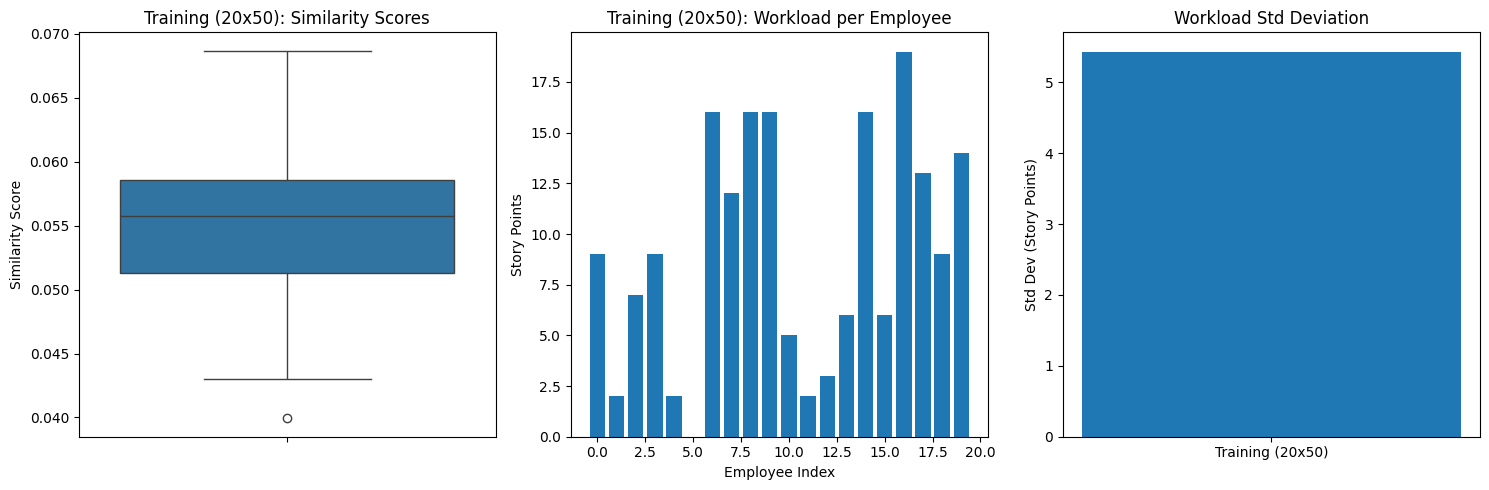

Test (9x20) Results:
  Active Employees: 8/9
  Avg Skill Suitability: 0.0550
  Workload Std Dev: 3.1524
  Total Steps: 20
  Total Time: 0.03s


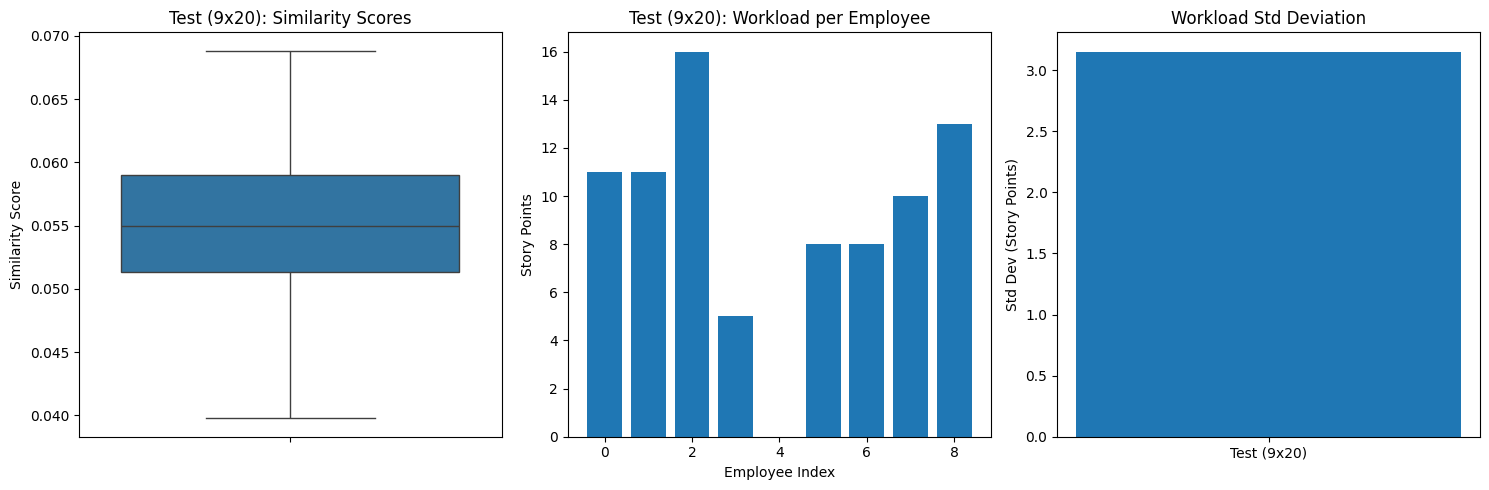

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

def evaluate_and_visualize(env, model, task_ids, emp_ids, skill_scores, story_points, dataset_name):
    # Run inference
    obs = env.reset()
    done = False
    steps = 0
    start_time = time.time()

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action[1] = min(action[1], env.num_employees - 1)  # Clamp employee index
        if (action[0] in env.unassigned_tasks and
            env.workload[action[1]] + env.story_points[action[0]] <= env.max_workload):
            obs, reward, done, info = env.step(action)
        else:
            valid_tasks = env.unassigned_tasks
            valid_emps = [e for e in range(env.num_employees) if env.workload[e] < env.max_workload]
            if valid_tasks and valid_emps:
                action = [np.random.choice(valid_tasks), np.random.choice(valid_emps)]
                obs, reward, done, info = env.step(action)
            else:
                done = True
        steps += 1
        if steps > 100:  # Safety break
            print(f"Breaking after 100 steps for {dataset_name}")
            break

    end_time = time.time()

    # Extract results
    assignments = env.assignments[:len(task_ids), :len(emp_ids)]
    active_employees = np.sum(np.any(assignments, axis=0))
    similarity_scores = [skill_scores[t, e] for t, e in np.argwhere(assignments)]
    workloads = np.zeros(len(emp_ids))
    for t, e in np.argwhere(assignments):
        workloads[e] += story_points[task_ids[t]]
    workload_std = np.std(workloads[workloads > 0]) if np.any(workloads) else 0

    # Print summary
    print(f"{dataset_name} Results:")
    print(f"  Active Employees: {active_employees}/{len(emp_ids)}")
    print(f"  Avg Skill Suitability: {np.mean(similarity_scores):.4f}")
    print(f"  Workload Std Dev: {workload_std:.4f}")
    print(f"  Total Steps: {steps}")
    print(f"  Total Time: {end_time - start_time:.2f}s")

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Boxplot for Similarity Scores
    plt.subplot(1, 3, 1)
    sns.boxplot(y=similarity_scores)
    plt.title(f"{dataset_name}: Similarity Scores")
    plt.ylabel("Similarity Score")

    # Bar Chart for Workloads
    plt.subplot(1, 3, 2)
    plt.bar(range(len(emp_ids)), workloads)
    plt.title(f"{dataset_name}: Workload per Employee")
    plt.xlabel("Employee Index")
    plt.ylabel("Story Points")

    # Bar Chart for Std Dev
    plt.subplot(1, 3, 3)
    plt.bar([0], [workload_std])
    plt.xticks([0], [dataset_name])
    plt.title("Workload Std Deviation")
    plt.ylabel("Std Dev (Story Points)")

    plt.tight_layout()
    plt.show()

    return assignments, similarity_scores, workloads, workload_std

# Load model (assuming already trained)
loaded_model = PPO.load("ppo_moo_subset")

# Evaluate Training Data
train_env = MOOEnv(train_skill_scores, train_story_points)
train_assignments, train_sim_scores, train_workloads, train_std = evaluate_and_visualize(
    train_env, loaded_model, train_tasks, train_emp, train_skill_scores, train_story_points, "Training (20x50)"
)

# Evaluate Test Data
test_env = MOOEnv(test_skill_scores, test_story_points)
test_assignments, test_sim_scores, test_workloads, test_std = evaluate_and_visualize(
    test_env, loaded_model, test_tasks, test_emp, test_skill_scores, test_story_points, "Test (9x20)"
)

# RL with Transformers

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy

class TaskAssignmentEnv(gym.Env):
    def __init__(self, task_skills, employee_skills, story_points):
        super().__init__()

        self.task_skills = torch.FloatTensor(task_skills)
        self.employee_skills = torch.FloatTensor(employee_skills)
        self.story_points = torch.FloatTensor(story_points)

        self.num_tasks = len(task_skills)
        self.num_employees = len(employee_skills)

        # Calculate correct observation space dimension
        # task_skills: num_tasks * 65
        # employee_skills: num_employees * 65
        # workload: num_employees
        # available_tasks: num_tasks
        obs_dim = (self.num_tasks * 65) + (self.num_employees * 65) + self.num_employees + self.num_tasks

        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(obs_dim,),
            dtype=np.float32
        )

        # Action space: [task_index, employee_index]
        self.action_space = spaces.MultiDiscrete([self.num_tasks, self.num_employees])

        self.reset()

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.workload = torch.zeros(self.num_employees)
        self.assignments = torch.zeros((self.num_tasks, self.num_employees))
        self.available_tasks = torch.ones(self.num_tasks)
        return self._get_state(), {}

    def _get_state(self):
        # Flatten and concatenate all state components
        task_state = self.task_skills.flatten()
        emp_state = self.employee_skills.flatten()
        workload_state = self.workload
        mask_state = self.available_tasks

        state = torch.cat([
            task_state,
            emp_state,
            workload_state,
            mask_state
        ]).numpy()

        return state

    def step(self, action):
        task_idx, emp_idx = action
        reward = 0
        done = False

        if (self.available_tasks[task_idx] == 1 and
            self.workload[emp_idx] + self.story_points[task_idx] <= 20):

            # Make assignment
            self.assignments[task_idx, emp_idx] = 1
            self.workload[emp_idx] += self.story_points[task_idx]
            self.available_tasks[task_idx] = 0

            # Calculate reward components
            skill_match = self._calculate_skill_match(task_idx, emp_idx)

            # Fix workload balance calculation
            active_workloads = self.workload[self.workload > 0]
            if len(active_workloads) > 1:
                workload_balance = -torch.var(active_workloads, unbiased=False).item()
            else:
                workload_balance = 0.0

            reward = float(skill_match + 0.1 * workload_balance)
        else:
            reward = -1.0

        done = bool(self.available_tasks.sum() == 0)

        return self._get_state(), reward, done, False, {}

    def _calculate_skill_match(self, task_idx, emp_idx):
        task_skills = self.task_skills[task_idx]
        emp_skills = self.employee_skills[emp_idx]

        skill_diff = torch.relu(emp_skills - task_skills)
        match_score = 1 - torch.mean(skill_diff)

        return match_score.item()

class CustomNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.shared_net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.policy_net = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.value_net = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        shared_features = self.shared_net(x)
        return self.policy_net(shared_features), self.value_net(shared_features)

class CustomPolicy(ActorCriticPolicy):
    def __init__(self, observation_space, action_space, lr_schedule, **kwargs):
        # Fix net_arch format
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch=dict(pi=[64, 64], vf=[64, 64]),  # Changed from list to dict
            **kwargs
        )

def load_data():
    # Paths
    employee_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'
    task_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'

    # Load data
    employee_df = pd.read_csv(employee_path, index_col='employee_id').fillna(0)
    employee_df.drop(columns=['No', 'Role'], inplace=True, errors='ignore')
    task_df = pd.read_csv(task_path, index_col='task_id').fillna(0)

    # Create training sets
    train_task_skills = task_df.drop(columns=['project_id', 'story_points']).values[:50]
    train_emp_skills = employee_df.values[:20]
    train_story_points = task_df['story_points'].values[:50]  # Changed from dict to array

    return train_task_skills, train_emp_skills, train_story_points

# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load data
task_skills, employee_skills, story_points = load_data()

# Print shapes for debugging
print("Data Shapes:")
print(f"Task Skills: {task_skills.shape}")
print(f"Employee Skills: {employee_skills.shape}")
print(f"Story Points: {story_points.shape}")

# Create environment and train
env = TaskAssignmentEnv(task_skills, employee_skills, story_points)

model = PPO(
    CustomPolicy,
    env,
    verbose=1,
    batch_size=64,
    n_steps=2048,
    learning_rate=3e-4,
    n_epochs=10,
    # Add these parameters for stability
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    normalize_advantage=True,
    target_kl=0.01
)

model.learn(total_timesteps=50000)
model.save("ppo_simplified")

ModuleNotFoundError: No module named 'stable_baselines3'

In [1]:
!pip install stable_baselines3
!pip install shimmy

In [3]:
!pip install shimmy

In [14]:
import numpy as np
import pandas as pd
from google.colab import drive
import gym
from gym import spaces
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.policies import MultiInputActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Paths
employee_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'
task_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'

# Load data
employee_df = pd.read_csv(employee_path, index_col='employee_id').fillna(0)
employee_df.drop(columns=['No', 'Role'], inplace=True, errors='ignore')
task_df = pd.read_csv(task_path, index_col='task_id').fillna(0)

employees = employee_df.index.tolist()
tasks = task_df.index.tolist()
story_points = task_df['story_points'].to_dict()
task_skills = task_df.drop(columns=['project_id', 'story_points']).values
employee_skills = employee_df.values

# Subsets
train_emp = employees[:20]
train_tasks = tasks[:50]
train_emp_skills = employee_skills[:20]
train_task_skills = task_skills[:50]
train_story_points = [story_points[t] for t in train_tasks]

test_emp = employees[20:29]
test_tasks = tasks[50:70]
test_emp_skills = employee_skills[20:29]
test_task_skills = task_skills[50:70]
test_story_points = [story_points[t] for t in test_tasks]

# WED function
def calculate_weighted_euclidean_distance(employee_skills, task_skills, alpha=0.05):
    employee_skills = np.array(employee_skills)
    task_skills = np.array(task_skills)
    weights = 1 / (1 + alpha * np.maximum(0, employee_skills - task_skills))
    wed = np.sqrt(np.sum(weights * (employee_skills - task_skills) ** 2))
    max_task_skills = np.full(len(task_skills), 5)
    min_employee_skills = np.zeros(len(employee_skills))
    max_weights = 1 / (1 + alpha * np.maximum(0, min_employee_skills - max_task_skills))
    max_wed = np.sqrt(np.sum(max_weights * (min_employee_skills - max_task_skills) ** 2))
    normalized_wed = 1 - (wed / max_wed)
    return normalized_wed

# Environment with Debugging
class MOOEnv(gym.Env):
    def __init__(self, task_skills, employee_skills, story_points, max_workload=20, max_tasks=300, max_employees=109):
        super().__init__()
        self.task_skills = task_skills
        self.employee_skills = employee_skills
        self.num_tasks = task_skills.shape[0]
        self.num_employees = employee_skills.shape[0]
        self.story_points = story_points
        self.max_workload = max_workload
        self.max_tasks = max_tasks
        self.max_employees = max_employees

        self.assignments = np.zeros((self.num_tasks, self.num_employees), dtype=np.float32)
        self.workload = np.zeros(self.num_employees, dtype=np.float32)
        self.unassigned_tasks = list(range(self.num_tasks))

        self.action_space = spaces.MultiDiscrete([max_tasks, max_employees])
        feature_dim = 68
        self.observation_space = spaces.Dict({
            'sequence': spaces.Box(low=-np.inf, high=np.inf, shape=(max_tasks + max_employees, feature_dim), dtype=np.float32),
            'is_unassigned': spaces.Box(low=0, high=1, shape=(max_tasks,), dtype=np.float32),
            'is_available': spaces.Box(low=0, high=1, shape=(max_employees,), dtype=np.float32),
        })

    def reset(self):
        self.assignments = np.zeros((self.num_tasks, self.num_employees))
        self.workload = np.zeros(self.num_employees)
        self.unassigned_tasks = list(range(self.num_tasks))
        print(f"Reset: {self.num_tasks} tasks, {self.num_employees} employees, unassigned_tasks: {len(self.unassigned_tasks)}")
        return self._get_obs()

    def _get_obs(self):
        sequence = np.zeros((self.max_tasks + self.max_employees, 68), dtype=np.float32)
        for i in range(self.num_tasks):
            sequence[i, :65] = self.task_skills[i]
            sequence[i, 65] = self.story_points[i]
            sequence[i, 66] = 1
            sequence[i, 67] = 1 if i in self.unassigned_tasks else 0
        for j in range(self.num_employees):
            sequence[self.max_tasks + j, :65] = self.employee_skills[j]
            sequence[self.max_tasks + j, 65] = self.workload[j]
            sequence[self.max_tasks + j, 66] = 0
            sequence[self.max_tasks + j, 67] = 1 if self.workload[j] < self.max_workload else 0
        is_unassigned = np.zeros(self.max_tasks, dtype=np.float32)
        is_unassigned[:self.num_tasks] = [1 if k in self.unassigned_tasks else 0 for k in range(self.num_tasks)]
        is_available = np.zeros(self.max_employees, dtype=np.float32)
        is_available[:self.num_employees] = [1 if self.workload[j] < self.max_workload else 0 for j in range(self.num_employees)]
        return {
            'sequence': sequence,
            'is_unassigned': is_unassigned,
            'is_available': is_available,
        }

    def step(self, action):
        task_idx, emp_idx = action
        print(f"Action: task {task_idx}, emp {emp_idx}")
        valid = (task_idx < self.num_tasks and task_idx in self.unassigned_tasks and
                 emp_idx < self.num_employees and self.workload[emp_idx] + self.story_points[task_idx] <= self.max_workload)
        if valid:
            print(f"Valid action, assigning task {task_idx} to emp {emp_idx}")
            self.assignments[task_idx, emp_idx] = 1
            self.workload[emp_idx] += self.story_points[task_idx]
            self.unassigned_tasks.remove(task_idx)
            reward = self._compute_reward(task_idx, emp_idx)
        else:
            print(f"Invalid action")
            reward = -1
        done = len(self.unassigned_tasks) == 0
        print(f"Unassigned tasks left: {len(self.unassigned_tasks)}, Assignments sum: {np.sum(self.assignments)}")
        return self._get_obs(), reward, done, {}

    def _compute_reward(self, task_idx, emp_idx):
        idle_reward = 1 if self.workload[emp_idx] == 0 else 0.1
        skill_reward = calculate_weighted_euclidean_distance(self.employee_skills[emp_idx], self.task_skills[task_idx])
        temp_workload = self.workload.copy()
        temp_workload[emp_idx] += self.story_points[task_idx]
        active_workloads = temp_workload[temp_workload > 0]
        workload_reward = -np.var(active_workloads) if len(active_workloads) > 1 else 0
        return (0.05 * idle_reward) + (0.85 * skill_reward) + (0.1 * workload_reward)

# Transformer Extractor with Debugging
class TransformerExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict, max_tasks=300, max_employees=109):
        feature_dim = observation_space.spaces['sequence'].shape[1]  # 68
        super().__init__(observation_space, features_dim=feature_dim)
        self.max_tasks = max_tasks
        self.max_employees = max_employees
        embedding_dim = 128
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=feature_dim, nhead=4, dim_feedforward=embedding_dim, batch_first=True),
            num_layers=2
        )

    def forward(self, observations: dict) -> torch.Tensor:
        sequence = observations['sequence']
        print(f"Sequence shape: {sequence.shape}")
        mask = (sequence.sum(dim=-1) != 0).bool()
        embeddings = self.transformer(sequence, src_key_padding_mask=~mask)
        print(f"Embeddings shape: {embeddings.shape}")
        features = embeddings.mean(dim=1)
        print(f"Features shape from extractor: {features.shape}")
        return features

# Transformer Policy with Enhanced Debugging
class TransformerPolicy(MultiInputActorCriticPolicy):
    def __init__(self, observation_space, action_space, lr_schedule, max_tasks=300, max_employees=109, **kwargs):
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            features_extractor_class=TransformerExtractor,
            features_extractor_kwargs={'max_tasks': max_tasks, 'max_employees': max_employees},
            **kwargs
        )
        self.max_tasks = max_tasks
        self.max_employees = max_employees
        feature_dim = observation_space.spaces['sequence'].shape[1]  # 68

        # Shared network with consistent dimensions
        self.shared_net = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Action heads with proper dimensions
        self.task_net = nn.Sequential(
            nn.Linear(128, max_tasks)
        )

        self.emp_net = nn.Sequential(
            nn.Linear(128, max_employees)
        )

        # Value network matching shared features dimension
        self.value_net = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, obs, deterministic=False):
        features = self.extract_features(obs)  # [batch_size, 68]
        shared_features = self.shared_net(features)  # [batch_size, 128]

        # Get logits
        task_logits = self.task_net(shared_features)  # [batch_size, max_tasks]
        emp_logits = self.emp_net(shared_features)    # [batch_size, max_employees]

        # Get value
        value = self.value_net(shared_features)       # [batch_size, 1]
        value = value.squeeze(-1)                     # [batch_size]

        # Convert masks to proper device and shape
        is_unassigned = obs['is_unassigned'].to(task_logits.device)
        is_available = obs['is_available'].to(emp_logits.device)

        task_logits = task_logits.masked_fill(is_unassigned == 0, -1e9)
        emp_logits = emp_logits.masked_fill(is_available == 0, -1e9)

        task_dist = torch.distributions.Categorical(logits=task_logits)
        emp_dist = torch.distributions.Categorical(logits=emp_logits)

        if deterministic:
            task_action = task_dist.probs.argmax(dim=-1)
            emp_action = emp_dist.probs.argmax(dim=-1)
        else:
            task_action = task_dist.sample()
            emp_action = emp_dist.sample()

        action = torch.stack([task_action, emp_action], dim=1)
        log_prob = task_dist.log_prob(task_action) + emp_dist.log_prob(emp_action)
        return action, value, log_prob

# Train
train_env = MOOEnv(train_task_skills, train_emp_skills, train_story_points)
model = PPO(
    TransformerPolicy,
    train_env,
    verbose=1,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    policy_kwargs={'max_tasks': 300, 'max_employees': 109},
    learning_rate=3e-4
)
print(f"Value net weight shape: {model.policy.value_net[0].weight.shape}")
model.learn(total_timesteps=50000)
model.save("ppo_transformer_subset_wed")

# Test
print("\nEvaluating trained model...")
test_env = MOOEnv(test_task_skills, test_emp_skills, test_story_points)
loaded_model = PPO.load("ppo_transformer_subset_wed")

obs = test_env.reset()
done = False
step_count = 0
while not done:
    action, _ = loaded_model.predict(obs, deterministic=True)
    obs, reward, done, _ = test_env.step(action)
    step_count += 1
    if step_count > 100:
        print("Breaking after 100 steps to avoid infinite loop")
        break

assignments = test_env.assignments[:len(test_tasks), :len(test_emp)]
active_employees = np.sum(np.any(assignments, axis=0))
similarity_scores = [calculate_weighted_euclidean_distance(test_emp_skills[e], test_task_skills[t])
                     for t, e in np.argwhere(assignments)]
workload_var = np.var(test_env.workload[test_env.workload > 0]) if np.any(test_env.workload) else 0

print("Test Results (9 employees x 20 tasks):")
print(f"  Active Employees: {active_employees}/9")
print(f"  Avg Skill Suitability: {np.mean(similarity_scores):.4f}")
print(f"  Workload Variance: {workload_var:.4f}")
print("Assignments:", np.argwhere(assignments))
print("Final unassigned tasks:", test_env.unassigned_tasks)
print("Total assignments made:", np.sum(test_env.assignments))
if len(test_env.unassigned_tasks) == 0 and np.sum(test_env.assignments) == 0:
    print("BUG DETECTED: All tasks 'assigned' but no assignments recorded!")

Mounted at /content/drive
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Value net weight shape: torch.Size([64, 128])
Reset: 50 tasks, 20 employees, unassigned_tasks: 50
Sequence shape: torch.Size([1, 409, 68])
Embeddings shape: torch.Size([1, 409, 68])
Features shape from extractor: torch.Size([1, 68])
Action: task 19, emp 8
Valid action, assigning task 19 to emp 8
Unassigned tasks left: 49, Assignments sum: 1.0
Sequence shape: torch.Size([1, 409, 68])
Embeddings shape: torch.Size([1, 409, 68])
Features shape from extractor: torch.Size([1, 68])
Action: task 15, emp 7
Valid action, assigning task 15 to emp 7
Unassigned tasks left: 48, Assignments sum: 2.0
Sequence shape: torch.Size([1, 409, 68])
Embeddings shape: torch.Size([1, 409, 68])
Features shape from extractor: torch.Size([1, 68])
Action: task 0, emp 11
Valid action, assigning task 0 to emp 11
Unassigned tasks left: 47, Assignments sum: 3.0
Sequence shape: torch.Size([1, 409, 68])

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Unassigned tasks left: 24, Assignments sum: 26.0
Sequence shape: torch.Size([1, 409, 68])
Embeddings shape: torch.Size([1, 409, 68])
Features shape from extractor: torch.Size([1, 68])
Action: task 49, emp 5
Valid action, assigning task 49 to emp 5
Unassigned tasks left: 23, Assignments sum: 27.0
Sequence shape: torch.Size([1, 409, 68])
Embeddings shape: torch.Size([1, 409, 68])
Features shape from extractor: torch.Size([1, 68])
Action: task 27, emp 12
Valid action, assigning task 27 to emp 12
Unassigned tasks left: 22, Assignments sum: 28.0
Sequence shape: torch.Size([1, 409, 68])
Embeddings shape: torch.Size([1, 409, 68])
Features shape from extractor: torch.Size([1, 68])
Action: task 45, emp 18
Valid action, assigning task 45 to emp 18
Unassigned tasks left: 21, Assignments sum: 29.0
Sequence shape: torch.Size([1, 409, 68])
Embeddings shape: torch.Size([1, 409, 68])
Features shape from extractor: torch.Size([1, 68])
Action: task 11, 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x64 and 128x64)

# 4 RL Approaches
- Fixed-Size Observation Space with Padding
- Dynamic Observation Space with Masking
- State Normalization (Scalable Features)
- Curriculum Learning

## Pick subset from the dataset

In [17]:
from google.colab import drive
import pandas as pd
import numpy as np

def create_subset_data(n_employees=10, n_tasks=50):
    """Create subset of the original dataset"""
    # Mount Google Drive
    drive.mount('/content/drive')

    # Source paths
    task_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'
    employee_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'

    # Load and preprocess original data
    df_tasks_original = pd.read_csv(task_data_path)
    df_employees_original = pd.read_csv(employee_data_path)

    # Extract common skills
    task_skill_cols = [col for col in df_tasks_original.columns[3:]]
    employee_skill_cols = [col for col in df_employees_original.columns[2:]]
    common_skills = list(set(task_skill_cols).intersection(employee_skill_cols))

    # Filter dataframes
    df_tasks = df_tasks_original[['task_name', 'story_points'] + common_skills]
    df_employees = df_employees_original[['employee_id', 'Role'] + common_skills]

    # Select random subset
    emp_subset = df_employees.sample(n=n_employees, random_state=42)
    task_subset = df_tasks.sample(n=n_tasks, random_state=42)

    # Save subsets to Colab working directory
    emp_subset.to_csv('subset_employee.csv', index=False)
    task_subset.to_csv('subset_task.csv', index=False)

    print(f"Created subset with {n_employees} employees and {n_tasks} tasks")
    return emp_subset, task_subset

if __name__ == "__main__":
    emp_subset, task_subset = create_subset_data()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyError: "['task_name'] not in index"

## MOO to compare the output

In [ ]:
import pandas as pd
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt

def calculate_weighted_euclidean_distance(emp_skills, task_skills, a=0.5):
    """Calculate weighted Euclidean distance with global normalization"""
    diff = emp_skills - task_skills
    w = 1 / (1 + a * np.maximum(0, diff))
    squared_diff = w * (diff ** 2)
    return np.sqrt(np.sum(squared_diff[task_skills > 0]))

class MOOBenchmark:
    def __init__(self, max_workload=20):
        # Load and preprocess data
        self.max_workload = max_workload
        self.load_data()
        self.calculate_similarity_scores()

    def load_data(self):
        # Load from Colab working directory
        emp_df = pd.read_csv('subset_employee.csv').fillna(0)
        task_df = pd.read_csv('subset_task.csv').fillna(0)

        # Process employee data
        self.employee_skills = emp_df.drop(columns=['employee_id', 'Role']).values
        self.num_employees = len(emp_df)

        # Process task data
        self.story_points = task_df['story_points'].values
        self.task_skills = task_df.drop(columns=['task_name', 'epic', 'story_points']).values
        self.num_tasks = len(task_df)

        print(f"Loaded {self.num_employees} employees and {self.num_tasks} tasks")

    def calculate_similarity_scores(self):
        self.similarity_scores = np.zeros((self.num_tasks, self.num_employees))
        for i in range(self.num_tasks):
            for j in range(self.num_employees):
                self.similarity_scores[i, j] = calculate_weighted_euclidean_distance(
                    self.employee_skills[j], self.task_skills[i]
                )

    def optimize(self):
        # Create model
        model = Model("task_assignment")

        # Decision variables
        x = {}
        for i in range(self.num_tasks):
            for j in range(self.num_employees):
                x[i,j] = model.addVar(vtype=GRB.BINARY, name=f'x_{i}_{j}')

        # Workload variable
        max_workload_var = model.addVar(vtype=GRB.CONTINUOUS, name='max_workload')

        # Constraints
        # Each task assigned to one employee
        for i in range(self.num_tasks):
            model.addConstr(quicksum(x[i,j] for j in range(self.num_employees)) == 1)

        # Workload constraints
        for j in range(self.num_employees):
            model.addConstr(
                quicksum(self.story_points[i] * x[i,j] for i in range(self.num_tasks))
                <= self.max_workload
            )
            model.addConstr(
                quicksum(self.story_points[i] * x[i,j] for i in range(self.num_tasks))
                <= max_workload_var
            )

        # Objective components
        idle_obj = quicksum(
            1 - quicksum(x[i,j] for i in range(self.num_tasks))
            for j in range(self.num_employees)
        )

        skill_obj = quicksum(
            self.similarity_scores[i,j] * x[i,j]
            for i in range(self.num_tasks)
            for j in range(self.num_employees)
        )

        # Multi-objective with weights
        model.setObjective(
            0.05 * idle_obj +
            0.85 * skill_obj +
            0.10 * max_workload_var,
            GRB.MINIMIZE
        )

        # Optimize
        model.optimize()

        # Extract results
        assignments = np.zeros((self.num_tasks, self.num_employees))
        if model.status == GRB.OPTIMAL:
            for i in range(self.num_tasks):
                for j in range(self.num_employees):
                    if x[i,j].X > 0.5:
                        assignments[i,j] = 1

        return assignments

    def evaluate_solution(self, assignments):
        # Calculate metrics
        workloads = np.sum(assignments * self.story_points[:, np.newaxis], axis=0)
        active_employees = np.sum(np.any(assignments, axis=0))
        skill_scores = np.sum(assignments * self.similarity_scores)
        workload_var = np.var(workloads[workloads > 0])

        return {
            'active_employees': active_employees,
            'avg_skill_score': skill_scores / self.num_tasks,
            'workload_variance': workload_var,
            'assignments': assignments,
            'workloads': workloads
        }

if __name__ == "__main__":
    # First create the subset
    from create_subset import create_subset_data
    create_subset_data()

    # Then run the benchmark
    benchmark = MOOBenchmark()
    assignments = benchmark.optimize()
    results = benchmark.evaluate_solution(assignments)

    # Create output directory in Colab
    !mkdir -p output

    # Print and visualize results
    print("\nResults:")
    print(f"Active Employees: {results['active_employees']}/{benchmark.num_employees}")
    print(f"Average Skill Score: {results['avg_skill_score']:.4f}")
    print(f"Workload Variance: {results['workload_variance']:.4f}")

## Fixed-Side Observation Space with Padding

## Dynamic Observation Space with Masking

## State Normalization (Scalable Features)

## Curriculum Learning

# Recalculate old WED to new WED

Mounted at /content/drive
max_wed untuk 65 dimensi: 21.55
Hasil disimpan ke: /content/drive/MyDrive/Skripsi/Resources/Datasets/Recent/result_moo_adjusted.csv


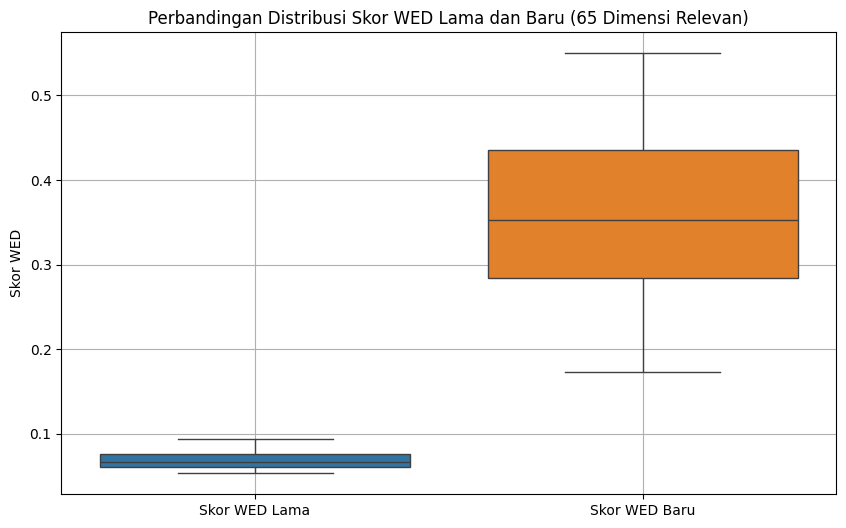


Statistik Skor WED Lama:
count    300.000000
mean       0.068529
std        0.009396
min        0.053136
25%        0.060881
50%        0.066885
75%        0.075992
max        0.093468
dtype: float64

Statistik Skor WED Baru:
count    300.000000
mean       0.356776
std        0.091614
min        0.173007
25%        0.284104
50%        0.352536
75%        0.435691
max        0.549883
dtype: float64


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import ast

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Path ke file
path_dataset = '/content/drive/MyDrive/Skripsi/Resources/Datasets/Recent/result_moo.csv'
output_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/Recent/result_moo_adjusted.csv'

# Fungsi untuk menghitung max_wed berdasarkan jumlah dimensi relevan
def calculate_max_wed(num_relevant_skills, a=0.5):
    w_max = 1 / (1 + a * 5)  # a = 0.5, max difference = 5
    max_distance_per_skill = w_max * (5**2)
    return np.sqrt(num_relevant_skills * max_distance_per_skill)

# Jumlah dimensi keterampilan yang relevan: 65
relevant_skills = 65
max_wed = calculate_max_wed(relevant_skills)  # ≈ 21.55
print(f"max_wed untuk {relevant_skills} dimensi: {max_wed:.2f}")

# Baca file results_moo.csv
df = pd.read_csv(path_dataset)

# Fungsi untuk mengubah string daftar menjadi daftar Python
def parse_list_column(col):
    return col.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Parse kolom yang berisi daftar
df['company'] = parse_list_column(df['company'])
df['assigned_task'] = parse_list_column(df['assigned_task'])
df['similarity_score'] = parse_list_column(df['similarity_score'])

# Ekstrak semua skor WED lama untuk boxplot
all_scores_old = []
for scores in df['similarity_score']:
    all_scores_old.extend(scores)

# Ubah skor WED lama ke skor WED baru
def adjust_wed_scores(scores, max_wed_value):
    adjusted_scores = []
    for score in scores:
        # Rekonstruksi jarak dari skor lama
        distance = (1 / score) - 1
        # Hitung WED baru
        wed_new = 1 - (distance / max_wed_value)
        # Pastikan skor berada dalam rentang [0, 1]
        wed_new = max(0, min(1, wed_new))
        adjusted_scores.append(wed_new)
    return adjusted_scores

# Terapkan penyesuaian ke setiap baris
df['similarity_score_new'] = df['similarity_score'].apply(lambda x: adjust_wed_scores(x, max_wed))

# Ekstrak semua skor WED baru untuk boxplot
all_scores_new = []
for scores in df['similarity_score_new']:
    all_scores_new.extend(scores)

# Simpan hasil ke CSV baru
df.to_csv(output_path, index=False)
print(f"Hasil disimpan ke: {output_path}")

# Buat boxplot untuk membandingkan distribusi
plt.figure(figsize=(10, 6))
sns.boxplot(data=[all_scores_old, all_scores_new], orient='v')
plt.xticks([0, 1], ['Skor WED Lama', 'Skor WED Baru'])
plt.ylabel('Skor WED')
plt.title('Perbandingan Distribusi Skor WED Lama dan Baru (65 Dimensi Relevan)')
plt.grid(True)
plt.show()

# Tampilkan statistik
print("\nStatistik Skor WED Lama:")
print(pd.Series(all_scores_old).describe())
print("\nStatistik Skor WED Baru:")
print(pd.Series(all_scores_new).describe())